# RANDOM FOREST RESEARCH!

https://academic.oup.com/mnras/article/476/3/3974/4907985

https://watermark.silverchair.com/sty511.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsgwggLEBgkqhkiG9w0BBwagggK1MIICsQIBADCCAqoGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM0Ac-VEZECgPL_3nyAgEQgIICe4w7zTh7Rsal3GzwxA3QbVQiZSucT4ZCIGt8xEajVzr0izG25q4mgWRleQczyLk_ERJyWOBLpuOWM18kXuAWTBwfC78eUCzowwhtTJT0SutR2gZ6JvA_o-pHl6RoejzaM3UkKNGAcV28nJiCOqtrCtZ2TsKHjMqEYvVfnXRT8D77q7jLOkan669bymVgUlDJpWrvw52MxP5aO_SD3iz9KjM9gs7Xe3LSrGBQHHJW-7XRdieXh5SKPZQMW21rLD8koP2vYuvLb2Tb6F6azl3hrYelY49wh3xtMBE0gLydQBi-gN87CPaHAY7xlLgNh_TNch315ZWLTfn1ifALoYcWhLiZXTQWAuk84IhMVw0a2hVZwaA7Lda35qEwV61NJsNvR_Rn9JkhUU5srrEdULTpn_gWsIAL3nDE1sXJTTD9KI-Cagx78ak42r6No6DMdheca8Uxj1DBV8xGY_tihx1L01639wFwgWtyPSmWJd7ZKrPrXdONtNLbjih0IH71CPvYElSPsj2ucamjTXjgmtWvz4KWwIEnzrgpzU2nzgL5B2_Ky83sRFG4fB9UTlsAR6UzLy7OSYOJkymFUmYXn_S2uq5E_V7j5Q8ON4o65XS8q7xD2LIFlMM1OkoIaB-W-tc1hqXXY68NJzuMwGrHxXSKYowKpYYF4EGgo2q_r3S3kzMjMpG8R_wvooAuBvXKEDZXNG2ZkfjHkYLJdTUXUrIHqT9I39ORkLYur92_nDzMHVb93NUBrfVPPaNxXih5KJAkEPD2tvnwP82SktcIRQokY_FQN6fjBZtj-0s9cxAuC3YcnZU4suBzY4xbCC5wV4nEObQLjy-1b25J2oqL

https://www.google.com/search?q=random+forest+spectra+classifier+astronomy&rlz=1C1VDKB_enUS1006US1006&sxsrf=ALiCzsYZRbW0P1i-hPtXdjjvYDN5zNVhqA%3A1669615767817&ei=l1CEY7nBMdasqtsPj8q7oAs&ved=0ahUKEwj56IG2m9D7AhVWlmoFHQ_lDrQQ4dUDCBA&uact=5&oq=random+forest+spectra+classifier+astronomy&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQogQyBQgAEKIEMgUIABCiBDIFCAAQogQyBQgAEKIEOgoIABBHENYEELADOgcIIxCwAhAnOgQIIxAnOgcIABAeEKIESgQIQRgASgQIRhgAUK4DWNAmYLcsaAFwAXgAgAFqiAGjB5IBBDEwLjGYAQCgAQHIAQjAAQE&sclient=gws-wiz-serp


https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

https://www.aanda.org/articles/aa/full_html/2015/12/aa25752-15/aa25752-15.html

https://towardsdatascience.com/predicting-stars-galaxies-quasars-with-random-forest-classifiers-in-python-edb127878e43

http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

https://www.aanda.org/articles/aa/abs/2022/11/aa44116-22/aa44116-22.html

https://github.com/topics/notes-template

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os 

# Imports added from modifying the original code
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, Column, join
from hetdex_tools.get_spec import get_spectra

2023-01-25 22:41:49.356059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 22:41:49.521899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 22:41:49.521947: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 22:41:50.447501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Keras is a deep learning API written in Python, running on top of ther machine learning platform TensorFlow. Keras was developed with a focus on enabling fast experimentation.

So Keras is a high-level neural network library that runs on top of TensorFlow. Keras is more user friendly because it's built in Python.

In [2]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History 

Comments and notes by me (Nick D) :) just to help me understand what's going on.

Callbacks: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

Callbacks can be used to:
   * Monitor metrics by writing TensorBoard logs
   * Periodically save model to disk drive
   * Do early stopping
   * Get internal states and stats during training
   * and more!

In [3]:
# This is creating a 'History' callback object. This object keeps track of the accuracy, loss and other training metrics
# for each epoch in the memory.
# Not 100% sure, but it seems like this is what allows the code to make plots later on.
history = History()

In [4]:
# Not entirely sure what the number means. Must be a naming convention about what her cuts were in the data
# after she normalized
#training_index = "31_cut"
training_index = "nick_test"

### Opening HDR3 Catalog and converting it into a Df

In [5]:
# Opening HDR3 detections catalog and converting it into a pandas DF
# HDR3 is detections HETDEX found
# Using HDR3 NEP and not H20 NEP because we can make SN cuts!
HDR_source_cat = fits.open('/home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/source_catalog_3.0.1.fits', memmap = True)
HDR3_data = HDR_source_cat[1].data
HDR3_DF = pd.DataFrame(HDR3_data, columns=HDR3_data.columns.names)

# Columns we will then take from the entire data set (it was huge so we needed to determine what we wanted to look at specifically).
# As the name suggests, these are the ones that are useful to us!
useful_hdr3_cols = ['source_id', 'detectid',  'selected_det', 'ra_mean', 'dec_mean', 'fwhm', 'shotid', 'field',  'ra', 'dec', 'wave', 'wave_err', 'flux', 'flux_err', 'sn', 'sn_err', 'chi2', 'chi2_err',
'linewidth', 'linewidth_err', 'plya_classification', 'z_hetdex', 'z_hetdex_conf', 'combined_plae']

# From the original DFs, taking the useful columns
reduced_hdr3_df = HDR3_DF.loc[:, useful_hdr3_cols]

### Filtering data

In [6]:
# Removing data from before 2017 because it isn't good (not useful to us)
# No need to do this for H20 NEP
removed_bad_shots_hdr3_df = reduced_hdr3_df[reduced_hdr3_df.shotid.values >= 20180000000]

# This will give high confidence detections. Something we would want to do also. What is sn threshold that Valentina's code is having trouble with.
# Reason why, we want high-confidence Lya. If we are very confident sn and another filter, then that's what we consider high-conf lya.
# Once noise and high-confidence sample. We can start exanping on valentina's code and do our own stuff
# We can start with high SN > 6, and slowly decrease to SN > 5
hdr3_signal_to_noise_interval = removed_bad_shots_hdr3_df[removed_bad_shots_hdr3_df['sn'] > 6]


# Now I just take the sources stricly in the NEP field
hdr3_nep = hdr3_signal_to_noise_interval[hdr3_signal_to_noise_interval['field'] == 'nep']

## Checking for duplicates in random sample!

### Notes on code for duplicates (for myself and future reference)
* idx is the return value of indices that are the closest objects to each of the coordinates in hdr3_skycoords
* sep2 is the on-sky separation between the closest match for each element in this object in catalogcoord.
* dist3d the 3D distance between the closest match for each element in this object in catalogcoord. Shape matches this object.

For our purposes we only use idx and sep2.
We use sep2 to check for sources that have a separation of at least 1 arcsecond between them.
We are defining duplicates as sources that are closer than 1 arcsecond.
So the following code basically says, in the idx array give me the SkyCoords which
have a separation greater than 1 arcsecond. The reason I had to use idx was so that I could
have the indexes of the SkyCoords we wanted to keep which I later use to build a non-duplicate SkyCoord object
by making a list of all the skycoords with those idx and then turning that list into a SkyCoord object

In [7]:
# Turn array of hdr3 ra and dec into a SkyCoord object
hdr3_skycoords = SkyCoord(hdr3_nep['ra'] * u.deg, hdr3_nep['dec'] * u.deg)

In [8]:
hdr3_nep

,source_id,detectid,selected_det,ra_mean,dec_mean,fwhm,shotid,field,ra,dec,...,sn,sn_err,chi2,chi2_err,linewidth,linewidth_err,plya_classification,z_hetdex,z_hetdex_conf,combined_plae
118243,3010000117451,3001270559,True,274.088135,66.040260,1.592655,20180712015,nep,274.088165,66.040245,...,15.370000,0.49,1.03,0.22,2.74,0.20,0.001000,2.859164e-01,0.900000,0.006026
118245,3010000117424,3001270581,False,274.175995,66.037384,1.592655,20180712015,nep,274.175690,66.037048,...,8.460000,0.54,1.85,0.23,4.94,1.09,0.481801,-1.708075e-07,0.900000,37.005638
118246,3010000117657,3001270582,False,274.162079,66.038780,1.592655,20180712015,nep,274.161621,66.038643,...,7.680000,0.55,1.54,0.23,5.78,1.41,0.365499,-3.441763e-07,0.900000,1000.000000
118247,3010000117657,3001270587,True,274.162079,66.038780,1.592655,20180712015,nep,274.162598,66.038918,...,9.448597,0.65,1.37,0.22,7.42,1.30,0.558203,-3.441763e-07,0.900000,38.938046
118248,3010000117656,3001270609,True,274.159973,66.039505,1.592655,20180712015,nep,274.159973,66.039505,...,8.370000,0.54,2.50,0.21,3.70,1.33,0.001000,-3.534751e-07,0.800000,0.023592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350056,3010001353007,3013779171,False,273.544403,66.694489,1.247442,20210827008,nep,273.544403,66.694389,...,7.850000,0.73,1.75,0.23,8.56,2.04,0.174392,-4.583050e-07,0.900000,0.006862
1350058,3010001353007,3013779177,False,273.544403,66.694489,1.247442,20210827008,nep,273.544495,66.694748,...,6.960000,0.77,1.00,0.22,9.39,1.97,0.334173,-4.583050e-07,0.900000,0.013657
1350062,3010001353189,3013779202,True,273.814728,66.828026,1.247442,20210827008,nep,273.814728,66.828026,...,14.180000,0.47,1.02,0.22,2.71,0.19,0.086202,2.471672e-01,0.193106,0.188361
1350063,3010001353020,3013779217,False,273.818481,66.830521,1.247442,20210827008,nep,273.818542,66.830482,...,7.120000,0.71,2.11,0.22,6.83,2.28,0.362860,-4.308786e-07,0.900000,388.447601


<AxesSubplot:xlabel='ra', ylabel='dec'>

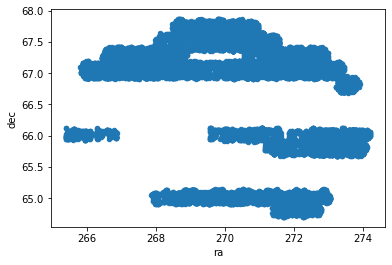

In [26]:
hdr3_nep.plot(x="ra", y="dec", kind="scatter")

# Plotting before removing duplicates

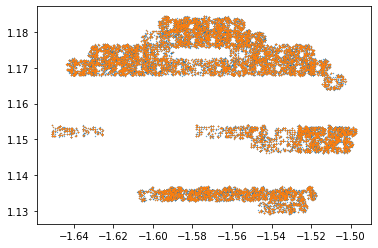

In [34]:
plt.scatter(ra_rad, dec_rad, s = 0.1)
plt.scatter(ra_nodupe_rad, dec_nodupe_rad, s = 0.1)
plt.show()

# Plotting after removing duplicates

(-1.65, -1.59, 1.16, 1.185)

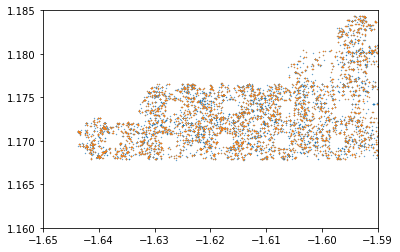

In [51]:
plt.scatter(ra_rad, dec_rad, s = 0.1)
plt.scatter(ra_nodupe_rad, dec_nodupe_rad, s = 0.1)
plt.axis([-1.65, -1.59, 1.16, 1.185])

In [21]:
ra_rad.size

34825

In [22]:
ra_nodupe_rad.size

NameError: name 'ra_nodupe_rad' is not defined

In [11]:
# Use match_to_catalog with 2 as nearest neighbor to check the catalog against itself to find duplicates
idx, sep2, dist3d = hdr3_skycoords.match_to_catalog_sky(hdr3_skycoords, 2)

# Check if SkyCoords have a separation greater than 1 arcsecond, and get the indeces of those
# Keeping everything that has a separation greather than 1 arcsecond
skycoord_sep_checker = idx[sep2 > 1*u.arcsecond]

# initialize list to fill with SkyCoords, for loop below does that
# NOTE: possibly look into not using python loops as they are slow!
skycoord_ls = []
for num in skycoord_sep_checker:
    skycoord_ls.append(hdr3_skycoords[num])
    
hdr3_no_duplicates_SkyCoord = SkyCoord(skycoord_ls)

In [12]:
hdr3_skycoords.size

34825

In [13]:
hdr3_no_duplicates_SkyCoord.size

22097

In [15]:
ra_rad = hdr3_skycoords.ra.wrap_at(180 * u.deg).radian
dec_rad = hdr3_skycoords.dec.radian

In [16]:
ra_rad.size

34825

In [17]:
ra_nodupe_rad.size

NameError: name 'ra_nodupe_rad' is not defined

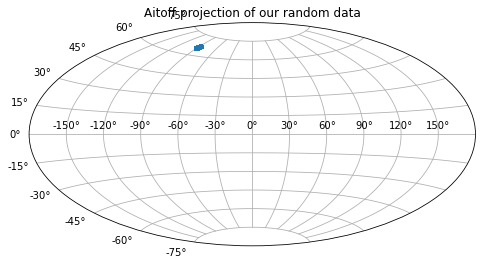

In [54]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of our random data")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

In [23]:
ra_nodupe_rad = hdr3_no_duplicates_SkyCoord.ra.wrap_at(180 * u.deg).radian
dec_nodupe_rad = hdr3_no_duplicates_SkyCoord.dec.radian

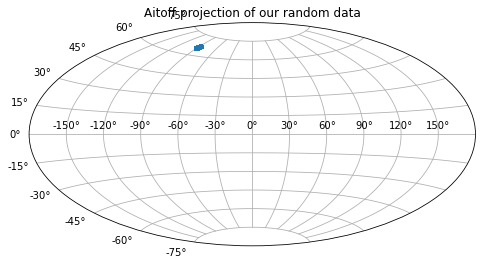

In [35]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of our random data")
plt.grid(True)
plt.plot(ra_nodupe_rad, dec_nodupe_rad, 'o', markersize=2, alpha=0.3)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

# To-do

- After asking if maybe 1 arcseconds is too much, implement this duplicate removal code to other samples as well if necessary.


## Notes 1/23

Would we expect to lose this many ‘duplicates?’ Or should I use a smaller separation value?
Maks sense so sometimes multiple detections so t makes sense.
As sanity check, plot ra and dec of everything.


# Oscar's plan
### (Saving cause slack deletes messages sometimes)
Oh I do not think you want to input your noise sample through Valentina’s code, cause I do not think Valentina trained her encoder with that. What we would want to do is take a random sample of sources in the NEP field, run it through Valentina’s code and then select the output that her code says are high-z. Then we would run this “high-z” sample through your noise separator classification.
So it’ll be a two step process where you would test and train your ML algorithm using random forrest on LAEs and noise, optimize it so it has the highest accuracy possible.
Once you are comfortable with your ML algorithm then we do what i mentioned above, where we take some random sources, maybe we could apply some cuts to enhance the sample, in the NEP field run it through Valentina’s code select what her code says are high-z sources and then run those high-z sources through your ML algorithm and see which of those are actual LAEs and which are noise

# TAKES A LONG TIME. SKIP IF ALREADY HAVE A SAVED VERSION Extracts a random sample of sources in NEP. 

In [32]:
ra_nodupe_rad = hdr3_no_duplicates_SkyCoord.ra.wrap_at(180 * u.deg).radian
dec_nodupe_rad = hdr3_no_duplicates_SkyCoord.dec.radian

In [19]:
# make it 1300, will take a very long time to run!
# making it 1300 because I will later check for duplicates! Want to make sure I have some wiggle room and don't go under 1000
    # Use wavelength to check, if its within a couple angstroms of each other.
    # Could use detectID as well.
samples_amount = 1300

# Initialize my 2d list which will later be turned into an array
# the range is just how many columns (I THINK DOUBLE CHECK THIS)
random_nep_LS = [[0] * 1 for i in range(samples_amount)]

shotid_LS = [0 * 1 for i in range(samples_amount)]

counter = 0

while counter < samples_amount:
    #pick a random coordinate from the skycoord object
    random_coord = hdr3_skycoords[random.randint(0, hdr3_skycoords.size)]
    # extract spectra at this random coordinate and append to list, can't append to np array because of 
    # data type issues will convert to array after loop!
    extraction = get_spectra(random_coord)
    
    # Exctracting only if we have 1 spectra. 
    # Reasoning for this is because if we have more than 1 the shape of the spectra array changes in dimension
    # Asked gene and it's okay to only exctract if one spectra because HETDEX detects are only 1 spectra
    if len(extraction) == 1:
             
        squeezed_extraction = np.squeeze(extraction['spec'].value)
        random_nep_LS[counter] = squeezed_extraction
        shotid_LS[counter] = extraction['shotid'].value
        
        counter += 1
    else:
        continue
    
random_nep_spectra = np.array(random_nep_LS)
random_nep_shotids = np.array(shotid_LS)



[INFO - 2023-01-21 07:56:45,067] Finding shots of interest
[INFO - 2023-01-21 07:56:50,496] Number of shots of interest: 9
[INFO - 2023-01-21 07:56:50,497] Extracting 9 sources
[INFO - 2023-01-21 07:56:50,653] Working on shot: 20210517024
[INFO - 2023-01-21 07:56:50,696] Working on shot: 20210518021
[INFO - 2023-01-21 07:56:50,748] Working on shot: 20210519025
[INFO - 2023-01-21 07:56:50,796] Working on shot: 20210519026
[INFO - 2023-01-21 07:56:50,844] Working on shot: 20210521022
[INFO - 2023-01-21 07:56:50,894] Working on shot: 20210605016
[INFO - 2023-01-21 07:56:50,964] Working on shot: 20210608015
[INFO - 2023-01-21 07:56:50,988] Working on shot: 20210608016
[INFO - 2023-01-21 07:56:51,035] Working on shot: 20210609016
[INFO - 2023-01-21 07:56:54,136] Extracting 1
[INFO - 2023-01-21 07:56:54,320] Extracting 1
[INFO - 2023-01-21 07:56:54,888] Extracting 1
[INFO - 2023-01-21 07:56:55,398] Extraction of sources completed in 0.08 minutes.
[INFO - 2023-01-21 07:56:55,498] Retrieved 3 

[INFO - 2023-01-21 07:58:24,877] Finding shots of interest
[INFO - 2023-01-21 07:58:31,026] Number of shots of interest: 8
[INFO - 2023-01-21 07:58:31,027] Extracting 8 sources
[INFO - 2023-01-21 07:58:31,169] Working on shot: 20190629019
[INFO - 2023-01-21 07:58:31,213] Working on shot: 20190701021
[INFO - 2023-01-21 07:58:31,268] Working on shot: 20190706015
[INFO - 2023-01-21 07:58:31,315] Working on shot: 20190724016
[INFO - 2023-01-21 07:58:31,374] Working on shot: 20190725011
[INFO - 2023-01-21 07:58:31,434] Working on shot: 20190726015
[INFO - 2023-01-21 07:58:31,487] Working on shot: 20190727017
[INFO - 2023-01-21 07:58:31,551] Working on shot: 20190728015
[INFO - 2023-01-21 07:58:32,037] Extracting 1
[INFO - 2023-01-21 07:58:32,044] Extracting 1
[INFO - 2023-01-21 07:58:32,449] Extracting 1
[INFO - 2023-01-21 07:58:32,927] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 07:58:33,018] Retrieved 3 spectra.
[INFO - 2023-01-21 07:58:33,073] Finding shots of int

[INFO - 2023-01-21 08:00:04,261] Working on shot: 20210612014
[INFO - 2023-01-21 08:00:04,307] Working on shot: 20210616018
[INFO - 2023-01-21 08:00:04,363] Working on shot: 20210708012
[INFO - 2023-01-21 08:00:05,130] Extracting 1
[INFO - 2023-01-21 08:00:05,648] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:00:05,731] Retrieved 1 spectra.
[INFO - 2023-01-21 08:00:05,775] Finding shots of interest
[INFO - 2023-01-21 08:00:11,460] Number of shots of interest: 4
[INFO - 2023-01-21 08:00:11,462] Extracting 4 sources
[INFO - 2023-01-21 08:00:11,597] Working on shot: 20200421021
[INFO - 2023-01-21 08:00:11,643] Working on shot: 20200425027
[INFO - 2023-01-21 08:00:11,688] Working on shot: 20200427025
[INFO - 2023-01-21 08:00:11,745] Working on shot: 20200502023
[INFO - 2023-01-21 08:00:12,544] Extracting 1
[INFO - 2023-01-21 08:00:13,104] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:00:13,204] Retrieved 1 spectra.
[INFO - 2023-01-21 08:00:

[INFO - 2023-01-21 08:01:29,294] Working on shot: 20210713017
[INFO - 2023-01-21 08:01:29,347] Working on shot: 20210728010
[INFO - 2023-01-21 08:01:30,128] Extracting 1
[INFO - 2023-01-21 08:01:30,560] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:01:30,649] Retrieved 1 spectra.
[INFO - 2023-01-21 08:01:30,700] Finding shots of interest
[INFO - 2023-01-21 08:01:36,465] Number of shots of interest: 12
[INFO - 2023-01-21 08:01:36,467] Extracting 12 sources
[INFO - 2023-01-21 08:01:36,589] Working on shot: 20210510023
[INFO - 2023-01-21 08:01:36,640] Working on shot: 20210510024
[INFO - 2023-01-21 08:01:36,692] Working on shot: 20210510025
[INFO - 2023-01-21 08:01:36,743] Working on shot: 20210517022
[INFO - 2023-01-21 08:01:36,798] Working on shot: 20210517023
[INFO - 2023-01-21 08:01:36,853] Working on shot: 20210518018
[INFO - 2023-01-21 08:01:36,903] Working on shot: 20210518019
[INFO - 2023-01-21 08:01:36,957] Working on shot: 20210519022
[INFO - 2023-01-21 

[INFO - 2023-01-21 08:02:48,786] Extracting 1
[INFO - 2023-01-21 08:02:49,045] Extracting 1
[INFO - 2023-01-21 08:02:49,238] Extracting 1
[INFO - 2023-01-21 08:02:49,654] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:02:49,753] Retrieved 3 spectra.
[INFO - 2023-01-21 08:02:49,810] Finding shots of interest
[INFO - 2023-01-21 08:02:55,473] Number of shots of interest: 4
[INFO - 2023-01-21 08:02:55,474] Extracting 4 sources
[INFO - 2023-01-21 08:02:55,595] Working on shot: 20200421021
[INFO - 2023-01-21 08:02:55,645] Working on shot: 20200425027
[INFO - 2023-01-21 08:02:55,692] Working on shot: 20200427025
[INFO - 2023-01-21 08:02:55,739] Working on shot: 20200502023
[INFO - 2023-01-21 08:02:56,559] Extracting 1
[INFO - 2023-01-21 08:02:56,878] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:02:56,973] Retrieved 1 spectra.
[INFO - 2023-01-21 08:02:57,033] Finding shots of interest
[INFO - 2023-01-21 08:03:02,832] Number of shots of interest

[INFO - 2023-01-21 08:04:13,112] Retrieved 1 spectra.
[INFO - 2023-01-21 08:04:13,163] Finding shots of interest
[INFO - 2023-01-21 08:04:19,029] Number of shots of interest: 8
[INFO - 2023-01-21 08:04:19,030] Extracting 8 sources
[INFO - 2023-01-21 08:04:19,158] Working on shot: 20200818014
[INFO - 2023-01-21 08:04:19,208] Working on shot: 20200820011
[INFO - 2023-01-21 08:04:19,262] Working on shot: 20210610022
[INFO - 2023-01-21 08:04:19,310] Working on shot: 20210611015
[INFO - 2023-01-21 08:04:19,364] Working on shot: 20210612016
[INFO - 2023-01-21 08:04:19,417] Working on shot: 20210614018
[INFO - 2023-01-21 08:04:19,472] Working on shot: 20210617017
[INFO - 2023-01-21 08:04:19,515] Working on shot: 20210618020
[INFO - 2023-01-21 08:04:20,365] Extracting 1
[INFO - 2023-01-21 08:04:22,550] Extracting 1
[INFO - 2023-01-21 08:04:22,951] Extraction of sources completed in 0.06 minutes.
[INFO - 2023-01-21 08:04:23,044] Retrieved 2 spectra.
[INFO - 2023-01-21 08:04:23,102] Finding shot

[INFO - 2023-01-21 08:05:39,485] Number of shots of interest: 11
[INFO - 2023-01-21 08:05:39,487] Extracting 11 sources
[INFO - 2023-01-21 08:05:39,608] Working on shot: 20180712015
[INFO - 2023-01-21 08:05:39,655] Working on shot: 20180712017
[INFO - 2023-01-21 08:05:39,704] Working on shot: 20180715008
[INFO - 2023-01-21 08:05:39,752] Working on shot: 20180717012
[INFO - 2023-01-21 08:05:39,797] Working on shot: 20180717013
[INFO - 2023-01-21 08:05:39,842] Working on shot: 20180806011
[INFO - 2023-01-21 08:05:39,891] Working on shot: 20180807009
[INFO - 2023-01-21 08:05:39,944] Working on shot: 20180808009
[INFO - 2023-01-21 08:05:39,989] Working on shot: 20200425027
[INFO - 2023-01-21 08:05:40,039] Working on shot: 20200427025
[INFO - 2023-01-21 08:05:40,089] Working on shot: 20200502023
[INFO - 2023-01-21 08:05:40,482] Extracting 1
[INFO - 2023-01-21 08:05:40,882] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:05:40,964] Retrieved 1 spectra.
[INFO - 2023-01-

[INFO - 2023-01-21 08:06:51,334] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:06:51,418] Retrieved 1 spectra.
[INFO - 2023-01-21 08:06:51,464] Finding shots of interest
[INFO - 2023-01-21 08:06:57,503] Number of shots of interest: 4
[INFO - 2023-01-21 08:06:57,504] Extracting 4 sources
[INFO - 2023-01-21 08:06:57,636] Working on shot: 20210510027
[INFO - 2023-01-21 08:06:57,686] Working on shot: 20210514008
[INFO - 2023-01-21 08:06:57,742] Working on shot: 20210517024
[INFO - 2023-01-21 08:06:57,791] Working on shot: 20210517025
[INFO - 2023-01-21 08:06:58,616] Extracting 1
[INFO - 2023-01-21 08:06:58,937] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:06:59,027] Retrieved 1 spectra.
[INFO - 2023-01-21 08:06:59,075] Finding shots of interest
[INFO - 2023-01-21 08:07:05,135] Number of shots of interest: 8
[INFO - 2023-01-21 08:07:05,137] Extracting 8 sources
[INFO - 2023-01-21 08:07:05,274] Working on shot: 20200716014
[INFO - 2023-01-21

[INFO - 2023-01-21 08:08:26,449] Working on shot: 20180715008
[INFO - 2023-01-21 08:08:26,501] Working on shot: 20180717012
[INFO - 2023-01-21 08:08:26,550] Working on shot: 20180717013
[INFO - 2023-01-21 08:08:26,596] Working on shot: 20180806011
[INFO - 2023-01-21 08:08:26,655] Working on shot: 20180807009
[INFO - 2023-01-21 08:08:26,703] Working on shot: 20180808009
[INFO - 2023-01-21 08:08:26,766] Working on shot: 20200425027
[INFO - 2023-01-21 08:08:26,811] Working on shot: 20200502023
[INFO - 2023-01-21 08:08:27,393] Extracting 1
[INFO - 2023-01-21 08:08:27,759] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:08:27,858] Retrieved 1 spectra.
[INFO - 2023-01-21 08:08:27,906] Finding shots of interest
[INFO - 2023-01-21 08:08:34,099] Number of shots of interest: 8
[INFO - 2023-01-21 08:08:34,101] Extracting 8 sources
[INFO - 2023-01-21 08:08:34,243] Working on shot: 20210510023
[INFO - 2023-01-21 08:08:34,294] Working on shot: 20210510024
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:09:39,917] Retrieved 3 spectra.
[INFO - 2023-01-21 08:09:39,962] Finding shots of interest
[INFO - 2023-01-21 08:09:45,725] Number of shots of interest: 8
[INFO - 2023-01-21 08:09:45,726] Extracting 8 sources
[INFO - 2023-01-21 08:09:45,860] Working on shot: 20210608012
[INFO - 2023-01-21 08:09:45,904] Working on shot: 20210609014
[INFO - 2023-01-21 08:09:45,955] Working on shot: 20210611012
[INFO - 2023-01-21 08:09:46,000] Working on shot: 20210612013
[INFO - 2023-01-21 08:09:46,046] Working on shot: 20210616017
[INFO - 2023-01-21 08:09:46,108] Working on shot: 20210706012
[INFO - 2023-01-21 08:09:46,157] Working on shot: 20210706013
[INFO - 2023-01-21 08:09:46,214] Working on shot: 20210708011
[INFO - 2023-01-21 08:09:46,577] Extracting 1
[INFO - 2023-01-21 08:09:46,829] Extracting 1
[INFO - 2023-01-21 08:09:49,477] Extraction of sources completed in 0.06 minutes.
[INFO - 2023-01-21 08:09:49,566] Retrieved 2 spectra.
[INFO - 2023-01-21 08:09:49,612] Finding shot

[INFO - 2023-01-21 08:11:05,459] Extracting 1
[INFO - 2023-01-21 08:11:07,935] Extraction of sources completed in 0.06 minutes.
[INFO - 2023-01-21 08:11:08,024] Retrieved 1 spectra.
[INFO - 2023-01-21 08:11:08,080] Finding shots of interest
[INFO - 2023-01-21 08:11:13,766] Number of shots of interest: 4
[INFO - 2023-01-21 08:11:13,767] Extracting 4 sources
[INFO - 2023-01-21 08:11:13,900] Working on shot: 20210518020
[INFO - 2023-01-21 08:11:13,951] Working on shot: 20210614017
[INFO - 2023-01-21 08:11:14,008] Working on shot: 20210617016
[INFO - 2023-01-21 08:11:14,065] Working on shot: 20210710012
[INFO - 2023-01-21 08:11:14,946] Extracting 1
[INFO - 2023-01-21 08:11:15,378] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:11:15,473] Retrieved 1 spectra.
[INFO - 2023-01-21 08:11:15,522] Finding shots of interest
[INFO - 2023-01-21 08:11:21,362] Number of shots of interest: 4
[INFO - 2023-01-21 08:11:21,364] Extracting 4 sources
[INFO - 2023-01-21 08:11:21,501] W

[INFO - 2023-01-21 08:12:29,258] Working on shot: 20190803014
[INFO - 2023-01-21 08:12:29,309] Working on shot: 20190803015
[INFO - 2023-01-21 08:12:29,351] Working on shot: 20190803016
[INFO - 2023-01-21 08:12:29,399] Working on shot: 20190803017
[INFO - 2023-01-21 08:12:29,444] Working on shot: 20190825014
[INFO - 2023-01-21 08:12:29,976] Extracting 1
[INFO - 2023-01-21 08:12:30,115] Extracting 1
[INFO - 2023-01-21 08:12:30,166] Extracting 1
[INFO - 2023-01-21 08:12:30,600] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:12:30,702] Retrieved 3 spectra.
[INFO - 2023-01-21 08:12:30,756] Finding shots of interest
[INFO - 2023-01-21 08:12:36,692] Number of shots of interest: 8
[INFO - 2023-01-21 08:12:36,693] Extracting 8 sources
[INFO - 2023-01-21 08:12:36,829] Working on shot: 20210518018
[INFO - 2023-01-21 08:12:36,881] Working on shot: 20210519022
[INFO - 2023-01-21 08:12:36,931] Working on shot: 20210519023
[INFO - 2023-01-21 08:12:36,987] Working on shot: 202

[INFO - 2023-01-21 08:13:39,683] Working on shot: 20190803017
[INFO - 2023-01-21 08:13:39,737] Working on shot: 20190825014
[INFO - 2023-01-21 08:13:40,240] Extracting 1
[INFO - 2023-01-21 08:13:40,286] Extracting 1
[INFO - 2023-01-21 08:13:40,666] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:13:40,755] Retrieved 1 spectra.
[INFO - 2023-01-21 08:13:40,810] Finding shots of interest
[INFO - 2023-01-21 08:13:46,502] Number of shots of interest: 3
[INFO - 2023-01-21 08:13:46,504] Extracting 3 sources
[INFO - 2023-01-21 08:13:46,627] Working on shot: 20210709017
[INFO - 2023-01-21 08:13:46,678] Working on shot: 20210709018
[INFO - 2023-01-21 08:13:46,733] Working on shot: 20210713017
[INFO - 2023-01-21 08:13:47,423] Extracting 1
[INFO - 2023-01-21 08:13:47,881] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:13:47,976] Retrieved 1 spectra.
[INFO - 2023-01-21 08:13:48,023] Finding shots of interest
[INFO - 2023-01-21 08:13:53,736] Number of s

[INFO - 2023-01-21 08:15:02,834] Working on shot: 20200516021
[INFO - 2023-01-21 08:15:02,882] Working on shot: 20200517016
[INFO - 2023-01-21 08:15:02,943] Working on shot: 20200518022
[INFO - 2023-01-21 08:15:03,554] Extracting 1
[INFO - 2023-01-21 08:15:03,701] Extracting 1
[INFO - 2023-01-21 08:15:04,180] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:15:04,278] Retrieved 2 spectra.
[INFO - 2023-01-21 08:15:04,324] Finding shots of interest
[INFO - 2023-01-21 08:15:10,086] Number of shots of interest: 8
[INFO - 2023-01-21 08:15:10,088] Extracting 8 sources
[INFO - 2023-01-21 08:15:10,219] Working on shot: 20200716013
[INFO - 2023-01-21 08:15:10,269] Working on shot: 20200815012
[INFO - 2023-01-21 08:15:10,316] Working on shot: 20200815013
[INFO - 2023-01-21 08:15:10,371] Working on shot: 20200815014
[INFO - 2023-01-21 08:15:10,420] Working on shot: 20200816011
[INFO - 2023-01-21 08:15:10,469] Working on shot: 20200816012
[INFO - 2023-01-21 08:15:10,524] Work

[INFO - 2023-01-21 08:16:19,100] Working on shot: 20200711014
[INFO - 2023-01-21 08:16:19,142] Working on shot: 20200711015
[INFO - 2023-01-21 08:16:19,191] Working on shot: 20200712016
[INFO - 2023-01-21 08:16:19,241] Working on shot: 20200712017
[INFO - 2023-01-21 08:16:19,294] Working on shot: 20200813012
[INFO - 2023-01-21 08:16:19,337] Working on shot: 20200814012
[INFO - 2023-01-21 08:16:19,391] Working on shot: 20200814013
[INFO - 2023-01-21 08:16:19,433] Working on shot: 20200814014
[INFO - 2023-01-21 08:16:19,485] Working on shot: 20200815012
[INFO - 2023-01-21 08:16:19,529] Working on shot: 20200815013
[INFO - 2023-01-21 08:16:19,580] Working on shot: 20200815014
[INFO - 2023-01-21 08:16:19,629] Working on shot: 20200816011
[INFO - 2023-01-21 08:16:19,957] Extracting 1
[INFO - 2023-01-21 08:16:20,192] Extracting 1
[INFO - 2023-01-21 08:16:20,469] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:16:20,567] Retrieved 2 spectra.
[INFO - 2023-01-21 08:16:20,

[INFO - 2023-01-21 08:17:35,120] Extracting 8 sources
[INFO - 2023-01-21 08:17:35,246] Working on shot: 20190606025
[INFO - 2023-01-21 08:17:35,291] Working on shot: 20190607020
[INFO - 2023-01-21 08:17:35,340] Working on shot: 20190607021
[INFO - 2023-01-21 08:17:35,401] Working on shot: 20190607022
[INFO - 2023-01-21 08:17:35,446] Working on shot: 20190608025
[INFO - 2023-01-21 08:17:35,495] Working on shot: 20190609022
[INFO - 2023-01-21 08:17:35,545] Working on shot: 20190609023
[INFO - 2023-01-21 08:17:35,601] Working on shot: 20190612015
[INFO - 2023-01-21 08:17:36,315] Extracting 1
[INFO - 2023-01-21 08:17:36,592] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:17:36,677] Retrieved 1 spectra.
[INFO - 2023-01-21 08:17:36,728] Finding shots of interest
[INFO - 2023-01-21 08:17:42,561] Number of shots of interest: 8
[INFO - 2023-01-21 08:17:42,563] Extracting 8 sources
[INFO - 2023-01-21 08:17:42,703] Working on shot: 20190608024
[INFO - 2023-01-21 08:17:42,7

[INFO - 2023-01-21 08:18:52,321] Working on shot: 20210706013
[INFO - 2023-01-21 08:18:52,373] Working on shot: 20210708011
[INFO - 2023-01-21 08:18:52,422] Working on shot: 20210711014
[INFO - 2023-01-21 08:18:52,468] Working on shot: 20210728008
[INFO - 2023-01-21 08:18:53,236] Extracting 1
[INFO - 2023-01-21 08:18:53,774] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:18:53,879] Retrieved 1 spectra.
[INFO - 2023-01-21 08:18:53,927] Finding shots of interest
[INFO - 2023-01-21 08:18:59,785] Number of shots of interest: 6
[INFO - 2023-01-21 08:18:59,786] Extracting 6 sources
[INFO - 2023-01-21 08:18:59,919] Working on shot: 20210611013
[INFO - 2023-01-21 08:18:59,966] Working on shot: 20210612014
[INFO - 2023-01-21 08:19:00,017] Working on shot: 20210616018
[INFO - 2023-01-21 08:19:00,060] Working on shot: 20210708012
[INFO - 2023-01-21 08:19:00,107] Working on shot: 20210713016
[INFO - 2023-01-21 08:19:00,159] Working on shot: 20210728009
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:20:07,325] Working on shot: 20210608012
[INFO - 2023-01-21 08:20:07,375] Working on shot: 20210609014
[INFO - 2023-01-21 08:20:07,434] Working on shot: 20210611012
[INFO - 2023-01-21 08:20:07,485] Working on shot: 20210612013
[INFO - 2023-01-21 08:20:08,009] Extracting 1
[INFO - 2023-01-21 08:20:08,096] Extracting 1
[INFO - 2023-01-21 08:20:08,480] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:20:08,565] Retrieved 2 spectra.
[INFO - 2023-01-21 08:20:08,614] Finding shots of interest
[INFO - 2023-01-21 08:20:14,400] Number of shots of interest: 14
[INFO - 2023-01-21 08:20:14,402] Extracting 14 sources
[INFO - 2023-01-21 08:20:14,533] Working on shot: 20210514007
[INFO - 2023-01-21 08:20:14,581] Working on shot: 20210518019
[INFO - 2023-01-21 08:20:14,635] Working on shot: 20210519024
[INFO - 2023-01-21 08:20:14,689] Working on shot: 20210604004
[INFO - 2023-01-21 08:20:14,744] Working on shot: 20210605014
[INFO - 2023-01-21 08:20:14,800] Wo

[INFO - 2023-01-21 08:21:21,826] Working on shot: 20200714013
[INFO - 2023-01-21 08:21:21,872] Working on shot: 20200714014
[INFO - 2023-01-21 08:21:21,924] Working on shot: 20200714015
[INFO - 2023-01-21 08:21:21,979] Working on shot: 20200716012
[INFO - 2023-01-21 08:21:22,760] Extracting 1
[INFO - 2023-01-21 08:21:23,123] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:21:23,212] Retrieved 1 spectra.
[INFO - 2023-01-21 08:21:23,263] Finding shots of interest
[INFO - 2023-01-21 08:21:29,052] Number of shots of interest: 8
[INFO - 2023-01-21 08:21:29,053] Extracting 8 sources
[INFO - 2023-01-21 08:21:29,177] Working on shot: 20200711014
[INFO - 2023-01-21 08:21:29,225] Working on shot: 20200711015
[INFO - 2023-01-21 08:21:29,272] Working on shot: 20200712015
[INFO - 2023-01-21 08:21:29,323] Working on shot: 20200712016
[INFO - 2023-01-21 08:21:29,372] Working on shot: 20200712017
[INFO - 2023-01-21 08:21:29,421] Working on shot: 20200712018
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:22:43,830] Number of shots of interest: 10
[INFO - 2023-01-21 08:22:43,831] Extracting 10 sources
[INFO - 2023-01-21 08:22:43,973] Working on shot: 20200711014
[INFO - 2023-01-21 08:22:44,027] Working on shot: 20200711015
[INFO - 2023-01-21 08:22:44,084] Working on shot: 20200712015
[INFO - 2023-01-21 08:22:44,136] Working on shot: 20200712016
[INFO - 2023-01-21 08:22:44,194] Working on shot: 20200712017
[INFO - 2023-01-21 08:22:44,264] Working on shot: 20200712018
[INFO - 2023-01-21 08:22:44,308] Working on shot: 20200713014
[INFO - 2023-01-21 08:22:44,368] Working on shot: 20200713015
[INFO - 2023-01-21 08:22:44,424] Working on shot: 20200815014
[INFO - 2023-01-21 08:22:44,472] Working on shot: 20200816011
[INFO - 2023-01-21 08:22:44,796] Extracting 1
[INFO - 2023-01-21 08:22:45,093] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:22:45,179] Retrieved 1 spectra.
[INFO - 2023-01-21 08:22:45,230] Finding shots of interest
[INFO - 2023-01-21 

[INFO - 2023-01-21 08:23:54,254] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:23:54,342] Retrieved 1 spectra.
[INFO - 2023-01-21 08:23:54,390] Finding shots of interest
[INFO - 2023-01-21 08:24:00,097] Number of shots of interest: 6
[INFO - 2023-01-21 08:24:00,098] Extracting 6 sources
[INFO - 2023-01-21 08:24:00,236] Working on shot: 20190627014
[INFO - 2023-01-21 08:24:00,286] Working on shot: 20190629019
[INFO - 2023-01-21 08:24:00,338] Working on shot: 20190701021
[INFO - 2023-01-21 08:24:00,404] Working on shot: 20190706015
[INFO - 2023-01-21 08:24:00,447] Working on shot: 20190724016
[INFO - 2023-01-21 08:24:00,497] Working on shot: 20190825016
[INFO - 2023-01-21 08:24:01,544] Extracting 1
[INFO - 2023-01-21 08:24:01,981] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:24:02,075] Retrieved 1 spectra.
[INFO - 2023-01-21 08:24:02,122] Finding shots of interest
[INFO - 2023-01-21 08:24:07,769] Number of shots of interest: 6
[INFO - 20

[INFO - 2023-01-21 08:25:08,901] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:25:08,990] Retrieved 1 spectra.
[INFO - 2023-01-21 08:25:09,040] Finding shots of interest
[INFO - 2023-01-21 08:25:14,945] Number of shots of interest: 5
[INFO - 2023-01-21 08:25:14,947] Extracting 5 sources
[INFO - 2023-01-21 08:25:15,076] Working on shot: 20210706014
[INFO - 2023-01-21 08:25:15,124] Working on shot: 20210709017
[INFO - 2023-01-21 08:25:15,178] Working on shot: 20210709018
[INFO - 2023-01-21 08:25:15,225] Working on shot: 20210713017
[INFO - 2023-01-21 08:25:15,274] Working on shot: 20210728010
[INFO - 2023-01-21 08:25:16,305] Extracting 1
[INFO - 2023-01-21 08:25:16,626] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:25:16,716] Retrieved 1 spectra.
[INFO - 2023-01-21 08:25:16,765] Finding shots of interest
[INFO - 2023-01-21 08:25:22,861] Number of shots of interest: 8
[INFO - 2023-01-21 08:25:22,862] Extracting 8 sources
[INFO - 2023-01-21

[INFO - 2023-01-21 08:26:24,139] Finding shots of interest
[INFO - 2023-01-21 08:26:30,218] Number of shots of interest: 12
[INFO - 2023-01-21 08:26:30,219] Extracting 12 sources
[INFO - 2023-01-21 08:26:30,358] Working on shot: 20190606025
[INFO - 2023-01-21 08:26:30,412] Working on shot: 20190607020
[INFO - 2023-01-21 08:26:30,469] Working on shot: 20190607021
[INFO - 2023-01-21 08:26:30,517] Working on shot: 20190607022
[INFO - 2023-01-21 08:26:30,567] Working on shot: 20190608025
[INFO - 2023-01-21 08:26:30,629] Working on shot: 20190609022
[INFO - 2023-01-21 08:26:30,695] Working on shot: 20190609023
[INFO - 2023-01-21 08:26:30,747] Working on shot: 20190612015
[INFO - 2023-01-21 08:26:30,812] Working on shot: 20190805015
[INFO - 2023-01-21 08:26:30,872] Working on shot: 20190827012
[INFO - 2023-01-21 08:26:30,929] Working on shot: 20190924008
[INFO - 2023-01-21 08:26:30,976] Working on shot: 20190927010
[INFO - 2023-01-21 08:26:31,895] Extracting 1
[INFO - 2023-01-21 08:26:32,401

[INFO - 2023-01-21 08:27:45,994] Working on shot: 20180806011
[INFO - 2023-01-21 08:27:46,024] Working on shot: 20200421021
[INFO - 2023-01-21 08:27:46,078] Working on shot: 20200425027
[INFO - 2023-01-21 08:27:46,132] Working on shot: 20200427025
[INFO - 2023-01-21 08:27:46,205] Working on shot: 20200427026
[INFO - 2023-01-21 08:27:46,262] Working on shot: 20200502023
[INFO - 2023-01-21 08:27:46,311] Working on shot: 20200503012
[INFO - 2023-01-21 08:27:46,358] Working on shot: 20200516021
[INFO - 2023-01-21 08:27:46,410] Working on shot: 20200517016
[INFO - 2023-01-21 08:27:47,120] Extracting 1
[INFO - 2023-01-21 08:27:47,470] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:27:47,555] Retrieved 1 spectra.
[INFO - 2023-01-21 08:27:47,606] Finding shots of interest
[INFO - 2023-01-21 08:27:53,493] Number of shots of interest: 6
[INFO - 2023-01-21 08:27:53,495] Extracting 6 sources
[INFO - 2023-01-21 08:27:53,621] Working on shot: 20190627014
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:29:01,360] Working on shot: 20210605015
[INFO - 2023-01-21 08:29:01,404] Working on shot: 20210608014
[INFO - 2023-01-21 08:29:01,447] Working on shot: 20210610021
[INFO - 2023-01-21 08:29:01,512] Working on shot: 20210611014
[INFO - 2023-01-21 08:29:01,554] Working on shot: 20210612015
[INFO - 2023-01-21 08:29:01,612] Working on shot: 20210616020
[INFO - 2023-01-21 08:29:01,670] Working on shot: 20210616021
[INFO - 2023-01-21 08:29:02,225] Extracting 1
[INFO - 2023-01-21 08:29:02,586] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:29:02,678] Retrieved 1 spectra.
[INFO - 2023-01-21 08:29:02,725] Finding shots of interest
[INFO - 2023-01-21 08:29:08,279] Number of shots of interest: 8
[INFO - 2023-01-21 08:29:08,281] Extracting 8 sources
[INFO - 2023-01-21 08:29:08,414] Working on shot: 20190608024
[INFO - 2023-01-21 08:29:08,463] Working on shot: 20190728016
[INFO - 2023-01-21 08:29:08,517] Working on shot: 20190802014
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:30:09,672] Working on shot: 20210608014
[INFO - 2023-01-21 08:30:09,714] Working on shot: 20210610021
[INFO - 2023-01-21 08:30:09,768] Working on shot: 20210611014
[INFO - 2023-01-21 08:30:10,345] Extracting 1
[INFO - 2023-01-21 08:30:10,564] Extracting 1
[INFO - 2023-01-21 08:30:10,894] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:30:10,990] Retrieved 2 spectra.
[INFO - 2023-01-21 08:30:11,040] Finding shots of interest
[INFO - 2023-01-21 08:30:17,008] Number of shots of interest: 14
[INFO - 2023-01-21 08:30:17,010] Extracting 14 sources
[INFO - 2023-01-21 08:30:17,143] Working on shot: 20180805010
[INFO - 2023-01-21 08:30:17,186] Working on shot: 20180806010
[INFO - 2023-01-21 08:30:17,236] Working on shot: 20180807008
[INFO - 2023-01-21 08:30:17,283] Working on shot: 20180831003
[INFO - 2023-01-21 08:30:17,329] Working on shot: 20180904009
[INFO - 2023-01-21 08:30:17,382] Working on shot: 20180910008
[INFO - 2023-01-21 08:30:17,440] Wo

[INFO - 2023-01-21 08:31:19,659] Retrieved 1 spectra.
[INFO - 2023-01-21 08:31:19,706] Finding shots of interest
[INFO - 2023-01-21 08:31:25,653] Number of shots of interest: 3
[INFO - 2023-01-21 08:31:25,654] Extracting 3 sources
[INFO - 2023-01-21 08:31:25,781] Working on shot: 20180805010
[INFO - 2023-01-21 08:31:25,834] Working on shot: 20180806010
[INFO - 2023-01-21 08:31:25,879] Working on shot: 20180807008
[INFO - 2023-01-21 08:31:26,855] Extracting 1
[INFO - 2023-01-21 08:31:27,261] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:31:27,357] Retrieved 1 spectra.
[INFO - 2023-01-21 08:31:27,405] Finding shots of interest
[INFO - 2023-01-21 08:31:33,495] Number of shots of interest: 8
[INFO - 2023-01-21 08:31:33,496] Extracting 8 sources
[INFO - 2023-01-21 08:31:33,629] Working on shot: 20200421021
[INFO - 2023-01-21 08:31:33,680] Working on shot: 20200425027
[INFO - 2023-01-21 08:31:33,732] Working on shot: 20200427025
[INFO - 2023-01-21 08:31:33,788] Worki

[INFO - 2023-01-21 08:32:43,603] Retrieved 1 spectra.
[INFO - 2023-01-21 08:32:43,651] Finding shots of interest
[INFO - 2023-01-21 08:32:49,663] Number of shots of interest: 9
[INFO - 2023-01-21 08:32:49,665] Extracting 9 sources
[INFO - 2023-01-21 08:32:49,790] Working on shot: 20190606026
[INFO - 2023-01-21 08:32:49,840] Working on shot: 20190606027
[INFO - 2023-01-21 08:32:49,891] Working on shot: 20190606028
[INFO - 2023-01-21 08:32:49,943] Working on shot: 20190607020
[INFO - 2023-01-21 08:32:49,995] Working on shot: 20190607021
[INFO - 2023-01-21 08:32:50,052] Working on shot: 20190607022
[INFO - 2023-01-21 08:32:50,127] Working on shot: 20190608025
[INFO - 2023-01-21 08:32:50,177] Working on shot: 20190806015
[INFO - 2023-01-21 08:32:50,233] Working on shot: 20190827012
[INFO - 2023-01-21 08:32:51,041] Extracting 1
[INFO - 2023-01-21 08:32:51,374] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:32:51,457] Retrieved 1 spectra.
[INFO - 2023-01-21 08:32:51,5

[INFO - 2023-01-21 08:33:57,854] Working on shot: 20190728018
[INFO - 2023-01-21 08:33:58,455] Extracting 1
[INFO - 2023-01-21 08:33:58,742] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:33:58,828] Retrieved 1 spectra.
[INFO - 2023-01-21 08:33:58,880] Finding shots of interest
[INFO - 2023-01-21 08:34:05,014] Number of shots of interest: 4
[INFO - 2023-01-21 08:34:05,015] Extracting 4 sources
[INFO - 2023-01-21 08:34:05,142] Working on shot: 20200522023
[INFO - 2023-01-21 08:34:05,212] Working on shot: 20200522024
[INFO - 2023-01-21 08:34:05,244] Working on shot: 20200522025
[INFO - 2023-01-21 08:34:05,296] Working on shot: 20200522026
[INFO - 2023-01-21 08:34:06,004] Extracting 1
[INFO - 2023-01-21 08:34:06,476] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:34:06,569] Retrieved 1 spectra.
[INFO - 2023-01-21 08:34:06,623] Finding shots of interest
[INFO - 2023-01-21 08:34:12,414] Number of shots of interest: 8
[INFO - 2023-01-21 08:34:1

[INFO - 2023-01-21 08:35:20,939] Number of shots of interest: 4
[INFO - 2023-01-21 08:35:20,941] Extracting 4 sources
[INFO - 2023-01-21 08:35:21,078] Working on shot: 20210514007
[INFO - 2023-01-21 08:35:21,129] Working on shot: 20210604005
[INFO - 2023-01-21 08:35:21,182] Working on shot: 20210605014
[INFO - 2023-01-21 08:35:21,234] Working on shot: 20210608013
[INFO - 2023-01-21 08:35:21,705] Extracting 1
[INFO - 2023-01-21 08:35:22,013] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:35:22,109] Retrieved 1 spectra.
[INFO - 2023-01-21 08:35:22,157] Finding shots of interest
[INFO - 2023-01-21 08:35:27,961] Number of shots of interest: 9
[INFO - 2023-01-21 08:35:27,963] Extracting 9 sources
[INFO - 2023-01-21 08:35:28,088] Working on shot: 20180712015
[INFO - 2023-01-21 08:35:28,135] Working on shot: 20180712017
[INFO - 2023-01-21 08:35:28,192] Working on shot: 20180715008
[INFO - 2023-01-21 08:35:28,242] Working on shot: 20180717012
[INFO - 2023-01-21 08:35:28

[INFO - 2023-01-21 08:36:35,449] Number of shots of interest: 8
[INFO - 2023-01-21 08:36:35,450] Extracting 8 sources
[INFO - 2023-01-21 08:36:35,585] Working on shot: 20200712015
[INFO - 2023-01-21 08:36:35,629] Working on shot: 20200712018
[INFO - 2023-01-21 08:36:35,683] Working on shot: 20200713014
[INFO - 2023-01-21 08:36:35,734] Working on shot: 20200713015
[INFO - 2023-01-21 08:36:35,808] Working on shot: 20200714013
[INFO - 2023-01-21 08:36:35,835] Working on shot: 20200714014
[INFO - 2023-01-21 08:36:35,895] Working on shot: 20200714015
[INFO - 2023-01-21 08:36:35,940] Working on shot: 20200716012
[INFO - 2023-01-21 08:36:36,723] Extracting 1
[INFO - 2023-01-21 08:36:37,106] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:36:37,199] Retrieved 1 spectra.
[INFO - 2023-01-21 08:36:37,245] Finding shots of interest
[INFO - 2023-01-21 08:36:43,003] Number of shots of interest: 4
[INFO - 2023-01-21 08:36:43,005] Extracting 4 sources
[INFO - 2023-01-21 08:36:43

[INFO - 2023-01-21 08:38:04,677] Extracting 3 sources
[INFO - 2023-01-21 08:38:04,806] Working on shot: 20200425026
[INFO - 2023-01-21 08:38:04,858] Working on shot: 20200502022
[INFO - 2023-01-21 08:38:04,914] Working on shot: 20200518022
[INFO - 2023-01-21 08:38:05,690] Extracting 1
[INFO - 2023-01-21 08:38:06,052] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:38:06,135] Retrieved 1 spectra.
[INFO - 2023-01-21 08:38:06,182] Finding shots of interest
[INFO - 2023-01-21 08:38:12,099] Number of shots of interest: 7
[INFO - 2023-01-21 08:38:12,100] Extracting 7 sources
[INFO - 2023-01-21 08:38:12,229] Working on shot: 20180805010
[INFO - 2023-01-21 08:38:12,279] Working on shot: 20180806010
[INFO - 2023-01-21 08:38:12,332] Working on shot: 20180807008
[INFO - 2023-01-21 08:38:12,383] Working on shot: 20180831003
[INFO - 2023-01-21 08:38:12,439] Working on shot: 20180904009
[INFO - 2023-01-21 08:38:12,491] Working on shot: 20180910008
[INFO - 2023-01-21 08:38:12,5

[INFO - 2023-01-21 08:39:21,252] Retrieved 1 spectra.
[INFO - 2023-01-21 08:39:21,307] Finding shots of interest
[INFO - 2023-01-21 08:39:27,110] Number of shots of interest: 8
[INFO - 2023-01-21 08:39:27,111] Extracting 8 sources
[INFO - 2023-01-21 08:39:27,240] Working on shot: 20190608024
[INFO - 2023-01-21 08:39:27,292] Working on shot: 20190728016
[INFO - 2023-01-21 08:39:27,343] Working on shot: 20190802014
[INFO - 2023-01-21 08:39:27,392] Working on shot: 20190803014
[INFO - 2023-01-21 08:39:27,446] Working on shot: 20190803015
[INFO - 2023-01-21 08:39:27,496] Working on shot: 20190803016
[INFO - 2023-01-21 08:39:27,549] Working on shot: 20190803017
[INFO - 2023-01-21 08:39:27,601] Working on shot: 20190825014
[INFO - 2023-01-21 08:39:28,318] Extracting 1
[INFO - 2023-01-21 08:39:28,739] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:39:28,837] Retrieved 1 spectra.
[INFO - 2023-01-21 08:39:28,891] Finding shots of interest
[INFO - 2023-01-21 08:39:34,739]

[INFO - 2023-01-21 08:40:42,324] Working on shot: 20190724016
[INFO - 2023-01-21 08:40:42,368] Working on shot: 20190725011
[INFO - 2023-01-21 08:40:42,418] Working on shot: 20190726015
[INFO - 2023-01-21 08:40:42,471] Working on shot: 20190727017
[INFO - 2023-01-21 08:40:42,512] Working on shot: 20190728015
[INFO - 2023-01-21 08:40:42,554] Working on shot: 20190728016
[INFO - 2023-01-21 08:40:42,609] Working on shot: 20190802014
[INFO - 2023-01-21 08:40:42,650] Working on shot: 20190803014
[INFO - 2023-01-21 08:40:43,303] Extracting 1
[INFO - 2023-01-21 08:40:43,687] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:40:43,783] Retrieved 1 spectra.
[INFO - 2023-01-21 08:40:43,832] Finding shots of interest
[INFO - 2023-01-21 08:40:49,585] Number of shots of interest: 4
[INFO - 2023-01-21 08:40:49,586] Extracting 4 sources
[INFO - 2023-01-21 08:40:49,719] Working on shot: 20210616017
[INFO - 2023-01-21 08:40:49,762] Working on shot: 20210706012
[INFO - 2023-01-21 08

[INFO - 2023-01-21 08:41:57,288] Finding shots of interest
[INFO - 2023-01-21 08:42:03,387] Number of shots of interest: 5
[INFO - 2023-01-21 08:42:03,388] Extracting 5 sources
[INFO - 2023-01-21 08:42:03,517] Working on shot: 20200716014
[INFO - 2023-01-21 08:42:03,563] Working on shot: 20200812016
[INFO - 2023-01-21 08:42:03,615] Working on shot: 20200813010
[INFO - 2023-01-21 08:42:03,664] Working on shot: 20200813011
[INFO - 2023-01-21 08:42:03,712] Working on shot: 20200814012
[INFO - 2023-01-21 08:42:04,504] Extracting 1
[INFO - 2023-01-21 08:42:04,821] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:42:04,900] Retrieved 1 spectra.
[INFO - 2023-01-21 08:42:04,948] Finding shots of interest
[INFO - 2023-01-21 08:42:10,790] Number of shots of interest: 7
[INFO - 2023-01-21 08:42:10,791] Extracting 7 sources
[INFO - 2023-01-21 08:42:10,922] Working on shot: 20180805010
[INFO - 2023-01-21 08:42:10,968] Working on shot: 20180806010
[INFO - 2023-01-21 08:42:11,01

[INFO - 2023-01-21 08:43:17,281] Working on shot: 20180831003
[INFO - 2023-01-21 08:43:17,332] Working on shot: 20180904009
[INFO - 2023-01-21 08:43:17,379] Working on shot: 20180910008
[INFO - 2023-01-21 08:43:17,426] Working on shot: 20180911011
[INFO - 2023-01-21 08:43:18,159] Extracting 1
[INFO - 2023-01-21 08:43:18,505] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:43:18,590] Retrieved 1 spectra.
[INFO - 2023-01-21 08:43:18,638] Finding shots of interest
[INFO - 2023-01-21 08:43:24,486] Number of shots of interest: 11
[INFO - 2023-01-21 08:43:24,488] Extracting 11 sources
[INFO - 2023-01-21 08:43:24,616] Working on shot: 20200711014
[INFO - 2023-01-21 08:43:24,657] Working on shot: 20200711015
[INFO - 2023-01-21 08:43:24,709] Working on shot: 20200712015
[INFO - 2023-01-21 08:43:24,757] Working on shot: 20200712016
[INFO - 2023-01-21 08:43:24,813] Working on shot: 20200712017
[INFO - 2023-01-21 08:43:24,863] Working on shot: 20200712018
[INFO - 2023-01-21 

[INFO - 2023-01-21 08:44:31,439] Number of shots of interest: 8
[INFO - 2023-01-21 08:44:31,440] Extracting 8 sources
[INFO - 2023-01-21 08:44:31,571] Working on shot: 20200712015
[INFO - 2023-01-21 08:44:31,617] Working on shot: 20200712018
[INFO - 2023-01-21 08:44:31,676] Working on shot: 20200713014
[INFO - 2023-01-21 08:44:31,730] Working on shot: 20200713015
[INFO - 2023-01-21 08:44:31,781] Working on shot: 20200714013
[INFO - 2023-01-21 08:44:31,835] Working on shot: 20200714014
[INFO - 2023-01-21 08:44:31,890] Working on shot: 20200714015
[INFO - 2023-01-21 08:44:31,943] Working on shot: 20200716012
[INFO - 2023-01-21 08:44:32,418] Extracting 1
[INFO - 2023-01-21 08:44:32,493] Extracting 1
[INFO - 2023-01-21 08:44:32,876] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:44:32,957] Retrieved 2 spectra.
[INFO - 2023-01-21 08:44:33,004] Finding shots of interest
[INFO - 2023-01-21 08:44:38,694] Number of shots of interest: 2
[INFO - 2023-01-21 08:44:38,696] Ex

[INFO - 2023-01-21 08:45:46,141] Extracting 9 sources
[INFO - 2023-01-21 08:45:46,269] Working on shot: 20200713016
[INFO - 2023-01-21 08:45:46,329] Working on shot: 20200713017
[INFO - 2023-01-21 08:45:46,370] Working on shot: 20200723001
[INFO - 2023-01-21 08:45:46,416] Working on shot: 20200724014
[INFO - 2023-01-21 08:45:46,483] Working on shot: 20200812015
[INFO - 2023-01-21 08:45:46,533] Working on shot: 20200818014
[INFO - 2023-01-21 08:45:46,587] Working on shot: 20200820011
[INFO - 2023-01-21 08:45:46,646] Working on shot: 20210617017
[INFO - 2023-01-21 08:45:46,694] Working on shot: 20210618020
[INFO - 2023-01-21 08:45:47,305] Extracting 1
[INFO - 2023-01-21 08:45:47,383] Extracting 1
[INFO - 2023-01-21 08:45:47,428] Extracting 1
[INFO - 2023-01-21 08:45:47,841] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:45:47,941] Retrieved 3 spectra.
[INFO - 2023-01-21 08:45:47,997] Finding shots of interest
[INFO - 2023-01-21 08:45:54,070] Number of shots of int

[INFO - 2023-01-21 08:46:55,674] Retrieved 1 spectra.
[INFO - 2023-01-21 08:46:55,724] Finding shots of interest
[INFO - 2023-01-21 08:47:01,563] Number of shots of interest: 1
[INFO - 2023-01-21 08:47:01,564] Extracting 1 sources
[INFO - 2023-01-21 08:47:01,699] Working on shot: 20180806009
[INFO - 2023-01-21 08:47:03,996] Extracting 1
[INFO - 2023-01-21 08:47:04,287] Extraction of sources completed in 0.04 minutes.
[INFO - 2023-01-21 08:47:04,375] Retrieved 1 spectra.
[INFO - 2023-01-21 08:47:04,421] Finding shots of interest
[INFO - 2023-01-21 08:47:10,071] Number of shots of interest: 8
[INFO - 2023-01-21 08:47:10,073] Extracting 8 sources
[INFO - 2023-01-21 08:47:10,204] Working on shot: 20210608012
[INFO - 2023-01-21 08:47:10,249] Working on shot: 20210609014
[INFO - 2023-01-21 08:47:10,305] Working on shot: 20210611012
[INFO - 2023-01-21 08:47:10,359] Working on shot: 20210612013
[INFO - 2023-01-21 08:47:10,410] Working on shot: 20210616017
[INFO - 2023-01-21 08:47:10,460] Worki

[INFO - 2023-01-21 08:48:17,872] Working on shot: 20190803014
[INFO - 2023-01-21 08:48:17,925] Working on shot: 20190803015
[INFO - 2023-01-21 08:48:18,007] Working on shot: 20190803016
[INFO - 2023-01-21 08:48:18,034] Working on shot: 20190803017
[INFO - 2023-01-21 08:48:18,108] Working on shot: 20190825014
[INFO - 2023-01-21 08:48:18,511] Extracting 1
[INFO - 2023-01-21 08:48:18,873] Extracting 1
[INFO - 2023-01-21 08:48:19,190] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:48:19,269] Retrieved 2 spectra.
[INFO - 2023-01-21 08:48:19,316] Finding shots of interest
[INFO - 2023-01-21 08:48:24,950] Number of shots of interest: 9
[INFO - 2023-01-21 08:48:24,952] Extracting 9 sources
[INFO - 2023-01-21 08:48:25,078] Working on shot: 20190629019
[INFO - 2023-01-21 08:48:25,127] Working on shot: 20190701021
[INFO - 2023-01-21 08:48:25,179] Working on shot: 20190706015
[INFO - 2023-01-21 08:48:25,232] Working on shot: 20190724016
[INFO - 2023-01-21 08:48:25,283] Work

[INFO - 2023-01-21 08:49:27,537] Finding shots of interest
[INFO - 2023-01-21 08:49:33,494] Number of shots of interest: 8
[INFO - 2023-01-21 08:49:33,495] Extracting 8 sources
[INFO - 2023-01-21 08:49:33,621] Working on shot: 20210510026
[INFO - 2023-01-21 08:49:33,670] Working on shot: 20210605015
[INFO - 2023-01-21 08:49:33,727] Working on shot: 20210608014
[INFO - 2023-01-21 08:49:33,780] Working on shot: 20210610021
[INFO - 2023-01-21 08:49:33,834] Working on shot: 20210611014
[INFO - 2023-01-21 08:49:33,888] Working on shot: 20210612015
[INFO - 2023-01-21 08:49:33,942] Working on shot: 20210616020
[INFO - 2023-01-21 08:49:33,997] Working on shot: 20210616021
[INFO - 2023-01-21 08:49:34,657] Extracting 1
[INFO - 2023-01-21 08:49:34,820] Extracting 1
[INFO - 2023-01-21 08:49:35,142] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:49:35,234] Retrieved 2 spectra.
[INFO - 2023-01-21 08:49:35,290] Finding shots of interest
[INFO - 2023-01-21 08:49:41,181] Number 

[INFO - 2023-01-21 08:50:48,691] Working on shot: 20210614018
[INFO - 2023-01-21 08:50:49,221] Extracting 1
[INFO - 2023-01-21 08:50:49,409] Extracting 1
[INFO - 2023-01-21 08:50:49,744] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:50:49,832] Retrieved 2 spectra.
[INFO - 2023-01-21 08:50:49,886] Finding shots of interest
[INFO - 2023-01-21 08:50:55,942] Number of shots of interest: 6
[INFO - 2023-01-21 08:50:55,944] Extracting 6 sources
[INFO - 2023-01-21 08:50:56,080] Working on shot: 20190627014
[INFO - 2023-01-21 08:50:56,133] Working on shot: 20190629019
[INFO - 2023-01-21 08:50:56,187] Working on shot: 20190701021
[INFO - 2023-01-21 08:50:56,236] Working on shot: 20190706015
[INFO - 2023-01-21 08:50:56,292] Working on shot: 20190724016
[INFO - 2023-01-21 08:50:56,350] Working on shot: 20190825016
[INFO - 2023-01-21 08:50:56,949] Extracting 1
[INFO - 2023-01-21 08:50:57,242] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:50:57,328] 

[INFO - 2023-01-21 08:52:02,860] Working on shot: 20190609023
[INFO - 2023-01-21 08:52:02,908] Working on shot: 20190612015
[INFO - 2023-01-21 08:52:02,963] Working on shot: 20190924008
[INFO - 2023-01-21 08:52:03,040] Working on shot: 20190927010
[INFO - 2023-01-21 08:52:03,346] Extracting 1
[INFO - 2023-01-21 08:52:03,738] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:52:03,827] Retrieved 1 spectra.
[INFO - 2023-01-21 08:52:03,891] Finding shots of interest
[INFO - 2023-01-21 08:52:09,802] Number of shots of interest: 4
[INFO - 2023-01-21 08:52:09,803] Extracting 4 sources
[INFO - 2023-01-21 08:52:09,930] Working on shot: 20210510023
[INFO - 2023-01-21 08:52:09,984] Working on shot: 20210510024
[INFO - 2023-01-21 08:52:10,036] Working on shot: 20210510025
[INFO - 2023-01-21 08:52:10,093] Working on shot: 20210517022
[INFO - 2023-01-21 08:52:10,827] Extracting 1
[INFO - 2023-01-21 08:52:10,839] Extracting 1
[INFO - 2023-01-21 08:52:11,183] Extraction of source

[INFO - 2023-01-21 08:53:24,764] Retrieved 2 spectra.
[INFO - 2023-01-21 08:53:24,818] Finding shots of interest
[INFO - 2023-01-21 08:53:30,684] Number of shots of interest: 6
[INFO - 2023-01-21 08:53:30,686] Extracting 6 sources
[INFO - 2023-01-21 08:53:30,813] Working on shot: 20210510027
[INFO - 2023-01-21 08:53:30,857] Working on shot: 20210514008
[INFO - 2023-01-21 08:53:30,904] Working on shot: 20210517024
[INFO - 2023-01-21 08:53:30,980] Working on shot: 20210517025
[INFO - 2023-01-21 08:53:31,002] Working on shot: 20210519025
[INFO - 2023-01-21 08:53:31,063] Working on shot: 20210521022
[INFO - 2023-01-21 08:53:31,740] Extracting 1
[INFO - 2023-01-21 08:53:32,053] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:53:32,151] Retrieved 1 spectra.
[INFO - 2023-01-21 08:53:32,199] Finding shots of interest
[INFO - 2023-01-21 08:53:38,231] Number of shots of interest: 4
[INFO - 2023-01-21 08:53:38,233] Extracting 4 sources
[INFO - 2023-01-21 08:53:38,365] Worki

[INFO - 2023-01-21 08:54:44,783] Working on shot: 20210610021
[INFO - 2023-01-21 08:54:44,848] Working on shot: 20210610022
[INFO - 2023-01-21 08:54:44,893] Working on shot: 20210611014
[INFO - 2023-01-21 08:54:44,952] Working on shot: 20210611015
[INFO - 2023-01-21 08:54:45,007] Working on shot: 20210612016
[INFO - 2023-01-21 08:54:45,058] Working on shot: 20210614018
[INFO - 2023-01-21 08:54:45,546] Extracting 1
[INFO - 2023-01-21 08:54:45,655] Extracting 1
[INFO - 2023-01-21 08:54:45,950] Extracting 1
[INFO - 2023-01-21 08:54:46,296] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 08:54:46,391] Retrieved 3 spectra.
[INFO - 2023-01-21 08:54:46,436] Finding shots of interest
[INFO - 2023-01-21 08:54:52,130] Number of shots of interest: 8
[INFO - 2023-01-21 08:54:52,131] Extracting 8 sources
[INFO - 2023-01-21 08:54:52,279] Working on shot: 20210514007
[INFO - 2023-01-21 08:54:52,325] Working on shot: 20210517023
[INFO - 2023-01-21 08:54:52,375] Working on shot: 202

[INFO - 2023-01-21 08:56:01,332] Extracting 1
[INFO - 2023-01-21 08:56:01,700] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:56:01,792] Retrieved 1 spectra.
[INFO - 2023-01-21 08:56:01,839] Finding shots of interest
[INFO - 2023-01-21 08:56:07,496] Number of shots of interest: 2
[INFO - 2023-01-21 08:56:07,498] Extracting 2 sources
[INFO - 2023-01-21 08:56:07,633] Working on shot: 20210508009
[INFO - 2023-01-21 08:56:07,682] Working on shot: 20210827008
[INFO - 2023-01-21 08:56:08,434] Extracting 1
[INFO - 2023-01-21 08:56:08,893] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:56:08,979] Retrieved 1 spectra.
[INFO - 2023-01-21 08:56:09,028] Finding shots of interest
[INFO - 2023-01-21 08:56:14,820] Number of shots of interest: 6
[INFO - 2023-01-21 08:56:14,821] Extracting 6 sources
[INFO - 2023-01-21 08:56:14,962] Working on shot: 20210514007
[INFO - 2023-01-21 08:56:15,017] Working on shot: 20210517023
[INFO - 2023-01-21 08:56:15,068] W

[INFO - 2023-01-21 08:57:29,970] Extracting 8 sources
[INFO - 2023-01-21 08:57:30,103] Working on shot: 20200818014
[INFO - 2023-01-21 08:57:30,146] Working on shot: 20200820011
[INFO - 2023-01-21 08:57:30,192] Working on shot: 20210610022
[INFO - 2023-01-21 08:57:30,237] Working on shot: 20210611015
[INFO - 2023-01-21 08:57:30,283] Working on shot: 20210612016
[INFO - 2023-01-21 08:57:30,331] Working on shot: 20210614018
[INFO - 2023-01-21 08:57:30,376] Working on shot: 20210617017
[INFO - 2023-01-21 08:57:30,420] Working on shot: 20210618020
[INFO - 2023-01-21 08:57:31,006] Extracting 1
[INFO - 2023-01-21 08:57:31,441] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 08:57:31,538] Retrieved 1 spectra.
[INFO - 2023-01-21 08:57:31,585] Finding shots of interest
[INFO - 2023-01-21 08:57:37,527] Number of shots of interest: 8
[INFO - 2023-01-21 08:57:37,528] Extracting 8 sources
[INFO - 2023-01-21 08:57:37,653] Working on shot: 20210605015
[INFO - 2023-01-21 08:57:37,6

[INFO - 2023-01-21 08:58:45,373] Extracting 13 sources
[INFO - 2023-01-21 08:58:45,511] Working on shot: 20190608024
[INFO - 2023-01-21 08:58:45,562] Working on shot: 20190726016
[INFO - 2023-01-21 08:58:45,617] Working on shot: 20190728016
[INFO - 2023-01-21 08:58:45,672] Working on shot: 20190802014
[INFO - 2023-01-21 08:58:45,726] Working on shot: 20190802015
[INFO - 2023-01-21 08:58:45,777] Working on shot: 20190802016
[INFO - 2023-01-21 08:58:45,827] Working on shot: 20190802017
[INFO - 2023-01-21 08:58:45,890] Working on shot: 20190803014
[INFO - 2023-01-21 08:58:45,964] Working on shot: 20190803015
[INFO - 2023-01-21 08:58:46,024] Working on shot: 20190803016
[INFO - 2023-01-21 08:58:46,113] Working on shot: 20190803017
[INFO - 2023-01-21 08:58:46,136] Working on shot: 20190822014
[INFO - 2023-01-21 08:58:46,207] Working on shot: 20190825014
[INFO - 2023-01-21 08:58:46,885] Extracting 1
[INFO - 2023-01-21 08:58:47,272] Extraction of sources completed in 0.03 minutes.
[INFO - 202

[INFO - 2023-01-21 09:00:01,121] Working on shot: 20200816011
[INFO - 2023-01-21 09:00:01,182] Working on shot: 20200816012
[INFO - 2023-01-21 09:00:01,254] Working on shot: 20200817011
[INFO - 2023-01-21 09:00:01,965] Extracting 1
[INFO - 2023-01-21 09:00:02,255] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:00:02,342] Retrieved 1 spectra.
[INFO - 2023-01-21 09:00:02,399] Finding shots of interest
[INFO - 2023-01-21 09:00:08,122] Number of shots of interest: 8
[INFO - 2023-01-21 09:00:08,124] Extracting 8 sources
[INFO - 2023-01-21 09:00:08,263] Working on shot: 20210510027
[INFO - 2023-01-21 09:00:08,318] Working on shot: 20210514008
[INFO - 2023-01-21 09:00:08,377] Working on shot: 20210517024
[INFO - 2023-01-21 09:00:08,429] Working on shot: 20210517025
[INFO - 2023-01-21 09:00:08,487] Working on shot: 20210518021
[INFO - 2023-01-21 09:00:08,557] Working on shot: 20210519025
[INFO - 2023-01-21 09:00:08,606] Working on shot: 20210519026
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:01:17,911] Retrieved 1 spectra.
[INFO - 2023-01-21 09:01:17,965] Finding shots of interest
[INFO - 2023-01-21 09:01:23,644] Number of shots of interest: 8
[INFO - 2023-01-21 09:01:23,646] Extracting 8 sources
[INFO - 2023-01-21 09:01:23,773] Working on shot: 20200522023
[INFO - 2023-01-21 09:01:23,817] Working on shot: 20200522024
[INFO - 2023-01-21 09:01:23,872] Working on shot: 20200522025
[INFO - 2023-01-21 09:01:23,925] Working on shot: 20200522026
[INFO - 2023-01-21 09:01:23,976] Working on shot: 20200716014
[INFO - 2023-01-21 09:01:24,030] Working on shot: 20200812016
[INFO - 2023-01-21 09:01:24,079] Working on shot: 20200813010
[INFO - 2023-01-21 09:01:24,141] Working on shot: 20200813011
[INFO - 2023-01-21 09:01:24,595] Extracting 1
[INFO - 2023-01-21 09:01:24,803] Extracting 1
[INFO - 2023-01-21 09:01:25,137] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:01:25,238] Retrieved 2 spectra.
[INFO - 2023-01-21 09:01:25,285] Finding shot

[INFO - 2023-01-21 09:02:38,370] Retrieved 2 spectra.
[INFO - 2023-01-21 09:02:38,425] Finding shots of interest
[INFO - 2023-01-21 09:02:44,203] Number of shots of interest: 8
[INFO - 2023-01-21 09:02:44,205] Extracting 8 sources
[INFO - 2023-01-21 09:02:44,348] Working on shot: 20210510026
[INFO - 2023-01-21 09:02:44,401] Working on shot: 20210605015
[INFO - 2023-01-21 09:02:44,452] Working on shot: 20210608014
[INFO - 2023-01-21 09:02:44,505] Working on shot: 20210610021
[INFO - 2023-01-21 09:02:44,561] Working on shot: 20210611014
[INFO - 2023-01-21 09:02:44,612] Working on shot: 20210612015
[INFO - 2023-01-21 09:02:44,663] Working on shot: 20210616020
[INFO - 2023-01-21 09:02:44,714] Working on shot: 20210616021
[INFO - 2023-01-21 09:02:45,285] Extracting 1
[INFO - 2023-01-21 09:02:45,393] Extracting 1
[INFO - 2023-01-21 09:02:45,735] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:02:45,840] Retrieved 2 spectra.
[INFO - 2023-01-21 09:02:45,898] Finding shot

[INFO - 2023-01-21 09:03:45,196] Extracting 1
[INFO - 2023-01-21 09:03:45,522] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:03:45,623] Retrieved 1 spectra.
[INFO - 2023-01-21 09:03:45,676] Finding shots of interest
[INFO - 2023-01-21 09:03:51,826] Number of shots of interest: 6
[INFO - 2023-01-21 09:03:51,827] Extracting 6 sources
[INFO - 2023-01-21 09:03:51,957] Working on shot: 20200716013
[INFO - 2023-01-21 09:03:52,009] Working on shot: 20200816012
[INFO - 2023-01-21 09:03:52,056] Working on shot: 20200817011
[INFO - 2023-01-21 09:03:52,108] Working on shot: 20210711014
[INFO - 2023-01-21 09:03:52,160] Working on shot: 20210728008
[INFO - 2023-01-21 09:03:52,206] Working on shot: 20210827007
[INFO - 2023-01-21 09:03:52,899] Extracting 1
[INFO - 2023-01-21 09:03:52,945] Extracting 1
[INFO - 2023-01-21 09:03:53,026] Extracting 1
[INFO - 2023-01-21 09:03:53,448] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:03:53,540] Retrieved 3 spec

[INFO - 2023-01-21 09:05:07,077] Working on shot: 20200815012
[INFO - 2023-01-21 09:05:07,127] Working on shot: 20200815013
[INFO - 2023-01-21 09:05:07,175] Working on shot: 20200815014
[INFO - 2023-01-21 09:05:07,223] Working on shot: 20200816011
[INFO - 2023-01-21 09:05:08,123] Extracting 1
[INFO - 2023-01-21 09:05:08,400] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:05:08,484] Retrieved 1 spectra.
[INFO - 2023-01-21 09:05:08,538] Finding shots of interest
[INFO - 2023-01-21 09:05:14,265] Number of shots of interest: 8
[INFO - 2023-01-21 09:05:14,266] Extracting 8 sources
[INFO - 2023-01-21 09:05:14,393] Working on shot: 20190608024
[INFO - 2023-01-21 09:05:14,433] Working on shot: 20190728016
[INFO - 2023-01-21 09:05:14,480] Working on shot: 20190802014
[INFO - 2023-01-21 09:05:14,522] Working on shot: 20190803014
[INFO - 2023-01-21 09:05:14,570] Working on shot: 20190803015
[INFO - 2023-01-21 09:05:14,617] Working on shot: 20190803016
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:06:21,227] Extracting 4 sources
[INFO - 2023-01-21 09:06:21,354] Working on shot: 20210510026
[INFO - 2023-01-21 09:06:21,401] Working on shot: 20210612015
[INFO - 2023-01-21 09:06:21,446] Working on shot: 20210616020
[INFO - 2023-01-21 09:06:21,502] Working on shot: 20210616021
[INFO - 2023-01-21 09:06:22,144] Extracting 1
[INFO - 2023-01-21 09:06:22,446] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:06:22,542] Retrieved 1 spectra.
[INFO - 2023-01-21 09:06:22,597] Finding shots of interest
[INFO - 2023-01-21 09:06:28,229] Number of shots of interest: 4
[INFO - 2023-01-21 09:06:28,231] Extracting 4 sources
[INFO - 2023-01-21 09:06:28,361] Working on shot: 20210510027
[INFO - 2023-01-21 09:06:28,431] Working on shot: 20210514008
[INFO - 2023-01-21 09:06:28,462] Working on shot: 20210517024
[INFO - 2023-01-21 09:06:28,518] Working on shot: 20210517025
[INFO - 2023-01-21 09:06:29,553] Extracting 1
[INFO - 2023-01-21 09:06:29,889] Extraction o

[INFO - 2023-01-21 09:07:37,984] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:07:38,069] Retrieved 1 spectra.
[INFO - 2023-01-21 09:07:38,116] Finding shots of interest
[INFO - 2023-01-21 09:07:43,770] Number of shots of interest: 4
[INFO - 2023-01-21 09:07:43,772] Extracting 4 sources
[INFO - 2023-01-21 09:07:43,910] Working on shot: 20210420019
[INFO - 2023-01-21 09:07:43,964] Working on shot: 20210420020
[INFO - 2023-01-21 09:07:44,020] Working on shot: 20210422018
[INFO - 2023-01-21 09:07:44,075] Working on shot: 20210506021
[INFO - 2023-01-21 09:07:44,864] Extracting 1
[INFO - 2023-01-21 09:07:45,241] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:07:45,337] Retrieved 1 spectra.
[INFO - 2023-01-21 09:07:45,385] Finding shots of interest
[INFO - 2023-01-21 09:07:51,018] Number of shots of interest: 8
[INFO - 2023-01-21 09:07:51,019] Extracting 8 sources
[INFO - 2023-01-21 09:07:51,160] Working on shot: 20210510027
[INFO - 2023-01-21

[INFO - 2023-01-21 09:08:52,562] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:08:52,646] Retrieved 1 spectra.
[INFO - 2023-01-21 09:08:52,700] Finding shots of interest
[INFO - 2023-01-21 09:08:58,752] Number of shots of interest: 8
[INFO - 2023-01-21 09:08:58,753] Extracting 8 sources
[INFO - 2023-01-21 09:08:58,882] Working on shot: 20200716013
[INFO - 2023-01-21 09:08:58,931] Working on shot: 20200815012
[INFO - 2023-01-21 09:08:58,988] Working on shot: 20200815013
[INFO - 2023-01-21 09:08:59,033] Working on shot: 20200815014
[INFO - 2023-01-21 09:08:59,080] Working on shot: 20200816011
[INFO - 2023-01-21 09:08:59,136] Working on shot: 20200816012
[INFO - 2023-01-21 09:08:59,184] Working on shot: 20200817011
[INFO - 2023-01-21 09:08:59,237] Working on shot: 20210827007
[INFO - 2023-01-21 09:08:59,540] Extracting 1
[INFO - 2023-01-21 09:09:00,002] Extracting 1
[INFO - 2023-01-21 09:09:00,057] Extracting 1
[INFO - 2023-01-21 09:09:00,522] Extraction of source

[INFO - 2023-01-21 09:10:14,483] Retrieved 1 spectra.
[INFO - 2023-01-21 09:10:14,531] Finding shots of interest
[INFO - 2023-01-21 09:10:20,530] Number of shots of interest: 2
[INFO - 2023-01-21 09:10:20,532] Extracting 2 sources
[INFO - 2023-01-21 09:10:20,665] Working on shot: 20190926003
[INFO - 2023-01-21 09:10:20,708] Working on shot: 20190927010
[INFO - 2023-01-21 09:10:21,129] Extracting 1
[INFO - 2023-01-21 09:10:21,459] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-01-21 09:10:21,541] Retrieved 1 spectra.
[INFO - 2023-01-21 09:10:21,599] Finding shots of interest
[INFO - 2023-01-21 09:10:27,290] Number of shots of interest: 6
[INFO - 2023-01-21 09:10:27,292] Extracting 6 sources
[INFO - 2023-01-21 09:10:27,425] Working on shot: 20210510023
[INFO - 2023-01-21 09:10:27,472] Working on shot: 20210510024
[INFO - 2023-01-21 09:10:27,532] Working on shot: 20210510025
[INFO - 2023-01-21 09:10:27,576] Working on shot: 20210517022
[INFO - 2023-01-21 09:10:27,630] Worki

[INFO - 2023-01-21 09:11:35,343] Working on shot: 20200518022
[INFO - 2023-01-21 09:11:35,991] Extracting 1
[INFO - 2023-01-21 09:11:36,346] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:11:36,441] Retrieved 1 spectra.
[INFO - 2023-01-21 09:11:36,496] Finding shots of interest
[INFO - 2023-01-21 09:11:42,218] Number of shots of interest: 6
[INFO - 2023-01-21 09:11:42,219] Extracting 6 sources
[INFO - 2023-01-21 09:11:42,354] Working on shot: 20210608012
[INFO - 2023-01-21 09:11:42,403] Working on shot: 20210609014
[INFO - 2023-01-21 09:11:42,454] Working on shot: 20210611012
[INFO - 2023-01-21 09:11:42,507] Working on shot: 20210612013
[INFO - 2023-01-21 09:11:42,561] Working on shot: 20210706012
[INFO - 2023-01-21 09:11:42,611] Working on shot: 20210706013
[INFO - 2023-01-21 09:11:43,290] Extracting 1
[INFO - 2023-01-21 09:11:43,617] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:11:43,712] Retrieved 1 spectra.
[INFO - 2023-01-21 09:11:

[INFO - 2023-01-21 09:12:56,654] Working on shot: 20190606027
[INFO - 2023-01-21 09:12:56,708] Working on shot: 20190606028
[INFO - 2023-01-21 09:12:56,752] Working on shot: 20190607020
[INFO - 2023-01-21 09:12:56,820] Working on shot: 20190607021
[INFO - 2023-01-21 09:12:56,857] Working on shot: 20190607022
[INFO - 2023-01-21 09:12:56,904] Working on shot: 20190608025
[INFO - 2023-01-21 09:12:56,952] Working on shot: 20190609022
[INFO - 2023-01-21 09:12:57,006] Working on shot: 20190609023
[INFO - 2023-01-21 09:12:57,057] Working on shot: 20190612015
[INFO - 2023-01-21 09:12:57,550] Extracting 1
[INFO - 2023-01-21 09:12:57,853] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:12:57,939] Retrieved 1 spectra.
[INFO - 2023-01-21 09:12:57,985] Finding shots of interest
[INFO - 2023-01-21 09:13:03,944] Number of shots of interest: 4
[INFO - 2023-01-21 09:13:03,945] Extracting 4 sources
[INFO - 2023-01-21 09:13:04,074] Working on shot: 20210518020
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:14:10,541] Working on shot: 20210612015
[INFO - 2023-01-21 09:14:10,592] Working on shot: 20210616019
[INFO - 2023-01-21 09:14:10,646] Working on shot: 20210616020
[INFO - 2023-01-21 09:14:10,698] Working on shot: 20210616021
[INFO - 2023-01-21 09:14:10,748] Working on shot: 20210705015
[INFO - 2023-01-21 09:14:10,801] Working on shot: 20210706015
[INFO - 2023-01-21 09:14:10,856] Working on shot: 20210709019
[INFO - 2023-01-21 09:14:10,905] Working on shot: 20210710013
[INFO - 2023-01-21 09:14:11,595] Extracting 1
[INFO - 2023-01-21 09:14:11,622] Extracting 1
[INFO - 2023-01-21 09:14:12,047] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:14:12,146] Retrieved 2 spectra.
[INFO - 2023-01-21 09:14:12,192] Finding shots of interest
[INFO - 2023-01-21 09:14:18,241] Number of shots of interest: 6
[INFO - 2023-01-21 09:14:18,242] Extracting 6 sources
[INFO - 2023-01-21 09:14:18,372] Working on shot: 20190608024
[INFO - 2023-01-21 09:14:18,424] Work

[INFO - 2023-01-21 09:15:25,671] Extracting 6 sources
[INFO - 2023-01-21 09:15:25,797] Working on shot: 20210616017
[INFO - 2023-01-21 09:15:25,840] Working on shot: 20210706012
[INFO - 2023-01-21 09:15:25,896] Working on shot: 20210706013
[INFO - 2023-01-21 09:15:25,951] Working on shot: 20210708011
[INFO - 2023-01-21 09:15:26,003] Working on shot: 20210711014
[INFO - 2023-01-21 09:15:26,061] Working on shot: 20210728008
[INFO - 2023-01-21 09:15:26,837] Extracting 1
[INFO - 2023-01-21 09:15:27,299] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:15:27,392] Retrieved 1 spectra.
[INFO - 2023-01-21 09:15:27,439] Finding shots of interest
[INFO - 2023-01-21 09:15:33,512] Number of shots of interest: 5
[INFO - 2023-01-21 09:15:33,513] Extracting 5 sources
[INFO - 2023-01-21 09:15:33,647] Working on shot: 20210616017
[INFO - 2023-01-21 09:15:33,697] Working on shot: 20210706012
[INFO - 2023-01-21 09:15:33,761] Working on shot: 20210706013
[INFO - 2023-01-21 09:15:33,8

[INFO - 2023-01-21 09:16:49,544] Number of shots of interest: 9
[INFO - 2023-01-21 09:16:49,545] Extracting 9 sources
[INFO - 2023-01-21 09:16:49,694] Working on shot: 20190726016
[INFO - 2023-01-21 09:16:49,744] Working on shot: 20190730003
[INFO - 2023-01-21 09:16:49,796] Working on shot: 20190730004
[INFO - 2023-01-21 09:16:49,849] Working on shot: 20190731018
[INFO - 2023-01-21 09:16:49,902] Working on shot: 20190731019
[INFO - 2023-01-21 09:16:49,954] Working on shot: 20190802015
[INFO - 2023-01-21 09:16:50,008] Working on shot: 20190802016
[INFO - 2023-01-21 09:16:50,060] Working on shot: 20190802017
[INFO - 2023-01-21 09:16:50,112] Working on shot: 20190822014
[INFO - 2023-01-21 09:16:50,661] Extracting 1
[INFO - 2023-01-21 09:16:51,022] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:16:51,120] Retrieved 1 spectra.
[INFO - 2023-01-21 09:16:51,167] Finding shots of interest
[INFO - 2023-01-21 09:16:57,094] Number of shots of interest: 8
[INFO - 2023-01-21 

[INFO - 2023-01-21 09:18:06,681] Retrieved 3 spectra.
[INFO - 2023-01-21 09:18:06,736] Finding shots of interest
[INFO - 2023-01-21 09:18:12,426] Number of shots of interest: 8
[INFO - 2023-01-21 09:18:12,427] Extracting 8 sources
[INFO - 2023-01-21 09:18:12,561] Working on shot: 20210510027
[INFO - 2023-01-21 09:18:12,610] Working on shot: 20210514008
[INFO - 2023-01-21 09:18:12,665] Working on shot: 20210517024
[INFO - 2023-01-21 09:18:12,716] Working on shot: 20210517025
[INFO - 2023-01-21 09:18:12,770] Working on shot: 20210518021
[INFO - 2023-01-21 09:18:12,822] Working on shot: 20210519025
[INFO - 2023-01-21 09:18:12,872] Working on shot: 20210519026
[INFO - 2023-01-21 09:18:12,931] Working on shot: 20210521022
[INFO - 2023-01-21 09:18:13,425] Extracting 1
[INFO - 2023-01-21 09:18:13,426] Extracting 1
[INFO - 2023-01-21 09:18:13,871] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:18:13,960] Retrieved 1 spectra.
[INFO - 2023-01-21 09:18:14,013] Finding shot

[INFO - 2023-01-21 09:19:19,112] Working on shot: 20200714015
[INFO - 2023-01-21 09:19:19,169] Working on shot: 20200716012
[INFO - 2023-01-21 09:19:19,982] Extracting 1
[INFO - 2023-01-21 09:19:20,285] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:19:20,377] Retrieved 1 spectra.
[INFO - 2023-01-21 09:19:20,426] Finding shots of interest
[INFO - 2023-01-21 09:19:26,270] Number of shots of interest: 6
[INFO - 2023-01-21 09:19:26,272] Extracting 6 sources
[INFO - 2023-01-21 09:19:26,399] Working on shot: 20200716014
[INFO - 2023-01-21 09:19:26,446] Working on shot: 20200812016
[INFO - 2023-01-21 09:19:26,498] Working on shot: 20200813010
[INFO - 2023-01-21 09:19:26,549] Working on shot: 20200813011
[INFO - 2023-01-21 09:19:26,598] Working on shot: 20210706015
[INFO - 2023-01-21 09:19:26,647] Working on shot: 20210710013
[INFO - 2023-01-21 09:19:27,125] Extracting 1
[INFO - 2023-01-21 09:19:27,467] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-2

[INFO - 2023-01-21 09:20:26,692] Extracting 1
[INFO - 2023-01-21 09:20:26,958] Extracting 1
[INFO - 2023-01-21 09:20:27,085] Extracting 1
[INFO - 2023-01-21 09:20:27,390] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:20:27,490] Retrieved 3 spectra.
[INFO - 2023-01-21 09:20:27,535] Finding shots of interest
[INFO - 2023-01-21 09:20:33,552] Number of shots of interest: 11
[INFO - 2023-01-21 09:20:33,553] Extracting 11 sources
[INFO - 2023-01-21 09:20:33,688] Working on shot: 20180712015
[INFO - 2023-01-21 09:20:33,736] Working on shot: 20180712017
[INFO - 2023-01-21 09:20:33,787] Working on shot: 20180715008
[INFO - 2023-01-21 09:20:33,840] Working on shot: 20180717012
[INFO - 2023-01-21 09:20:33,897] Working on shot: 20180717013
[INFO - 2023-01-21 09:20:33,943] Working on shot: 20180806011
[INFO - 2023-01-21 09:20:33,996] Working on shot: 20180807009
[INFO - 2023-01-21 09:20:34,053] Working on shot: 20200421021
[INFO - 2023-01-21 09:20:34,110] Working on shot: 2

[INFO - 2023-01-21 09:21:41,542] Working on shot: 20210612015
[INFO - 2023-01-21 09:21:41,596] Working on shot: 20210616020
[INFO - 2023-01-21 09:21:41,647] Working on shot: 20210616021
[INFO - 2023-01-21 09:21:42,307] Extracting 1
[INFO - 2023-01-21 09:21:42,609] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:21:42,710] Retrieved 1 spectra.
[INFO - 2023-01-21 09:21:42,758] Finding shots of interest
[INFO - 2023-01-21 09:21:48,751] Number of shots of interest: 8
[INFO - 2023-01-21 09:21:48,752] Extracting 8 sources
[INFO - 2023-01-21 09:21:48,892] Working on shot: 20190608024
[INFO - 2023-01-21 09:21:48,947] Working on shot: 20190728016
[INFO - 2023-01-21 09:21:48,994] Working on shot: 20190802014
[INFO - 2023-01-21 09:21:49,048] Working on shot: 20190803014
[INFO - 2023-01-21 09:21:49,102] Working on shot: 20190803015
[INFO - 2023-01-21 09:21:49,160] Working on shot: 20190803016
[INFO - 2023-01-21 09:21:49,205] Working on shot: 20190803017
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:22:58,363] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:22:58,448] Retrieved 1 spectra.
[INFO - 2023-01-21 09:22:58,504] Finding shots of interest
[INFO - 2023-01-21 09:23:04,195] Number of shots of interest: 10
[INFO - 2023-01-21 09:23:04,196] Extracting 10 sources
[INFO - 2023-01-21 09:23:04,334] Working on shot: 20180805010
[INFO - 2023-01-21 09:23:04,385] Working on shot: 20180806010
[INFO - 2023-01-21 09:23:04,433] Working on shot: 20180807008
[INFO - 2023-01-21 09:23:04,481] Working on shot: 20180831003
[INFO - 2023-01-21 09:23:04,540] Working on shot: 20180904009
[INFO - 2023-01-21 09:23:04,588] Working on shot: 20180910008
[INFO - 2023-01-21 09:23:04,648] Working on shot: 20180911011
[INFO - 2023-01-21 09:23:04,696] Working on shot: 20200425026
[INFO - 2023-01-21 09:23:04,747] Working on shot: 20200502022
[INFO - 2023-01-21 09:23:04,806] Working on shot: 20200518022
[INFO - 2023-01-21 09:23:05,148] Extracting 1
[INFO - 2023-01-21 

[INFO - 2023-01-21 09:24:20,362] Extracting 1
[INFO - 2023-01-21 09:24:20,705] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:24:20,797] Retrieved 1 spectra.
[INFO - 2023-01-21 09:24:20,853] Finding shots of interest
[INFO - 2023-01-21 09:24:26,878] Number of shots of interest: 8
[INFO - 2023-01-21 09:24:26,880] Extracting 8 sources
[INFO - 2023-01-21 09:24:27,010] Working on shot: 20200712015
[INFO - 2023-01-21 09:24:27,053] Working on shot: 20200712018
[INFO - 2023-01-21 09:24:27,112] Working on shot: 20200713014
[INFO - 2023-01-21 09:24:27,196] Working on shot: 20200713015
[INFO - 2023-01-21 09:24:27,238] Working on shot: 20200815012
[INFO - 2023-01-21 09:24:27,290] Working on shot: 20200815013
[INFO - 2023-01-21 09:24:27,343] Working on shot: 20200815014
[INFO - 2023-01-21 09:24:27,396] Working on shot: 20200816011
[INFO - 2023-01-21 09:24:27,755] Extracting 1
[INFO - 2023-01-21 09:24:28,101] Extracting 1
[INFO - 2023-01-21 09:24:28,217] Extracting 1
[INFO -

[INFO - 2023-01-21 09:25:48,921] Extracting 8 sources
[INFO - 2023-01-21 09:25:49,055] Working on shot: 20200813012
[INFO - 2023-01-21 09:25:49,104] Working on shot: 20200814012
[INFO - 2023-01-21 09:25:49,155] Working on shot: 20200814013
[INFO - 2023-01-21 09:25:49,208] Working on shot: 20200814014
[INFO - 2023-01-21 09:25:49,256] Working on shot: 20200815012
[INFO - 2023-01-21 09:25:49,313] Working on shot: 20200815013
[INFO - 2023-01-21 09:25:49,365] Working on shot: 20200815014
[INFO - 2023-01-21 09:25:49,412] Working on shot: 20200816011
[INFO - 2023-01-21 09:25:50,042] Extracting 1
[INFO - 2023-01-21 09:25:50,411] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:25:50,502] Retrieved 1 spectra.
[INFO - 2023-01-21 09:25:50,553] Finding shots of interest
[INFO - 2023-01-21 09:25:56,635] Number of shots of interest: 8
[INFO - 2023-01-21 09:25:56,637] Extracting 8 sources
[INFO - 2023-01-21 09:25:56,765] Working on shot: 20200714013
[INFO - 2023-01-21 09:25:56,8

[INFO - 2023-01-21 09:27:03,880] Extracting 6 sources
[INFO - 2023-01-21 09:27:04,032] Working on shot: 20200716014
[INFO - 2023-01-21 09:27:04,071] Working on shot: 20200812016
[INFO - 2023-01-21 09:27:04,151] Working on shot: 20200813010
[INFO - 2023-01-21 09:27:04,183] Working on shot: 20200813011
[INFO - 2023-01-21 09:27:04,263] Working on shot: 20210706015
[INFO - 2023-01-21 09:27:04,296] Working on shot: 20210710013
[INFO - 2023-01-21 09:27:04,751] Extracting 1
[INFO - 2023-01-21 09:27:05,171] Extracting 1
[INFO - 2023-01-21 09:27:05,483] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:27:05,580] Retrieved 2 spectra.
[INFO - 2023-01-21 09:27:05,628] Finding shots of interest
[INFO - 2023-01-21 09:27:11,463] Number of shots of interest: 8
[INFO - 2023-01-21 09:27:11,465] Extracting 8 sources
[INFO - 2023-01-21 09:27:11,608] Working on shot: 20200716014
[INFO - 2023-01-21 09:27:11,660] Working on shot: 20200812016
[INFO - 2023-01-21 09:27:11,725] Working on s

[INFO - 2023-01-21 09:28:17,644] Working on shot: 20180911011
[INFO - 2023-01-21 09:28:17,880] Extracting 1
[INFO - 2023-01-21 09:28:17,938] Extracting 1
[INFO - 2023-01-21 09:28:18,094] Extracting 1
[INFO - 2023-01-21 09:28:18,444] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:28:18,540] Retrieved 3 spectra.
[INFO - 2023-01-21 09:28:18,589] Finding shots of interest
[INFO - 2023-01-21 09:28:24,629] Number of shots of interest: 11
[INFO - 2023-01-21 09:28:24,631] Extracting 11 sources
[INFO - 2023-01-21 09:28:24,762] Working on shot: 20180712015
[INFO - 2023-01-21 09:28:24,812] Working on shot: 20180717013
[INFO - 2023-01-21 09:28:24,865] Working on shot: 20180806011
[INFO - 2023-01-21 09:28:24,915] Working on shot: 20180807009
[INFO - 2023-01-21 09:28:24,963] Working on shot: 20180808009
[INFO - 2023-01-21 09:28:25,014] Working on shot: 20200421021
[INFO - 2023-01-21 09:28:25,069] Working on shot: 20200425027
[INFO - 2023-01-21 09:28:25,120] Working on shot: 2

[INFO - 2023-01-21 09:29:32,728] Working on shot: 20200713014
[INFO - 2023-01-21 09:29:32,781] Working on shot: 20200713015
[INFO - 2023-01-21 09:29:33,413] Extracting 1
[INFO - 2023-01-21 09:29:33,458] Extracting 1
[INFO - 2023-01-21 09:29:33,789] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:29:33,894] Retrieved 2 spectra.
[INFO - 2023-01-21 09:29:33,941] Finding shots of interest
[INFO - 2023-01-21 09:29:39,875] Number of shots of interest: 8
[INFO - 2023-01-21 09:29:39,876] Extracting 8 sources
[INFO - 2023-01-21 09:29:40,010] Working on shot: 20210514007
[INFO - 2023-01-21 09:29:40,052] Working on shot: 20210604005
[INFO - 2023-01-21 09:29:40,099] Working on shot: 20210605014
[INFO - 2023-01-21 09:29:40,154] Working on shot: 20210608013
[INFO - 2023-01-21 09:29:40,199] Working on shot: 20210611013
[INFO - 2023-01-21 09:29:40,254] Working on shot: 20210612014
[INFO - 2023-01-21 09:29:40,311] Working on shot: 20210616018
[INFO - 2023-01-21 09:29:40,361] Work

[INFO - 2023-01-21 09:30:47,884] Working on shot: 20190606025
[INFO - 2023-01-21 09:30:47,937] Working on shot: 20190607020
[INFO - 2023-01-21 09:30:47,996] Working on shot: 20190607022
[INFO - 2023-01-21 09:30:48,053] Working on shot: 20190608025
[INFO - 2023-01-21 09:30:48,110] Working on shot: 20190609022
[INFO - 2023-01-21 09:30:48,164] Working on shot: 20190609023
[INFO - 2023-01-21 09:30:48,223] Working on shot: 20190612015
[INFO - 2023-01-21 09:30:48,285] Working on shot: 20190924008
[INFO - 2023-01-21 09:30:48,330] Working on shot: 20190926003
[INFO - 2023-01-21 09:30:48,386] Working on shot: 20190927010
[INFO - 2023-01-21 09:30:48,974] Extracting 1
[INFO - 2023-01-21 09:30:49,329] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:30:49,417] Retrieved 1 spectra.
[INFO - 2023-01-21 09:30:49,464] Finding shots of interest
[INFO - 2023-01-21 09:30:55,275] Number of shots of interest: 3
[INFO - 2023-01-21 09:30:55,277] Extracting 3 sources
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:32:10,439] Working on shot: 20210519023
[INFO - 2023-01-21 09:32:10,494] Working on shot: 20210605013
[INFO - 2023-01-21 09:32:11,292] Extracting 1
[INFO - 2023-01-21 09:32:11,615] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:32:11,707] Retrieved 1 spectra.
[INFO - 2023-01-21 09:32:11,755] Finding shots of interest
[INFO - 2023-01-21 09:32:17,658] Number of shots of interest: 8
[INFO - 2023-01-21 09:32:17,660] Extracting 8 sources
[INFO - 2023-01-21 09:32:17,797] Working on shot: 20190608024
[INFO - 2023-01-21 09:32:17,847] Working on shot: 20190728016
[INFO - 2023-01-21 09:32:17,903] Working on shot: 20190802014
[INFO - 2023-01-21 09:32:17,964] Working on shot: 20190803014
[INFO - 2023-01-21 09:32:18,020] Working on shot: 20190803015
[INFO - 2023-01-21 09:32:18,064] Working on shot: 20190803016
[INFO - 2023-01-21 09:32:18,122] Working on shot: 20190803017
[INFO - 2023-01-21 09:32:18,175] Working on shot: 20190825014
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:33:18,901] Extracting 1
[INFO - 2023-01-21 09:33:19,193] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:33:19,278] Retrieved 1 spectra.
[INFO - 2023-01-21 09:33:19,326] Finding shots of interest
[INFO - 2023-01-21 09:33:25,085] Number of shots of interest: 6
[INFO - 2023-01-21 09:33:25,086] Extracting 6 sources
[INFO - 2023-01-21 09:33:25,219] Working on shot: 20210518021
[INFO - 2023-01-21 09:33:25,274] Working on shot: 20210519025
[INFO - 2023-01-21 09:33:25,317] Working on shot: 20210519026
[INFO - 2023-01-21 09:33:25,371] Working on shot: 20210521022
[INFO - 2023-01-21 09:33:25,422] Working on shot: 20210608014
[INFO - 2023-01-21 09:33:25,474] Working on shot: 20210610021
[INFO - 2023-01-21 09:33:26,048] Extracting 1
[INFO - 2023-01-21 09:33:26,360] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:33:26,445] Retrieved 1 spectra.
[INFO - 2023-01-21 09:33:26,500] Finding shots of interest
[INFO - 2023-01-21 09:33:32,

[INFO - 2023-01-21 09:34:32,588] Working on shot: 20210612016
[INFO - 2023-01-21 09:34:32,640] Working on shot: 20210614018
[INFO - 2023-01-21 09:34:33,113] Extracting 1
[INFO - 2023-01-21 09:34:33,398] Extracting 1
[INFO - 2023-01-21 09:34:33,720] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:34:33,815] Retrieved 2 spectra.
[INFO - 2023-01-21 09:34:33,865] Finding shots of interest
[INFO - 2023-01-21 09:34:39,788] Number of shots of interest: 8
[INFO - 2023-01-21 09:34:39,789] Extracting 8 sources
[INFO - 2023-01-21 09:34:39,925] Working on shot: 20210518018
[INFO - 2023-01-21 09:34:39,974] Working on shot: 20210519022
[INFO - 2023-01-21 09:34:40,029] Working on shot: 20210519023
[INFO - 2023-01-21 09:34:40,081] Working on shot: 20210605013
[INFO - 2023-01-21 09:34:40,128] Working on shot: 20210608012
[INFO - 2023-01-21 09:34:40,181] Working on shot: 20210609014
[INFO - 2023-01-21 09:34:40,232] Working on shot: 20210611012
[INFO - 2023-01-21 09:34:40,285] Work

[INFO - 2023-01-21 09:35:41,663] Working on shot: 20210608012
[INFO - 2023-01-21 09:35:41,706] Working on shot: 20210609014
[INFO - 2023-01-21 09:35:41,760] Working on shot: 20210611012
[INFO - 2023-01-21 09:35:41,808] Working on shot: 20210612013
[INFO - 2023-01-21 09:35:42,278] Extracting 1
[INFO - 2023-01-21 09:35:42,299] Extracting 1
[INFO - 2023-01-21 09:35:42,600] Extracting 1
[INFO - 2023-01-21 09:35:42,939] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:35:43,035] Retrieved 3 spectra.
[INFO - 2023-01-21 09:35:43,084] Finding shots of interest
[INFO - 2023-01-21 09:35:49,219] Number of shots of interest: 4
[INFO - 2023-01-21 09:35:49,221] Extracting 4 sources
[INFO - 2023-01-21 09:35:49,362] Working on shot: 20200711014
[INFO - 2023-01-21 09:35:49,404] Working on shot: 20200711015
[INFO - 2023-01-21 09:35:49,460] Working on shot: 20200712016
[INFO - 2023-01-21 09:35:49,512] Working on shot: 20200712017
[INFO - 2023-01-21 09:35:50,251] Extracting 1
[INFO -

[INFO - 2023-01-21 09:37:04,130] Working on shot: 20210709019
[INFO - 2023-01-21 09:37:04,182] Working on shot: 20210710012
[INFO - 2023-01-21 09:37:04,236] Working on shot: 20210710013
[INFO - 2023-01-21 09:37:04,839] Extracting 1
[INFO - 2023-01-21 09:37:05,146] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:37:05,247] Retrieved 1 spectra.
[INFO - 2023-01-21 09:37:05,300] Finding shots of interest
[INFO - 2023-01-21 09:37:11,086] Number of shots of interest: 4
[INFO - 2023-01-21 09:37:11,087] Extracting 4 sources
[INFO - 2023-01-21 09:37:11,212] Working on shot: 20210608012
[INFO - 2023-01-21 09:37:11,264] Working on shot: 20210609014
[INFO - 2023-01-21 09:37:11,321] Working on shot: 20210611012
[INFO - 2023-01-21 09:37:11,373] Working on shot: 20210612013
[INFO - 2023-01-21 09:37:11,952] Extracting 1
[INFO - 2023-01-21 09:37:12,268] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:37:12,355] Retrieved 1 spectra.
[INFO - 2023-01-21 09:37:

[INFO - 2023-01-21 09:38:27,274] Working on shot: 20200814013
[INFO - 2023-01-21 09:38:27,326] Working on shot: 20200814014
[INFO - 2023-01-21 09:38:27,829] Extracting 1
[INFO - 2023-01-21 09:38:28,229] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:38:28,327] Retrieved 1 spectra.
[INFO - 2023-01-21 09:38:28,375] Finding shots of interest
[INFO - 2023-01-21 09:38:34,164] Number of shots of interest: 4
[INFO - 2023-01-21 09:38:34,166] Extracting 4 sources
[INFO - 2023-01-21 09:38:34,303] Working on shot: 20200815012
[INFO - 2023-01-21 09:38:34,357] Working on shot: 20200815013
[INFO - 2023-01-21 09:38:34,411] Working on shot: 20200815014
[INFO - 2023-01-21 09:38:34,466] Working on shot: 20200816011
[INFO - 2023-01-21 09:38:35,083] Extracting 1
[INFO - 2023-01-21 09:38:35,375] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:38:35,462] Retrieved 1 spectra.
[INFO - 2023-01-21 09:38:35,508] Finding shots of interest
[INFO - 2023-01-21 09:38:41,

[INFO - 2023-01-21 09:39:48,174] Working on shot: 20200724014
[INFO - 2023-01-21 09:39:48,222] Working on shot: 20200812015
[INFO - 2023-01-21 09:39:48,832] Extracting 1
[INFO - 2023-01-21 09:39:48,876] Extracting 1
[INFO - 2023-01-21 09:39:48,905] Extracting 1
[INFO - 2023-01-21 09:39:49,346] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:39:49,447] Retrieved 3 spectra.
[INFO - 2023-01-21 09:39:49,500] Finding shots of interest
[INFO - 2023-01-21 09:39:55,394] Number of shots of interest: 4
[INFO - 2023-01-21 09:39:55,396] Extracting 4 sources
[INFO - 2023-01-21 09:39:55,535] Working on shot: 20210518018
[INFO - 2023-01-21 09:39:55,585] Working on shot: 20210519022
[INFO - 2023-01-21 09:39:55,637] Working on shot: 20210519023
[INFO - 2023-01-21 09:39:55,699] Working on shot: 20210605013
[INFO - 2023-01-21 09:39:56,558] Extracting 1
[INFO - 2023-01-21 09:39:56,890] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:39:56,984] Retrieved 1 spec

[INFO - 2023-01-21 09:41:03,270] Working on shot: 20210608014
[INFO - 2023-01-21 09:41:03,328] Working on shot: 20210610021
[INFO - 2023-01-21 09:41:03,391] Working on shot: 20210611014
[INFO - 2023-01-21 09:41:04,033] Extracting 1
[INFO - 2023-01-21 09:41:04,393] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:41:04,491] Retrieved 1 spectra.
[INFO - 2023-01-21 09:41:04,538] Finding shots of interest
[INFO - 2023-01-21 09:41:10,359] Number of shots of interest: 8
[INFO - 2023-01-21 09:41:10,360] Extracting 8 sources
[INFO - 2023-01-21 09:41:10,495] Working on shot: 20210518020
[INFO - 2023-01-21 09:41:10,545] Working on shot: 20210609015
[INFO - 2023-01-21 09:41:10,594] Working on shot: 20210614017
[INFO - 2023-01-21 09:41:10,662] Working on shot: 20210616019
[INFO - 2023-01-21 09:41:10,692] Working on shot: 20210617016
[INFO - 2023-01-21 09:41:10,751] Working on shot: 20210705015
[INFO - 2023-01-21 09:41:10,791] Working on shot: 20210709019
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:42:18,402] Working on shot: 20190608025
[INFO - 2023-01-21 09:42:18,459] Working on shot: 20190609022
[INFO - 2023-01-21 09:42:18,516] Working on shot: 20190609023
[INFO - 2023-01-21 09:42:18,574] Working on shot: 20190612015
[INFO - 2023-01-21 09:42:18,632] Working on shot: 20190724017
[INFO - 2023-01-21 09:42:18,693] Working on shot: 20190725012
[INFO - 2023-01-21 09:42:19,313] Extracting 1
[INFO - 2023-01-21 09:42:19,652] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:42:19,740] Retrieved 1 spectra.
[INFO - 2023-01-21 09:42:19,788] Finding shots of interest
[INFO - 2023-01-21 09:42:25,822] Number of shots of interest: 8
[INFO - 2023-01-21 09:42:25,823] Extracting 8 sources
[INFO - 2023-01-21 09:42:25,957] Working on shot: 20180717013
[INFO - 2023-01-21 09:42:26,000] Working on shot: 20180806011
[INFO - 2023-01-21 09:42:26,051] Working on shot: 20180807009
[INFO - 2023-01-21 09:42:26,101] Working on shot: 20180808009
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:43:33,406] Working on shot: 20200502024
[INFO - 2023-01-21 09:43:34,202] Extracting 1
[INFO - 2023-01-21 09:43:34,506] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:43:34,606] Retrieved 1 spectra.
[INFO - 2023-01-21 09:43:34,662] Finding shots of interest
[INFO - 2023-01-21 09:43:40,638] Number of shots of interest: 8
[INFO - 2023-01-21 09:43:40,639] Extracting 8 sources
[INFO - 2023-01-21 09:43:40,773] Working on shot: 20200711014
[INFO - 2023-01-21 09:43:40,824] Working on shot: 20200711015
[INFO - 2023-01-21 09:43:40,877] Working on shot: 20200712015
[INFO - 2023-01-21 09:43:40,928] Working on shot: 20200712016
[INFO - 2023-01-21 09:43:40,982] Working on shot: 20200712017
[INFO - 2023-01-21 09:43:41,036] Working on shot: 20200712018
[INFO - 2023-01-21 09:43:41,096] Working on shot: 20200713014
[INFO - 2023-01-21 09:43:41,147] Working on shot: 20200713015
[INFO - 2023-01-21 09:43:41,490] Extracting 1
[INFO - 2023-01-21 09:43:41,579] Extr

[INFO - 2023-01-21 09:44:54,886] Extracting 4 sources
[INFO - 2023-01-21 09:44:55,036] Working on shot: 20210611013
[INFO - 2023-01-21 09:44:55,084] Working on shot: 20210612014
[INFO - 2023-01-21 09:44:55,142] Working on shot: 20210616018
[INFO - 2023-01-21 09:44:55,206] Working on shot: 20210708012
[INFO - 2023-01-21 09:44:55,807] Extracting 1
[INFO - 2023-01-21 09:44:56,109] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:44:56,204] Retrieved 1 spectra.
[INFO - 2023-01-21 09:44:56,252] Finding shots of interest
[INFO - 2023-01-21 09:45:02,090] Number of shots of interest: 4
[INFO - 2023-01-21 09:45:02,092] Extracting 4 sources
[INFO - 2023-01-21 09:45:02,227] Working on shot: 20200425026
[INFO - 2023-01-21 09:45:02,279] Working on shot: 20200502022
[INFO - 2023-01-21 09:45:02,330] Working on shot: 20200502024
[INFO - 2023-01-21 09:45:02,383] Working on shot: 20200518022
[INFO - 2023-01-21 09:45:03,201] Extracting 1
[INFO - 2023-01-21 09:45:03,624] Extraction o

[INFO - 2023-01-21 09:46:16,730] Extracting 6 sources
[INFO - 2023-01-21 09:46:16,865] Working on shot: 20190627014
[INFO - 2023-01-21 09:46:16,908] Working on shot: 20190629019
[INFO - 2023-01-21 09:46:16,962] Working on shot: 20190701021
[INFO - 2023-01-21 09:46:17,018] Working on shot: 20190706015
[INFO - 2023-01-21 09:46:17,070] Working on shot: 20190724016
[INFO - 2023-01-21 09:46:17,124] Working on shot: 20190825016
[INFO - 2023-01-21 09:46:17,902] Extracting 1
[INFO - 2023-01-21 09:46:18,205] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:46:18,292] Retrieved 1 spectra.
[INFO - 2023-01-21 09:46:18,342] Finding shots of interest
[INFO - 2023-01-21 09:46:24,369] Number of shots of interest: 2
[INFO - 2023-01-21 09:46:24,370] Extracting 2 sources
[INFO - 2023-01-21 09:46:24,506] Working on shot: 20190504029
[INFO - 2023-01-21 09:46:24,550] Working on shot: 20190530022
[INFO - 2023-01-21 09:46:25,369] Extracting 1
[INFO - 2023-01-21 09:46:27,167] Extracting 1

[INFO - 2023-01-21 09:47:40,278] Number of shots of interest: 4
[INFO - 2023-01-21 09:47:40,279] Extracting 4 sources
[INFO - 2023-01-21 09:47:40,409] Working on shot: 20210605016
[INFO - 2023-01-21 09:47:40,460] Working on shot: 20210608015
[INFO - 2023-01-21 09:47:40,523] Working on shot: 20210608016
[INFO - 2023-01-21 09:47:40,570] Working on shot: 20210609016
[INFO - 2023-01-21 09:47:41,342] Extracting 1
[INFO - 2023-01-21 09:47:41,652] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:47:41,756] Retrieved 1 spectra.
[INFO - 2023-01-21 09:47:41,811] Finding shots of interest
[INFO - 2023-01-21 09:47:47,707] Number of shots of interest: 4
[INFO - 2023-01-21 09:47:47,709] Extracting 4 sources
[INFO - 2023-01-21 09:47:47,841] Working on shot: 20210608012
[INFO - 2023-01-21 09:47:47,889] Working on shot: 20210609014
[INFO - 2023-01-21 09:47:47,945] Working on shot: 20210611012
[INFO - 2023-01-21 09:47:47,997] Working on shot: 20210612013
[INFO - 2023-01-21 09:47:48

[INFO - 2023-01-21 09:48:49,061] Retrieved 1 spectra.
[INFO - 2023-01-21 09:48:49,118] Finding shots of interest
[INFO - 2023-01-21 09:48:55,015] Number of shots of interest: 10
[INFO - 2023-01-21 09:48:55,016] Extracting 10 sources
[INFO - 2023-01-21 09:48:55,146] Working on shot: 20180712015
[INFO - 2023-01-21 09:48:55,191] Working on shot: 20180712017
[INFO - 2023-01-21 09:48:55,242] Working on shot: 20180715008
[INFO - 2023-01-21 09:48:55,290] Working on shot: 20180717012
[INFO - 2023-01-21 09:48:55,339] Working on shot: 20180717013
[INFO - 2023-01-21 09:48:55,394] Working on shot: 20180806011
[INFO - 2023-01-21 09:48:55,435] Working on shot: 20180807009
[INFO - 2023-01-21 09:48:55,483] Working on shot: 20180808009
[INFO - 2023-01-21 09:48:55,533] Working on shot: 20200425027
[INFO - 2023-01-21 09:48:55,592] Working on shot: 20200502023
[INFO - 2023-01-21 09:48:56,079] Extracting 1
[INFO - 2023-01-21 09:48:56,414] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 

[INFO - 2023-01-21 09:50:03,965] Retrieved 1 spectra.
[INFO - 2023-01-21 09:50:04,013] Finding shots of interest
[INFO - 2023-01-21 09:50:09,896] Number of shots of interest: 8
[INFO - 2023-01-21 09:50:09,898] Extracting 8 sources
[INFO - 2023-01-21 09:50:10,040] Working on shot: 20210518021
[INFO - 2023-01-21 09:50:10,095] Working on shot: 20210519025
[INFO - 2023-01-21 09:50:10,151] Working on shot: 20210519026
[INFO - 2023-01-21 09:50:10,212] Working on shot: 20210521022
[INFO - 2023-01-21 09:50:10,267] Working on shot: 20210605015
[INFO - 2023-01-21 09:50:10,324] Working on shot: 20210608014
[INFO - 2023-01-21 09:50:10,381] Working on shot: 20210610021
[INFO - 2023-01-21 09:50:10,440] Working on shot: 20210611014
[INFO - 2023-01-21 09:50:10,701] Extracting 1
[INFO - 2023-01-21 09:50:10,882] Extracting 1
[INFO - 2023-01-21 09:50:10,989] Extracting 1
[INFO - 2023-01-21 09:50:11,317] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:50:11,419] Retrieved 3 spectra.

[INFO - 2023-01-21 09:51:25,160] Working on shot: 20210604005
[INFO - 2023-01-21 09:51:25,210] Working on shot: 20210605014
[INFO - 2023-01-21 09:51:25,266] Working on shot: 20210608013
[INFO - 2023-01-21 09:51:26,231] Extracting 1
[INFO - 2023-01-21 09:51:26,524] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:51:26,607] Retrieved 1 spectra.
[INFO - 2023-01-21 09:51:26,653] Finding shots of interest
[INFO - 2023-01-21 09:51:32,533] Number of shots of interest: 6
[INFO - 2023-01-21 09:51:32,535] Extracting 6 sources
[INFO - 2023-01-21 09:51:32,683] Working on shot: 20210609015
[INFO - 2023-01-21 09:51:32,727] Working on shot: 20210616019
[INFO - 2023-01-21 09:51:32,786] Working on shot: 20210705015
[INFO - 2023-01-21 09:51:32,844] Working on shot: 20210706015
[INFO - 2023-01-21 09:51:32,902] Working on shot: 20210709019
[INFO - 2023-01-21 09:51:32,956] Working on shot: 20210710013
[INFO - 2023-01-21 09:51:33,671] Extracting 1
[INFO - 2023-01-21 09:51:33,890] Extr

[INFO - 2023-01-21 09:52:40,428] Extracting 8 sources
[INFO - 2023-01-21 09:52:40,555] Working on shot: 20180712015
[INFO - 2023-01-21 09:52:40,604] Working on shot: 20180712017
[INFO - 2023-01-21 09:52:40,656] Working on shot: 20180715008
[INFO - 2023-01-21 09:52:40,709] Working on shot: 20180717012
[INFO - 2023-01-21 09:52:40,764] Working on shot: 20180717013
[INFO - 2023-01-21 09:52:40,824] Working on shot: 20180806011
[INFO - 2023-01-21 09:52:40,872] Working on shot: 20180807009
[INFO - 2023-01-21 09:52:40,920] Working on shot: 20180808009
[INFO - 2023-01-21 09:52:41,420] Extracting 1
[INFO - 2023-01-21 09:52:41,565] Extracting 1
[INFO - 2023-01-21 09:52:41,889] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:52:41,977] Retrieved 2 spectra.
[INFO - 2023-01-21 09:52:42,032] Finding shots of interest
[INFO - 2023-01-21 09:52:48,040] Number of shots of interest: 5
[INFO - 2023-01-21 09:52:48,042] Extracting 5 sources
[INFO - 2023-01-21 09:52:48,168] Working on s

[INFO - 2023-01-21 09:54:01,807] Extracting 2 sources
[INFO - 2023-01-21 09:54:01,952] Working on shot: 20180805009
[INFO - 2023-01-21 09:54:02,010] Working on shot: 20180807007
[INFO - 2023-01-21 09:54:02,678] Extracting 1
[INFO - 2023-01-21 09:54:03,066] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:54:03,148] Retrieved 1 spectra.
[INFO - 2023-01-21 09:54:03,198] Finding shots of interest
[INFO - 2023-01-21 09:54:09,072] Number of shots of interest: 5
[INFO - 2023-01-21 09:54:09,074] Extracting 5 sources
[INFO - 2023-01-21 09:54:09,213] Working on shot: 20200713016
[INFO - 2023-01-21 09:54:09,265] Working on shot: 20200713017
[INFO - 2023-01-21 09:54:09,320] Working on shot: 20200723001
[INFO - 2023-01-21 09:54:09,375] Working on shot: 20200724014
[INFO - 2023-01-21 09:54:09,453] Working on shot: 20200812015
[INFO - 2023-01-21 09:54:10,198] Extracting 1
[INFO - 2023-01-21 09:54:10,483] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:54:

[INFO - 2023-01-21 09:55:24,999] Working on shot: 20210518020
[INFO - 2023-01-21 09:55:25,053] Working on shot: 20210614017
[INFO - 2023-01-21 09:55:25,111] Working on shot: 20210617016
[INFO - 2023-01-21 09:55:25,160] Working on shot: 20210710012
[INFO - 2023-01-21 09:55:25,786] Extracting 1
[INFO - 2023-01-21 09:55:26,154] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:55:26,251] Retrieved 1 spectra.
[INFO - 2023-01-21 09:55:26,298] Finding shots of interest
[INFO - 2023-01-21 09:55:32,368] Number of shots of interest: 9
[INFO - 2023-01-21 09:55:32,369] Extracting 9 sources
[INFO - 2023-01-21 09:55:32,504] Working on shot: 20180712015
[INFO - 2023-01-21 09:55:32,554] Working on shot: 20180712017
[INFO - 2023-01-21 09:55:32,611] Working on shot: 20180717012
[INFO - 2023-01-21 09:55:32,664] Working on shot: 20180717013
[INFO - 2023-01-21 09:55:32,712] Working on shot: 20180806011
[INFO - 2023-01-21 09:55:32,764] Working on shot: 20180807009
[INFO - 2023-01-21 09

[INFO - 2023-01-21 09:56:39,884] Working on shot: 20190805015
[INFO - 2023-01-21 09:56:39,942] Working on shot: 20190806015
[INFO - 2023-01-21 09:56:39,991] Working on shot: 20190827012
[INFO - 2023-01-21 09:56:40,490] Extracting 1
[INFO - 2023-01-21 09:56:40,500] Extracting 1
[INFO - 2023-01-21 09:56:40,891] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:56:40,981] Retrieved 2 spectra.
[INFO - 2023-01-21 09:56:41,029] Finding shots of interest
[INFO - 2023-01-21 09:56:47,049] Number of shots of interest: 12
[INFO - 2023-01-21 09:56:47,050] Extracting 12 sources
[INFO - 2023-01-21 09:56:47,198] Working on shot: 20210510027
[INFO - 2023-01-21 09:56:47,242] Working on shot: 20210514008
[INFO - 2023-01-21 09:56:47,301] Working on shot: 20210517024
[INFO - 2023-01-21 09:56:47,358] Working on shot: 20210517025
[INFO - 2023-01-21 09:56:47,418] Working on shot: 20210518021
[INFO - 2023-01-21 09:56:47,477] Working on shot: 20210519025
[INFO - 2023-01-21 09:56:47,536] Wo

[INFO - 2023-01-21 09:57:54,296] Working on shot: 20210713017
[INFO - 2023-01-21 09:57:55,248] Extracting 1
[INFO - 2023-01-21 09:57:55,586] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 09:57:55,675] Retrieved 1 spectra.
[INFO - 2023-01-21 09:57:55,724] Finding shots of interest
[INFO - 2023-01-21 09:58:01,486] Number of shots of interest: 12
[INFO - 2023-01-21 09:58:01,487] Extracting 12 sources
[INFO - 2023-01-21 09:58:01,623] Working on shot: 20190608024
[INFO - 2023-01-21 09:58:01,669] Working on shot: 20190725011
[INFO - 2023-01-21 09:58:01,723] Working on shot: 20190726015
[INFO - 2023-01-21 09:58:01,774] Working on shot: 20190727017
[INFO - 2023-01-21 09:58:01,823] Working on shot: 20190728015
[INFO - 2023-01-21 09:58:01,873] Working on shot: 20190728016
[INFO - 2023-01-21 09:58:01,927] Working on shot: 20190802014
[INFO - 2023-01-21 09:58:01,980] Working on shot: 20190803014
[INFO - 2023-01-21 09:58:02,030] Working on shot: 20190803015
[INFO - 2023-01-21 

[INFO - 2023-01-21 09:59:09,445] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:59:09,533] Retrieved 1 spectra.
[INFO - 2023-01-21 09:59:09,590] Finding shots of interest
[INFO - 2023-01-21 09:59:15,683] Number of shots of interest: 8
[INFO - 2023-01-21 09:59:15,684] Extracting 8 sources
[INFO - 2023-01-21 09:59:15,816] Working on shot: 20190608024
[INFO - 2023-01-21 09:59:15,864] Working on shot: 20190728016
[INFO - 2023-01-21 09:59:15,926] Working on shot: 20190802014
[INFO - 2023-01-21 09:59:15,962] Working on shot: 20190803014
[INFO - 2023-01-21 09:59:16,010] Working on shot: 20190803015
[INFO - 2023-01-21 09:59:16,055] Working on shot: 20190803016
[INFO - 2023-01-21 09:59:16,107] Working on shot: 20190803017
[INFO - 2023-01-21 09:59:16,156] Working on shot: 20190825014
[INFO - 2023-01-21 09:59:16,748] Extracting 1
[INFO - 2023-01-21 09:59:17,119] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 09:59:17,217] Retrieved 1 spectra.
[INFO - 2

[INFO - 2023-01-21 10:00:23,470] Working on shot: 20210706013
[INFO - 2023-01-21 10:00:23,535] Working on shot: 20210708011
[INFO - 2023-01-21 10:00:24,128] Extracting 1
[INFO - 2023-01-21 10:00:24,405] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:00:24,498] Retrieved 1 spectra.
[INFO - 2023-01-21 10:00:24,546] Finding shots of interest
[INFO - 2023-01-21 10:00:30,176] Number of shots of interest: 8
[INFO - 2023-01-21 10:00:30,178] Extracting 8 sources
[INFO - 2023-01-21 10:00:30,320] Working on shot: 20210510026
[INFO - 2023-01-21 10:00:30,373] Working on shot: 20210609015
[INFO - 2023-01-21 10:00:30,428] Working on shot: 20210612015
[INFO - 2023-01-21 10:00:30,482] Working on shot: 20210616019
[INFO - 2023-01-21 10:00:30,539] Working on shot: 20210616020
[INFO - 2023-01-21 10:00:30,599] Working on shot: 20210616021
[INFO - 2023-01-21 10:00:30,657] Working on shot: 20210705015
[INFO - 2023-01-21 10:00:30,734] Working on shot: 20210709019
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:01:32,005] Retrieved 2 spectra.
[INFO - 2023-01-21 10:01:32,054] Finding shots of interest
[INFO - 2023-01-21 10:01:38,051] Number of shots of interest: 12
[INFO - 2023-01-21 10:01:38,052] Extracting 12 sources
[INFO - 2023-01-21 10:01:38,174] Working on shot: 20180712015
[INFO - 2023-01-21 10:01:38,220] Working on shot: 20180712017
[INFO - 2023-01-21 10:01:38,266] Working on shot: 20180715008
[INFO - 2023-01-21 10:01:38,312] Working on shot: 20180717012
[INFO - 2023-01-21 10:01:38,359] Working on shot: 20180717013
[INFO - 2023-01-21 10:01:38,415] Working on shot: 20180806011
[INFO - 2023-01-21 10:01:38,491] Working on shot: 20180807009
[INFO - 2023-01-21 10:01:38,544] Working on shot: 20180808009
[INFO - 2023-01-21 10:01:38,620] Working on shot: 20200421021
[INFO - 2023-01-21 10:01:38,657] Working on shot: 20200425027
[INFO - 2023-01-21 10:01:38,709] Working on shot: 20200427025
[INFO - 2023-01-21 10:01:38,761] Working on shot: 20200502023
[INFO - 2023-01-21 10:0

[INFO - 2023-01-21 10:02:40,169] Finding shots of interest
[INFO - 2023-01-21 10:02:46,251] Number of shots of interest: 11
[INFO - 2023-01-21 10:02:46,253] Extracting 11 sources
[INFO - 2023-01-21 10:02:46,385] Working on shot: 20200711014
[INFO - 2023-01-21 10:02:46,437] Working on shot: 20200711015
[INFO - 2023-01-21 10:02:46,493] Working on shot: 20200712016
[INFO - 2023-01-21 10:02:46,545] Working on shot: 20200712017
[INFO - 2023-01-21 10:02:46,599] Working on shot: 20200813012
[INFO - 2023-01-21 10:02:46,654] Working on shot: 20200814012
[INFO - 2023-01-21 10:02:46,702] Working on shot: 20200814013
[INFO - 2023-01-21 10:02:46,753] Working on shot: 20200814014
[INFO - 2023-01-21 10:02:46,810] Working on shot: 20200815013
[INFO - 2023-01-21 10:02:46,866] Working on shot: 20200815014
[INFO - 2023-01-21 10:02:46,925] Working on shot: 20200816011
[INFO - 2023-01-21 10:02:47,115] Extracting 1
[INFO - 2023-01-21 10:02:47,250] Extracting 1
[INFO - 2023-01-21 10:02:47,521] Extracting 1
[

[INFO - 2023-01-21 10:03:49,095] Extracting 1
[INFO - 2023-01-21 10:03:49,154] Extracting 1
[INFO - 2023-01-21 10:03:49,420] Extracting 1
[INFO - 2023-01-21 10:03:49,759] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:03:49,851] Retrieved 3 spectra.
[INFO - 2023-01-21 10:03:49,907] Finding shots of interest
[INFO - 2023-01-21 10:03:55,857] Number of shots of interest: 2
[INFO - 2023-01-21 10:03:55,858] Extracting 2 sources
[INFO - 2023-01-21 10:03:55,988] Working on shot: 20190530023
[INFO - 2023-01-21 10:03:56,031] Working on shot: 20200427024
[INFO - 2023-01-21 10:03:56,724] Extracting 1
[INFO - 2023-01-21 10:03:57,026] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:03:57,108] Retrieved 1 spectra.
[INFO - 2023-01-21 10:03:57,157] Finding shots of interest
[INFO - 2023-01-21 10:04:03,187] Number of shots of interest: 6
[INFO - 2023-01-21 10:04:03,189] Extracting 6 sources
[INFO - 2023-01-21 10:04:03,330] Working on shot: 20200716013
[INF

[INFO - 2023-01-21 10:05:10,584] Working on shot: 20210519023
[INFO - 2023-01-21 10:05:10,656] Working on shot: 20210605013
[INFO - 2023-01-21 10:05:10,709] Working on shot: 20210608012
[INFO - 2023-01-21 10:05:10,788] Working on shot: 20210609014
[INFO - 2023-01-21 10:05:10,815] Working on shot: 20210611012
[INFO - 2023-01-21 10:05:10,865] Working on shot: 20210612013
[INFO - 2023-01-21 10:05:11,806] Extracting 1
[INFO - 2023-01-21 10:05:12,090] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:05:12,179] Retrieved 1 spectra.
[INFO - 2023-01-21 10:05:12,228] Finding shots of interest
[INFO - 2023-01-21 10:05:18,163] Number of shots of interest: 4
[INFO - 2023-01-21 10:05:18,165] Extracting 4 sources
[INFO - 2023-01-21 10:05:18,304] Working on shot: 20210605016
[INFO - 2023-01-21 10:05:18,353] Working on shot: 20210608015
[INFO - 2023-01-21 10:05:18,402] Working on shot: 20210608016
[INFO - 2023-01-21 10:05:18,456] Working on shot: 20210609016
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:06:33,076] Extracting 8 sources
[INFO - 2023-01-21 10:06:33,207] Working on shot: 20210420019
[INFO - 2023-01-21 10:06:33,254] Working on shot: 20210420020
[INFO - 2023-01-21 10:06:33,309] Working on shot: 20210422018
[INFO - 2023-01-21 10:06:33,354] Working on shot: 20210506021
[INFO - 2023-01-21 10:06:33,405] Working on shot: 20210510023
[INFO - 2023-01-21 10:06:33,452] Working on shot: 20210510024
[INFO - 2023-01-21 10:06:33,502] Working on shot: 20210510025
[INFO - 2023-01-21 10:06:33,548] Working on shot: 20210517022
[INFO - 2023-01-21 10:06:34,145] Extracting 1
[INFO - 2023-01-21 10:06:34,466] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:06:34,552] Retrieved 1 spectra.
[INFO - 2023-01-21 10:06:34,605] Finding shots of interest
[INFO - 2023-01-21 10:06:40,431] Number of shots of interest: 6
[INFO - 2023-01-21 10:06:40,433] Extracting 6 sources
[INFO - 2023-01-21 10:06:40,561] Working on shot: 20190627014
[INFO - 2023-01-21 10:06:40,6

[INFO - 2023-01-21 10:07:40,197] Working on shot: 20190609021
[INFO - 2023-01-21 10:07:40,258] Working on shot: 20190724017
[INFO - 2023-01-21 10:07:40,336] Working on shot: 20190725012
[INFO - 2023-01-21 10:07:40,410] Working on shot: 20190725013
[INFO - 2023-01-21 10:07:40,463] Working on shot: 20190726017
[INFO - 2023-01-21 10:07:40,516] Working on shot: 20190726018
[INFO - 2023-01-21 10:07:40,576] Working on shot: 20190728017
[INFO - 2023-01-21 10:07:40,634] Working on shot: 20190728018
[INFO - 2023-01-21 10:07:41,047] Extracting 1
[INFO - 2023-01-21 10:07:41,319] Extracting 1
[INFO - 2023-01-21 10:07:41,626] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:07:41,717] Retrieved 2 spectra.
[INFO - 2023-01-21 10:07:41,767] Finding shots of interest
[INFO - 2023-01-21 10:07:47,659] Number of shots of interest: 12
[INFO - 2023-01-21 10:07:47,660] Extracting 12 sources
[INFO - 2023-01-21 10:07:47,799] Working on shot: 20180717013
[INFO - 2023-01-21 10:07:47,851] Wo

[INFO - 2023-01-21 10:08:49,243] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:08:49,341] Retrieved 1 spectra.
[INFO - 2023-01-21 10:08:49,396] Finding shots of interest
[INFO - 2023-01-21 10:08:55,227] Number of shots of interest: 8
[INFO - 2023-01-21 10:08:55,228] Extracting 8 sources
[INFO - 2023-01-21 10:08:55,364] Working on shot: 20190608024
[INFO - 2023-01-21 10:08:55,420] Working on shot: 20190728016
[INFO - 2023-01-21 10:08:55,477] Working on shot: 20190802014
[INFO - 2023-01-21 10:08:55,535] Working on shot: 20190803014
[INFO - 2023-01-21 10:08:55,599] Working on shot: 20190803015
[INFO - 2023-01-21 10:08:55,647] Working on shot: 20190803016
[INFO - 2023-01-21 10:08:55,703] Working on shot: 20190803017
[INFO - 2023-01-21 10:08:55,766] Working on shot: 20190825014
[INFO - 2023-01-21 10:08:56,349] Extracting 1
[INFO - 2023-01-21 10:08:56,634] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:08:56,718] Retrieved 1 spectra.
[INFO - 2

[INFO - 2023-01-21 10:10:10,198] Working on shot: 20200713016
[INFO - 2023-01-21 10:10:10,248] Working on shot: 20200716014
[INFO - 2023-01-21 10:10:10,294] Working on shot: 20200812015
[INFO - 2023-01-21 10:10:10,343] Working on shot: 20200812016
[INFO - 2023-01-21 10:10:10,398] Working on shot: 20200813010
[INFO - 2023-01-21 10:10:10,443] Working on shot: 20200813011
[INFO - 2023-01-21 10:10:11,184] Extracting 1
[INFO - 2023-01-21 10:10:11,497] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:10:11,590] Retrieved 1 spectra.
[INFO - 2023-01-21 10:10:11,637] Finding shots of interest
[INFO - 2023-01-21 10:10:17,589] Number of shots of interest: 8
[INFO - 2023-01-21 10:10:17,590] Extracting 8 sources
[INFO - 2023-01-21 10:10:17,722] Working on shot: 20210605016
[INFO - 2023-01-21 10:10:17,773] Working on shot: 20210608015
[INFO - 2023-01-21 10:10:17,826] Working on shot: 20210608016
[INFO - 2023-01-21 10:10:17,879] Working on shot: 20210609016
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:11:33,387] Retrieved 1 spectra.
[INFO - 2023-01-21 10:11:33,441] Finding shots of interest
[INFO - 2023-01-21 10:11:39,154] Number of shots of interest: 11
[INFO - 2023-01-21 10:11:39,155] Extracting 11 sources
[INFO - 2023-01-21 10:11:39,289] Working on shot: 20190726016
[INFO - 2023-01-21 10:11:39,334] Working on shot: 20190730004
[INFO - 2023-01-21 10:11:39,381] Working on shot: 20190731019
[INFO - 2023-01-21 10:11:39,438] Working on shot: 20190802015
[INFO - 2023-01-21 10:11:39,491] Working on shot: 20190802016
[INFO - 2023-01-21 10:11:39,545] Working on shot: 20190802017
[INFO - 2023-01-21 10:11:39,600] Working on shot: 20190803015
[INFO - 2023-01-21 10:11:39,658] Working on shot: 20190803016
[INFO - 2023-01-21 10:11:39,711] Working on shot: 20190803017
[INFO - 2023-01-21 10:11:39,768] Working on shot: 20190822014
[INFO - 2023-01-21 10:11:39,829] Working on shot: 20190825014
[INFO - 2023-01-21 10:11:39,974] Extracting 1
[INFO - 2023-01-21 10:11:40,422] Extrac

[INFO - 2023-01-21 10:12:40,885] Finding shots of interest
[INFO - 2023-01-21 10:12:46,720] Number of shots of interest: 8
[INFO - 2023-01-21 10:12:46,721] Extracting 8 sources
[INFO - 2023-01-21 10:12:46,861] Working on shot: 20200712015
[INFO - 2023-01-21 10:12:46,918] Working on shot: 20200712018
[INFO - 2023-01-21 10:12:46,969] Working on shot: 20200713014
[INFO - 2023-01-21 10:12:47,023] Working on shot: 20200713015
[INFO - 2023-01-21 10:12:47,082] Working on shot: 20200815012
[INFO - 2023-01-21 10:12:47,133] Working on shot: 20200815013
[INFO - 2023-01-21 10:12:47,192] Working on shot: 20200815014
[INFO - 2023-01-21 10:12:47,249] Working on shot: 20200816011
[INFO - 2023-01-21 10:12:47,752] Extracting 1
[INFO - 2023-01-21 10:12:47,932] Extracting 1
[INFO - 2023-01-21 10:12:48,260] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:12:48,360] Retrieved 2 spectra.
[INFO - 2023-01-21 10:12:48,411] Finding shots of interest
[INFO - 2023-01-21 10:12:54,242] Number 

[INFO - 2023-01-21 10:14:00,384] Working on shot: 20200714014
[INFO - 2023-01-21 10:14:00,440] Working on shot: 20200714015
[INFO - 2023-01-21 10:14:00,495] Working on shot: 20200716012
[INFO - 2023-01-21 10:14:01,047] Extracting 1
[INFO - 2023-01-21 10:14:01,374] Extracting 1
[INFO - 2023-01-21 10:14:01,731] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:14:01,822] Retrieved 2 spectra.
[INFO - 2023-01-21 10:14:01,880] Finding shots of interest
[INFO - 2023-01-21 10:14:07,617] Number of shots of interest: 8
[INFO - 2023-01-21 10:14:07,619] Extracting 8 sources
[INFO - 2023-01-21 10:14:07,754] Working on shot: 20200421021
[INFO - 2023-01-21 10:14:07,799] Working on shot: 20200425027
[INFO - 2023-01-21 10:14:07,848] Working on shot: 20200427025
[INFO - 2023-01-21 10:14:07,893] Working on shot: 20200427026
[INFO - 2023-01-21 10:14:07,948] Working on shot: 20200502023
[INFO - 2023-01-21 10:14:08,002] Working on shot: 20200503012
[INFO - 2023-01-21 10:14:08,057] Work

[INFO - 2023-01-21 10:15:14,748] Number of shots of interest: 2
[INFO - 2023-01-21 10:15:14,749] Extracting 2 sources
[INFO - 2023-01-21 10:15:14,883] Working on shot: 20210508009
[INFO - 2023-01-21 10:15:14,936] Working on shot: 20210827008
[INFO - 2023-01-21 10:15:15,631] Extracting 1
[INFO - 2023-01-21 10:15:15,923] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:15:16,011] Retrieved 1 spectra.
[INFO - 2023-01-21 10:15:16,069] Finding shots of interest
[INFO - 2023-01-21 10:15:21,907] Number of shots of interest: 8
[INFO - 2023-01-21 10:15:21,909] Extracting 8 sources
[INFO - 2023-01-21 10:15:22,041] Working on shot: 20190629019
[INFO - 2023-01-21 10:15:22,090] Working on shot: 20190701021
[INFO - 2023-01-21 10:15:22,140] Working on shot: 20190706015
[INFO - 2023-01-21 10:15:22,188] Working on shot: 20190724016
[INFO - 2023-01-21 10:15:22,237] Working on shot: 20190725011
[INFO - 2023-01-21 10:15:22,285] Working on shot: 20190726015
[INFO - 2023-01-21 10:15:22

[INFO - 2023-01-21 10:16:32,120] Retrieved 1 spectra.
[INFO - 2023-01-21 10:16:32,168] Finding shots of interest
[INFO - 2023-01-21 10:16:37,977] Number of shots of interest: 8
[INFO - 2023-01-21 10:16:37,978] Extracting 8 sources
[INFO - 2023-01-21 10:16:38,114] Working on shot: 20190609021
[INFO - 2023-01-21 10:16:38,169] Working on shot: 20190724017
[INFO - 2023-01-21 10:16:38,244] Working on shot: 20190725012
[INFO - 2023-01-21 10:16:38,309] Working on shot: 20190725013
[INFO - 2023-01-21 10:16:38,353] Working on shot: 20190726017
[INFO - 2023-01-21 10:16:38,405] Working on shot: 20190726018
[INFO - 2023-01-21 10:16:38,460] Working on shot: 20190728017
[INFO - 2023-01-21 10:16:38,516] Working on shot: 20190728018
[INFO - 2023-01-21 10:16:39,013] Extracting 1
[INFO - 2023-01-21 10:16:39,419] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:16:39,507] Retrieved 1 spectra.
[INFO - 2023-01-21 10:16:39,566] Finding shots of interest
[INFO - 2023-01-21 10:16:45,748]

[INFO - 2023-01-21 10:17:53,332] Retrieved 1 spectra.
[INFO - 2023-01-21 10:17:53,381] Finding shots of interest
[INFO - 2023-01-21 10:17:59,305] Number of shots of interest: 4
[INFO - 2023-01-21 10:17:59,307] Extracting 4 sources
[INFO - 2023-01-21 10:17:59,438] Working on shot: 20200522023
[INFO - 2023-01-21 10:17:59,487] Working on shot: 20200522024
[INFO - 2023-01-21 10:17:59,545] Working on shot: 20200522025
[INFO - 2023-01-21 10:17:59,602] Working on shot: 20200522026
[INFO - 2023-01-21 10:18:00,272] Extracting 1
[INFO - 2023-01-21 10:18:00,383] Extracting 1
[INFO - 2023-01-21 10:18:00,726] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:18:00,814] Retrieved 2 spectra.
[INFO - 2023-01-21 10:18:00,867] Finding shots of interest
[INFO - 2023-01-21 10:18:06,819] Number of shots of interest: 8
[INFO - 2023-01-21 10:18:06,820] Extracting 8 sources
[INFO - 2023-01-21 10:18:06,952] Working on shot: 20200716014
[INFO - 2023-01-21 10:18:07,004] Working on shot: 2020

[INFO - 2023-01-21 10:19:06,167] Working on shot: 20200815013
[INFO - 2023-01-21 10:19:06,221] Working on shot: 20200815014
[INFO - 2023-01-21 10:19:06,273] Working on shot: 20200816011
[INFO - 2023-01-21 10:19:06,338] Working on shot: 20200816012
[INFO - 2023-01-21 10:19:06,388] Working on shot: 20200817011
[INFO - 2023-01-21 10:19:06,451] Working on shot: 20210827007
[INFO - 2023-01-21 10:19:06,905] Extracting 1
[INFO - 2023-01-21 10:19:07,034] Extracting 1
[INFO - 2023-01-21 10:19:07,056] Extracting 1
[INFO - 2023-01-21 10:19:07,067] Extracting 1
[INFO - 2023-01-21 10:19:07,484] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:19:07,577] Retrieved 4 spectra.
[INFO - 2023-01-21 10:19:07,630] Finding shots of interest
[INFO - 2023-01-21 10:19:13,432] Number of shots of interest: 8
[INFO - 2023-01-21 10:19:13,433] Extracting 8 sources
[INFO - 2023-01-21 10:19:13,558] Working on shot: 20210608012
[INFO - 2023-01-21 10:19:13,629] Working on shot: 20210609014
[INFO -

[INFO - 2023-01-21 10:20:13,592] Working on shot: 20200714015
[INFO - 2023-01-21 10:20:13,649] Working on shot: 20200716012
[INFO - 2023-01-21 10:20:14,448] Extracting 1
[INFO - 2023-01-21 10:20:14,748] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:20:14,844] Retrieved 1 spectra.
[INFO - 2023-01-21 10:20:14,893] Finding shots of interest
[INFO - 2023-01-21 10:20:20,956] Number of shots of interest: 9
[INFO - 2023-01-21 10:20:20,957] Extracting 9 sources
[INFO - 2023-01-21 10:20:21,084] Working on shot: 20210510023
[INFO - 2023-01-21 10:20:21,134] Working on shot: 20210510024
[INFO - 2023-01-21 10:20:21,181] Working on shot: 20210510025
[INFO - 2023-01-21 10:20:21,229] Working on shot: 20210517022
[INFO - 2023-01-21 10:20:21,274] Working on shot: 20210517023
[INFO - 2023-01-21 10:20:21,326] Working on shot: 20210518019
[INFO - 2023-01-21 10:20:21,372] Working on shot: 20210519024
[INFO - 2023-01-21 10:20:21,422] Working on shot: 20210604004
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:21:30,816] Retrieved 1 spectra.
[INFO - 2023-01-21 10:21:30,866] Finding shots of interest
[INFO - 2023-01-21 10:21:36,674] Number of shots of interest: 8
[INFO - 2023-01-21 10:21:36,676] Extracting 8 sources
[INFO - 2023-01-21 10:21:36,811] Working on shot: 20210510026
[INFO - 2023-01-21 10:21:36,854] Working on shot: 20210605015
[INFO - 2023-01-21 10:21:36,909] Working on shot: 20210608014
[INFO - 2023-01-21 10:21:36,958] Working on shot: 20210610021
[INFO - 2023-01-21 10:21:37,008] Working on shot: 20210611014
[INFO - 2023-01-21 10:21:37,061] Working on shot: 20210612015
[INFO - 2023-01-21 10:21:37,109] Working on shot: 20210616020
[INFO - 2023-01-21 10:21:37,160] Working on shot: 20210616021
[INFO - 2023-01-21 10:21:37,692] Extracting 1
[INFO - 2023-01-21 10:21:37,857] Extracting 1
[INFO - 2023-01-21 10:21:38,213] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:21:38,303] Retrieved 2 spectra.
[INFO - 2023-01-21 10:21:38,382] Finding shot

[INFO - 2023-01-21 10:22:45,862] Retrieved 1 spectra.
[INFO - 2023-01-21 10:22:45,921] Finding shots of interest
[INFO - 2023-01-21 10:22:51,711] Number of shots of interest: 11
[INFO - 2023-01-21 10:22:51,713] Extracting 11 sources
[INFO - 2023-01-21 10:22:51,841] Working on shot: 20180805010
[INFO - 2023-01-21 10:22:51,888] Working on shot: 20180806010
[INFO - 2023-01-21 10:22:51,936] Working on shot: 20180807008
[INFO - 2023-01-21 10:22:51,985] Working on shot: 20180831003
[INFO - 2023-01-21 10:22:52,034] Working on shot: 20180904009
[INFO - 2023-01-21 10:22:52,088] Working on shot: 20180910008
[INFO - 2023-01-21 10:22:52,132] Working on shot: 20180911011
[INFO - 2023-01-21 10:22:52,186] Working on shot: 20200427026
[INFO - 2023-01-21 10:22:52,228] Working on shot: 20200503012
[INFO - 2023-01-21 10:22:52,279] Working on shot: 20200516021
[INFO - 2023-01-21 10:22:52,328] Working on shot: 20200517016
[INFO - 2023-01-21 10:22:52,859] Extracting 1
[INFO - 2023-01-21 10:22:53,166] Extrac

[INFO - 2023-01-21 10:23:59,755] Extracting 1
[INFO - 2023-01-21 10:23:59,884] Extracting 1
[INFO - 2023-01-21 10:24:00,228] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:24:00,317] Retrieved 2 spectra.
[INFO - 2023-01-21 10:24:00,368] Finding shots of interest
[INFO - 2023-01-21 10:24:06,126] Number of shots of interest: 8
[INFO - 2023-01-21 10:24:06,128] Extracting 8 sources
[INFO - 2023-01-21 10:24:06,267] Working on shot: 20190606025
[INFO - 2023-01-21 10:24:06,308] Working on shot: 20190607020
[INFO - 2023-01-21 10:24:06,361] Working on shot: 20190607021
[INFO - 2023-01-21 10:24:06,417] Working on shot: 20190607022
[INFO - 2023-01-21 10:24:06,465] Working on shot: 20190608025
[INFO - 2023-01-21 10:24:06,518] Working on shot: 20190609022
[INFO - 2023-01-21 10:24:06,570] Working on shot: 20190609023
[INFO - 2023-01-21 10:24:06,624] Working on shot: 20190612015
[INFO - 2023-01-21 10:24:07,439] Extracting 1
[INFO - 2023-01-21 10:24:07,775] Extraction of source

[INFO - 2023-01-21 10:25:14,195] Working on shot: 20210616021
[INFO - 2023-01-21 10:25:14,248] Working on shot: 20210617017
[INFO - 2023-01-21 10:25:14,305] Working on shot: 20210618020
[INFO - 2023-01-21 10:25:14,368] Working on shot: 20210706015
[INFO - 2023-01-21 10:25:14,418] Working on shot: 20210710013
[INFO - 2023-01-21 10:25:14,585] Extracting 1
[INFO - 2023-01-21 10:25:14,705] Extracting 1
[INFO - 2023-01-21 10:25:15,071] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:25:15,185] Retrieved 2 spectra.
[INFO - 2023-01-21 10:25:15,235] Finding shots of interest
[INFO - 2023-01-21 10:25:21,017] Number of shots of interest: 7
[INFO - 2023-01-21 10:25:21,018] Extracting 7 sources
[INFO - 2023-01-21 10:25:21,153] Working on shot: 20200818014
[INFO - 2023-01-21 10:25:21,206] Working on shot: 20200820011
[INFO - 2023-01-21 10:25:21,263] Working on shot: 20210616020
[INFO - 2023-01-21 10:25:21,319] Working on shot: 20210617017
[INFO - 2023-01-21 10:25:21,374] Work

[INFO - 2023-01-21 10:26:21,802] Working on shot: 20200812016
[INFO - 2023-01-21 10:26:21,854] Working on shot: 20200813010
[INFO - 2023-01-21 10:26:21,901] Working on shot: 20200813011
[INFO - 2023-01-21 10:26:21,956] Working on shot: 20200813012
[INFO - 2023-01-21 10:26:22,016] Working on shot: 20200814012
[INFO - 2023-01-21 10:26:22,072] Working on shot: 20200814013
[INFO - 2023-01-21 10:26:22,124] Working on shot: 20200814014
[INFO - 2023-01-21 10:26:22,554] Extracting 1
[INFO - 2023-01-21 10:26:22,825] Extracting 1
[INFO - 2023-01-21 10:26:23,156] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:26:23,243] Retrieved 2 spectra.
[INFO - 2023-01-21 10:26:23,298] Finding shots of interest
[INFO - 2023-01-21 10:26:29,102] Number of shots of interest: 3
[INFO - 2023-01-21 10:26:29,104] Extracting 3 sources
[INFO - 2023-01-21 10:26:29,237] Working on shot: 20190504029
[INFO - 2023-01-21 10:26:29,278] Working on shot: 20190509015
[INFO - 2023-01-21 10:26:29,335] Work

[INFO - 2023-01-21 10:27:37,952] Extracting 1
[INFO - 2023-01-21 10:27:38,291] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:27:38,384] Retrieved 1 spectra.
[INFO - 2023-01-21 10:27:38,440] Finding shots of interest
[INFO - 2023-01-21 10:27:44,431] Number of shots of interest: 8
[INFO - 2023-01-21 10:27:44,433] Extracting 8 sources
[INFO - 2023-01-21 10:27:44,560] Working on shot: 20200716014
[INFO - 2023-01-21 10:27:44,619] Working on shot: 20200812016
[INFO - 2023-01-21 10:27:44,664] Working on shot: 20200813010
[INFO - 2023-01-21 10:27:44,720] Working on shot: 20200813011
[INFO - 2023-01-21 10:27:44,775] Working on shot: 20200813012
[INFO - 2023-01-21 10:27:44,840] Working on shot: 20200814012
[INFO - 2023-01-21 10:27:44,884] Working on shot: 20200814013
[INFO - 2023-01-21 10:27:44,940] Working on shot: 20200814014
[INFO - 2023-01-21 10:27:45,605] Extracting 1
[INFO - 2023-01-21 10:27:45,918] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-2

[INFO - 2023-01-21 10:28:51,746] Working on shot: 20210617017
[INFO - 2023-01-21 10:28:51,796] Working on shot: 20210618020
[INFO - 2023-01-21 10:28:52,354] Extracting 1
[INFO - 2023-01-21 10:28:52,721] Extracting 1
[INFO - 2023-01-21 10:28:53,031] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:28:53,124] Retrieved 2 spectra.
[INFO - 2023-01-21 10:28:53,174] Finding shots of interest
[INFO - 2023-01-21 10:28:59,063] Number of shots of interest: 8
[INFO - 2023-01-21 10:28:59,064] Extracting 8 sources
[INFO - 2023-01-21 10:28:59,209] Working on shot: 20200712015
[INFO - 2023-01-21 10:28:59,261] Working on shot: 20200712018
[INFO - 2023-01-21 10:28:59,320] Working on shot: 20200713014
[INFO - 2023-01-21 10:28:59,379] Working on shot: 20200713015
[INFO - 2023-01-21 10:28:59,435] Working on shot: 20200714013
[INFO - 2023-01-21 10:28:59,493] Working on shot: 20200714014
[INFO - 2023-01-21 10:28:59,550] Working on shot: 20200714015
[INFO - 2023-01-21 10:28:59,610] Work

[INFO - 2023-01-21 10:30:14,408] Working on shot: 20190728018
[INFO - 2023-01-21 10:30:14,919] Extracting 1
[INFO - 2023-01-21 10:30:15,168] Extracting 1
[INFO - 2023-01-21 10:30:15,537] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:30:15,624] Retrieved 2 spectra.
[INFO - 2023-01-21 10:30:15,677] Finding shots of interest
[INFO - 2023-01-21 10:30:21,522] Number of shots of interest: 9
[INFO - 2023-01-21 10:30:21,524] Extracting 9 sources
[INFO - 2023-01-21 10:30:21,653] Working on shot: 20190726016
[INFO - 2023-01-21 10:30:21,709] Working on shot: 20190730003
[INFO - 2023-01-21 10:30:21,766] Working on shot: 20190730004
[INFO - 2023-01-21 10:30:21,818] Working on shot: 20190731018
[INFO - 2023-01-21 10:30:21,872] Working on shot: 20190731019
[INFO - 2023-01-21 10:30:21,923] Working on shot: 20190802015
[INFO - 2023-01-21 10:30:21,981] Working on shot: 20190802016
[INFO - 2023-01-21 10:30:22,034] Working on shot: 20190802017
[INFO - 2023-01-21 10:30:22,093] Work

[INFO - 2023-01-21 10:31:29,690] Number of shots of interest: 4
[INFO - 2023-01-21 10:31:29,691] Extracting 4 sources
[INFO - 2023-01-21 10:31:29,823] Working on shot: 20190805014
[INFO - 2023-01-21 10:31:29,877] Working on shot: 20190805015
[INFO - 2023-01-21 10:31:29,936] Working on shot: 20190806015
[INFO - 2023-01-21 10:31:29,984] Working on shot: 20190827012
[INFO - 2023-01-21 10:31:30,702] Extracting 1
[INFO - 2023-01-21 10:31:31,051] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:31:31,142] Retrieved 1 spectra.
[INFO - 2023-01-21 10:31:31,190] Finding shots of interest
[INFO - 2023-01-21 10:31:37,140] Number of shots of interest: 2
[INFO - 2023-01-21 10:31:37,142] Extracting 2 sources
[INFO - 2023-01-21 10:31:37,277] Working on shot: 20200502024
[INFO - 2023-01-21 10:31:37,327] Working on shot: 20200518022
[INFO - 2023-01-21 10:31:38,134] Extracting 1
[INFO - 2023-01-21 10:31:38,452] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:3

[INFO - 2023-01-21 10:32:45,828] Finding shots of interest
[INFO - 2023-01-21 10:32:51,884] Number of shots of interest: 8
[INFO - 2023-01-21 10:32:51,885] Extracting 8 sources
[INFO - 2023-01-21 10:32:52,009] Working on shot: 20200716013
[INFO - 2023-01-21 10:32:52,064] Working on shot: 20200816012
[INFO - 2023-01-21 10:32:52,121] Working on shot: 20200817011
[INFO - 2023-01-21 10:32:52,163] Working on shot: 20210711014
[INFO - 2023-01-21 10:32:52,221] Working on shot: 20210713016
[INFO - 2023-01-21 10:32:52,267] Working on shot: 20210728008
[INFO - 2023-01-21 10:32:52,322] Working on shot: 20210728009
[INFO - 2023-01-21 10:32:52,380] Working on shot: 20210827007
[INFO - 2023-01-21 10:32:53,118] Extracting 1
[INFO - 2023-01-21 10:32:53,410] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:32:53,495] Retrieved 1 spectra.
[INFO - 2023-01-21 10:32:53,544] Finding shots of interest
[INFO - 2023-01-21 10:32:59,420] Number of shots of interest: 12
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:34:08,327] Retrieved 1 spectra.
[INFO - 2023-01-21 10:34:08,374] Finding shots of interest
[INFO - 2023-01-21 10:34:14,129] Number of shots of interest: 8
[INFO - 2023-01-21 10:34:14,131] Extracting 8 sources
[INFO - 2023-01-21 10:34:14,266] Working on shot: 20200716013
[INFO - 2023-01-21 10:34:14,329] Working on shot: 20200816012
[INFO - 2023-01-21 10:34:14,355] Working on shot: 20200817011
[INFO - 2023-01-21 10:34:14,407] Working on shot: 20210711014
[INFO - 2023-01-21 10:34:14,456] Working on shot: 20210713016
[INFO - 2023-01-21 10:34:14,509] Working on shot: 20210728008
[INFO - 2023-01-21 10:34:14,561] Working on shot: 20210728009
[INFO - 2023-01-21 10:34:14,613] Working on shot: 20210827007
[INFO - 2023-01-21 10:34:15,108] Extracting 1
[INFO - 2023-01-21 10:34:15,145] Extracting 1
[INFO - 2023-01-21 10:34:15,294] Extracting 1
[INFO - 2023-01-21 10:34:15,675] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:34:15,764] Retrieved 2 spectra.

[INFO - 2023-01-21 10:35:28,465] Working on shot: 20210604005
[INFO - 2023-01-21 10:35:28,520] Working on shot: 20210605014
[INFO - 2023-01-21 10:35:28,580] Working on shot: 20210608013
[INFO - 2023-01-21 10:35:29,320] Extracting 1
[INFO - 2023-01-21 10:35:29,498] Extracting 1
[INFO - 2023-01-21 10:35:29,814] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:35:29,902] Retrieved 2 spectra.
[INFO - 2023-01-21 10:35:29,952] Finding shots of interest
[INFO - 2023-01-21 10:35:35,889] Number of shots of interest: 8
[INFO - 2023-01-21 10:35:35,890] Extracting 8 sources
[INFO - 2023-01-21 10:35:36,025] Working on shot: 20190606025
[INFO - 2023-01-21 10:35:36,069] Working on shot: 20190607020
[INFO - 2023-01-21 10:35:36,119] Working on shot: 20190607021
[INFO - 2023-01-21 10:35:36,171] Working on shot: 20190607022
[INFO - 2023-01-21 10:35:36,219] Working on shot: 20190608025
[INFO - 2023-01-21 10:35:36,276] Working on shot: 20190609022
[INFO - 2023-01-21 10:35:36,333] Work

[INFO - 2023-01-21 10:36:43,716] Working on shot: 20200502023
[INFO - 2023-01-21 10:36:43,765] Working on shot: 20200503012
[INFO - 2023-01-21 10:36:43,812] Working on shot: 20200516021
[INFO - 2023-01-21 10:36:43,861] Working on shot: 20200517016
[INFO - 2023-01-21 10:36:44,365] Extracting 1
[INFO - 2023-01-21 10:36:44,612] Extracting 1
[INFO - 2023-01-21 10:36:44,920] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:36:45,007] Retrieved 2 spectra.
[INFO - 2023-01-21 10:36:45,057] Finding shots of interest
[INFO - 2023-01-21 10:36:51,032] Number of shots of interest: 8
[INFO - 2023-01-21 10:36:51,033] Extracting 8 sources
[INFO - 2023-01-21 10:36:51,158] Working on shot: 20200712015
[INFO - 2023-01-21 10:36:51,207] Working on shot: 20200712018
[INFO - 2023-01-21 10:36:51,253] Working on shot: 20200713014
[INFO - 2023-01-21 10:36:51,303] Working on shot: 20200713015
[INFO - 2023-01-21 10:36:51,355] Working on shot: 20200714013
[INFO - 2023-01-21 10:36:51,400] Work

[INFO - 2023-01-21 10:37:58,401] Working on shot: 20190728015
[INFO - 2023-01-21 10:37:58,842] Extracting 1
[INFO - 2023-01-21 10:37:59,014] Extracting 1
[INFO - 2023-01-21 10:37:59,297] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:37:59,392] Retrieved 2 spectra.
[INFO - 2023-01-21 10:37:59,445] Finding shots of interest
[INFO - 2023-01-21 10:38:05,139] Number of shots of interest: 9
[INFO - 2023-01-21 10:38:05,141] Extracting 9 sources
[INFO - 2023-01-21 10:38:05,273] Working on shot: 20200712015
[INFO - 2023-01-21 10:38:05,318] Working on shot: 20200712018
[INFO - 2023-01-21 10:38:05,363] Working on shot: 20200713014
[INFO - 2023-01-21 10:38:05,410] Working on shot: 20200713015
[INFO - 2023-01-21 10:38:05,462] Working on shot: 20200714014
[INFO - 2023-01-21 10:38:05,511] Working on shot: 20200815012
[INFO - 2023-01-21 10:38:05,560] Working on shot: 20200815013
[INFO - 2023-01-21 10:38:05,612] Working on shot: 20200815014
[INFO - 2023-01-21 10:38:05,658] Work

[INFO - 2023-01-21 10:39:13,077] Working on shot: 20210706013
[INFO - 2023-01-21 10:39:13,134] Working on shot: 20210708011
[INFO - 2023-01-21 10:39:13,601] Extracting 1
[INFO - 2023-01-21 10:39:13,726] Extracting 1
[INFO - 2023-01-21 10:39:13,858] Extracting 1
[INFO - 2023-01-21 10:39:14,200] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:39:14,297] Retrieved 3 spectra.
[INFO - 2023-01-21 10:39:14,353] Finding shots of interest
[INFO - 2023-01-21 10:39:20,296] Number of shots of interest: 7
[INFO - 2023-01-21 10:39:20,298] Extracting 7 sources
[INFO - 2023-01-21 10:39:20,435] Working on shot: 20200713016
[INFO - 2023-01-21 10:39:20,483] Working on shot: 20200713017
[INFO - 2023-01-21 10:39:20,534] Working on shot: 20200723001
[INFO - 2023-01-21 10:39:20,585] Working on shot: 20200724014
[INFO - 2023-01-21 10:39:20,634] Working on shot: 20200812015
[INFO - 2023-01-21 10:39:20,687] Working on shot: 20200812016
[INFO - 2023-01-21 10:39:20,739] Working on shot: 202

[INFO - 2023-01-21 10:40:28,089] Extracting 5 sources
[INFO - 2023-01-21 10:40:28,218] Working on shot: 20200713016
[INFO - 2023-01-21 10:40:28,272] Working on shot: 20200713017
[INFO - 2023-01-21 10:40:28,315] Working on shot: 20200723001
[INFO - 2023-01-21 10:40:28,370] Working on shot: 20200724014
[INFO - 2023-01-21 10:40:28,423] Working on shot: 20200812015
[INFO - 2023-01-21 10:40:29,331] Extracting 1
[INFO - 2023-01-21 10:40:29,401] Extracting 1
[INFO - 2023-01-21 10:40:29,743] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:40:29,839] Retrieved 2 spectra.
[INFO - 2023-01-21 10:40:29,889] Finding shots of interest
[INFO - 2023-01-21 10:40:35,852] Number of shots of interest: 4
[INFO - 2023-01-21 10:40:35,853] Extracting 4 sources
[INFO - 2023-01-21 10:40:35,980] Working on shot: 20210610022
[INFO - 2023-01-21 10:40:36,027] Working on shot: 20210611015
[INFO - 2023-01-21 10:40:36,074] Working on shot: 20210612016
[INFO - 2023-01-21 10:40:36,121] Working on s

[INFO - 2023-01-21 10:41:37,935] Finding shots of interest
[INFO - 2023-01-21 10:41:43,774] Number of shots of interest: 9
[INFO - 2023-01-21 10:41:43,776] Extracting 9 sources
[INFO - 2023-01-21 10:41:43,900] Working on shot: 20200713016
[INFO - 2023-01-21 10:41:43,953] Working on shot: 20200713017
[INFO - 2023-01-21 10:41:44,029] Working on shot: 20200716014
[INFO - 2023-01-21 10:41:44,090] Working on shot: 20200723001
[INFO - 2023-01-21 10:41:44,143] Working on shot: 20200724014
[INFO - 2023-01-21 10:41:44,196] Working on shot: 20200812015
[INFO - 2023-01-21 10:41:44,250] Working on shot: 20200812016
[INFO - 2023-01-21 10:41:44,310] Working on shot: 20200813010
[INFO - 2023-01-21 10:41:44,360] Working on shot: 20200813011
[INFO - 2023-01-21 10:41:45,018] Extracting 1
[INFO - 2023-01-21 10:41:45,322] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:41:45,409] Retrieved 1 spectra.
[INFO - 2023-01-21 10:41:45,464] Finding shots of interest
[INFO - 2023-01-21 10:41

[INFO - 2023-01-21 10:42:50,933] Working on shot: 20210709019
[INFO - 2023-01-21 10:42:51,575] Extracting 1
[INFO - 2023-01-21 10:42:51,896] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:42:51,979] Retrieved 1 spectra.
[INFO - 2023-01-21 10:42:52,028] Finding shots of interest
[INFO - 2023-01-21 10:42:57,703] Number of shots of interest: 8
[INFO - 2023-01-21 10:42:57,705] Extracting 8 sources
[INFO - 2023-01-21 10:42:57,850] Working on shot: 20200712015
[INFO - 2023-01-21 10:42:57,896] Working on shot: 20200712018
[INFO - 2023-01-21 10:42:57,950] Working on shot: 20200713014
[INFO - 2023-01-21 10:42:58,007] Working on shot: 20200713015
[INFO - 2023-01-21 10:42:58,065] Working on shot: 20200815012
[INFO - 2023-01-21 10:42:58,120] Working on shot: 20200815013
[INFO - 2023-01-21 10:42:58,179] Working on shot: 20200815014
[INFO - 2023-01-21 10:42:58,235] Working on shot: 20200816011
[INFO - 2023-01-21 10:42:58,660] Extracting 1
[INFO - 2023-01-21 10:42:59,019] Extr

[INFO - 2023-01-21 10:44:13,194] Extracting 1
[INFO - 2023-01-21 10:44:13,277] Extracting 1
[INFO - 2023-01-21 10:44:13,578] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:44:13,675] Retrieved 4 spectra.
[INFO - 2023-01-21 10:44:13,731] Finding shots of interest
[INFO - 2023-01-21 10:44:19,596] Number of shots of interest: 4
[INFO - 2023-01-21 10:44:19,597] Extracting 4 sources
[INFO - 2023-01-21 10:44:19,728] Working on shot: 20210510027
[INFO - 2023-01-21 10:44:19,779] Working on shot: 20210514008
[INFO - 2023-01-21 10:44:19,830] Working on shot: 20210517024
[INFO - 2023-01-21 10:44:19,879] Working on shot: 20210517025
[INFO - 2023-01-21 10:44:20,601] Extracting 1
[INFO - 2023-01-21 10:44:20,956] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:44:21,043] Retrieved 1 spectra.
[INFO - 2023-01-21 10:44:21,109] Finding shots of interest
[INFO - 2023-01-21 10:44:27,209] Number of shots of interest: 6
[INFO - 2023-01-21 10:44:27,210] Extractin

[INFO - 2023-01-21 10:45:27,417] Working on shot: 20210519023
[INFO - 2023-01-21 10:45:27,466] Working on shot: 20210605013
[INFO - 2023-01-21 10:45:28,105] Extracting 1
[INFO - 2023-01-21 10:45:28,412] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:45:28,502] Retrieved 1 spectra.
[INFO - 2023-01-21 10:45:28,550] Finding shots of interest
[INFO - 2023-01-21 10:45:34,280] Number of shots of interest: 4
[INFO - 2023-01-21 10:45:34,282] Extracting 4 sources
[INFO - 2023-01-21 10:45:34,411] Working on shot: 20210510027
[INFO - 2023-01-21 10:45:34,459] Working on shot: 20210514008
[INFO - 2023-01-21 10:45:34,513] Working on shot: 20210517024
[INFO - 2023-01-21 10:45:34,564] Working on shot: 20210517025
[INFO - 2023-01-21 10:45:35,212] Extracting 1
[INFO - 2023-01-21 10:45:35,513] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:45:35,598] Retrieved 1 spectra.
[INFO - 2023-01-21 10:45:35,652] Finding shots of interest
[INFO - 2023-01-21 10:45:41,

[INFO - 2023-01-21 10:46:42,337] Working on shot: 20210612015
[INFO - 2023-01-21 10:46:42,399] Working on shot: 20210616020
[INFO - 2023-01-21 10:46:42,447] Working on shot: 20210616021
[INFO - 2023-01-21 10:46:42,502] Working on shot: 20210617017
[INFO - 2023-01-21 10:46:42,564] Working on shot: 20210618020
[INFO - 2023-01-21 10:46:43,171] Extracting 1
[INFO - 2023-01-21 10:46:43,458] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:46:43,557] Retrieved 1 spectra.
[INFO - 2023-01-21 10:46:43,605] Finding shots of interest
[INFO - 2023-01-21 10:46:49,689] Number of shots of interest: 4
[INFO - 2023-01-21 10:46:49,690] Extracting 4 sources
[INFO - 2023-01-21 10:46:49,816] Working on shot: 20210605015
[INFO - 2023-01-21 10:46:49,870] Working on shot: 20210608014
[INFO - 2023-01-21 10:46:49,928] Working on shot: 20210610021
[INFO - 2023-01-21 10:46:49,984] Working on shot: 20210611014
[INFO - 2023-01-21 10:46:50,606] Extracting 1
[INFO - 2023-01-21 10:46:50,926] Extr

[INFO - 2023-01-21 10:47:56,566] Working on shot: 20200817011
[INFO - 2023-01-21 10:47:56,614] Working on shot: 20210711014
[INFO - 2023-01-21 10:47:56,660] Working on shot: 20210713016
[INFO - 2023-01-21 10:47:56,717] Working on shot: 20210728008
[INFO - 2023-01-21 10:47:56,794] Working on shot: 20210728009
[INFO - 2023-01-21 10:47:56,845] Working on shot: 20210827007
[INFO - 2023-01-21 10:47:57,771] Extracting 1
[INFO - 2023-01-21 10:47:58,129] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:47:58,220] Retrieved 1 spectra.
[INFO - 2023-01-21 10:47:58,272] Finding shots of interest
[INFO - 2023-01-21 10:48:04,265] Number of shots of interest: 7
[INFO - 2023-01-21 10:48:04,266] Extracting 7 sources
[INFO - 2023-01-21 10:48:04,409] Working on shot: 20190606026
[INFO - 2023-01-21 10:48:04,451] Working on shot: 20190606027
[INFO - 2023-01-21 10:48:04,505] Working on shot: 20190606028
[INFO - 2023-01-21 10:48:04,559] Working on shot: 20190805014
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:49:12,277] Working on shot: 20190608025
[INFO - 2023-01-21 10:49:12,333] Working on shot: 20190609022
[INFO - 2023-01-21 10:49:12,385] Working on shot: 20190609023
[INFO - 2023-01-21 10:49:12,439] Working on shot: 20190612015
[INFO - 2023-01-21 10:49:12,495] Working on shot: 20190805014
[INFO - 2023-01-21 10:49:12,543] Extracting 1
[INFO - 2023-01-21 10:49:12,550] Working on shot: 20190805015
[INFO - 2023-01-21 10:49:12,611] Working on shot: 20190806015
[INFO - 2023-01-21 10:49:12,670] Working on shot: 20190827012
[INFO - 2023-01-21 10:49:12,897] Extracting 1
[INFO - 2023-01-21 10:49:13,241] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:49:13,347] Retrieved 2 spectra.
[INFO - 2023-01-21 10:49:13,395] Finding shots of interest
[INFO - 2023-01-21 10:49:19,545] Number of shots of interest: 8
[INFO - 2023-01-21 10:49:19,546] Extracting 8 sources
[INFO - 2023-01-21 10:49:19,697] Working on shot: 20180712015
[INFO - 2023-01-21 10:49:19,751] Work

[INFO - 2023-01-21 10:50:20,771] Extracting 1
[INFO - 2023-01-21 10:50:21,129] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:50:21,218] Retrieved 2 spectra.
[INFO - 2023-01-21 10:50:21,276] Finding shots of interest
[INFO - 2023-01-21 10:50:26,958] Number of shots of interest: 7
[INFO - 2023-01-21 10:50:26,960] Extracting 7 sources
[INFO - 2023-01-21 10:50:27,086] Working on shot: 20190606026
[INFO - 2023-01-21 10:50:27,130] Working on shot: 20190606027
[INFO - 2023-01-21 10:50:27,178] Working on shot: 20190606028
[INFO - 2023-01-21 10:50:27,228] Working on shot: 20190805014
[INFO - 2023-01-21 10:50:27,280] Working on shot: 20190805015
[INFO - 2023-01-21 10:50:27,325] Working on shot: 20190806015
[INFO - 2023-01-21 10:50:27,373] Working on shot: 20190827012
[INFO - 2023-01-21 10:50:27,873] Extracting 1
[INFO - 2023-01-21 10:50:28,154] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 10:50:28,242] Retrieved 1 spectra.
[INFO - 2023-01-21 10:50:

[INFO - 2023-01-21 10:51:47,775] Working on shot: 20190726017
[INFO - 2023-01-21 10:51:47,823] Working on shot: 20190726018
[INFO - 2023-01-21 10:51:47,875] Working on shot: 20190728017
[INFO - 2023-01-21 10:51:47,937] Working on shot: 20190728018
[INFO - 2023-01-21 10:51:48,752] Extracting 1
[INFO - 2023-01-21 10:51:49,051] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:51:49,142] Retrieved 1 spectra.
[INFO - 2023-01-21 10:51:49,194] Finding shots of interest
[INFO - 2023-01-21 10:51:55,313] Number of shots of interest: 8
[INFO - 2023-01-21 10:51:55,314] Extracting 8 sources
[INFO - 2023-01-21 10:51:55,443] Working on shot: 20210518020
[INFO - 2023-01-21 10:51:55,492] Working on shot: 20210609015
[INFO - 2023-01-21 10:51:55,546] Working on shot: 20210614017
[INFO - 2023-01-21 10:51:55,599] Working on shot: 20210616019
[INFO - 2023-01-21 10:51:55,653] Working on shot: 20210617016
[INFO - 2023-01-21 10:51:55,712] Working on shot: 20210705015
[INFO - 2023-01-21 10

[INFO - 2023-01-21 10:53:10,196] Number of shots of interest: 5
[INFO - 2023-01-21 10:53:10,198] Extracting 5 sources
[INFO - 2023-01-21 10:53:10,344] Working on shot: 20210612014
[INFO - 2023-01-21 10:53:10,393] Working on shot: 20210708012
[INFO - 2023-01-21 10:53:10,449] Working on shot: 20210709017
[INFO - 2023-01-21 10:53:10,506] Working on shot: 20210709018
[INFO - 2023-01-21 10:53:10,586] Working on shot: 20210713017
[INFO - 2023-01-21 10:53:11,553] Extracting 1
[INFO - 2023-01-21 10:53:11,870] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 10:53:11,967] Retrieved 1 spectra.
[INFO - 2023-01-21 10:53:12,018] Finding shots of interest
[INFO - 2023-01-21 10:53:17,911] Number of shots of interest: 4
[INFO - 2023-01-21 10:53:17,912] Extracting 4 sources
[INFO - 2023-01-21 10:53:18,047] Working on shot: 20200421021
[INFO - 2023-01-21 10:53:18,101] Working on shot: 20200425027
[INFO - 2023-01-21 10:53:18,150] Working on shot: 20200427025
[INFO - 2023-01-21 10:53:18

[INFO - 2023-01-21 11:56:57,726] Extracting 1
[INFO - 2023-01-21 11:56:58,016] Extracting 1
[INFO - 2023-01-21 11:56:58,347] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 11:56:58,437] Retrieved 2 spectra.
[INFO - 2023-01-21 11:56:58,484] Finding shots of interest
[INFO - 2023-01-21 11:57:04,456] Number of shots of interest: 4
[INFO - 2023-01-21 11:57:04,458] Extracting 4 sources
[INFO - 2023-01-21 11:57:04,584] Working on shot: 20210420019
[INFO - 2023-01-21 11:57:04,633] Working on shot: 20210420020
[INFO - 2023-01-21 11:57:04,688] Working on shot: 20210422018
[INFO - 2023-01-21 11:57:04,744] Working on shot: 20210506021
[INFO - 2023-01-21 11:57:05,503] Extracting 1
[INFO - 2023-01-21 11:57:05,823] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 11:57:05,914] Retrieved 1 spectra.
[INFO - 2023-01-21 11:57:05,962] Finding shots of interest
[INFO - 2023-01-21 11:57:11,682] Number of shots of interest: 5
[INFO - 2023-01-21 11:57:11,683] Extractin

[INFO - 2023-01-21 11:58:11,793] Extracting 1
[INFO - 2023-01-21 11:58:12,115] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 11:58:12,209] Retrieved 3 spectra.
[INFO - 2023-01-21 11:58:12,259] Finding shots of interest
[INFO - 2023-01-21 11:58:18,422] Number of shots of interest: 9
[INFO - 2023-01-21 11:58:18,423] Extracting 9 sources
[INFO - 2023-01-21 11:58:18,564] Working on shot: 20200713016
[INFO - 2023-01-21 11:58:18,616] Working on shot: 20200713017
[INFO - 2023-01-21 11:58:18,673] Working on shot: 20200723001
[INFO - 2023-01-21 11:58:18,728] Working on shot: 20200724014
[INFO - 2023-01-21 11:58:18,780] Working on shot: 20200812015
[INFO - 2023-01-21 11:58:18,838] Working on shot: 20200818014
[INFO - 2023-01-21 11:58:18,899] Working on shot: 20200820011
[INFO - 2023-01-21 11:58:18,956] Working on shot: 20210617017
[INFO - 2023-01-21 11:58:19,017] Working on shot: 20210618020
[INFO - 2023-01-21 11:58:19,193] Extracting 1
[INFO - 2023-01-21 11:58:19,349] Extr

[INFO - 2023-01-21 11:59:31,825] Working on shot: 20210708012
[INFO - 2023-01-21 11:59:31,878] Working on shot: 20210713016
[INFO - 2023-01-21 11:59:31,948] Working on shot: 20210728009
[INFO - 2023-01-21 11:59:32,732] Extracting 1
[INFO - 2023-01-21 11:59:32,733] Extracting 1
[INFO - 2023-01-21 11:59:33,099] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 11:59:33,183] Retrieved 2 spectra.
[INFO - 2023-01-21 11:59:33,235] Finding shots of interest
[INFO - 2023-01-21 11:59:39,095] Number of shots of interest: 8
[INFO - 2023-01-21 11:59:39,097] Extracting 8 sources
[INFO - 2023-01-21 11:59:39,237] Working on shot: 20190629019
[INFO - 2023-01-21 11:59:39,288] Working on shot: 20190701021
[INFO - 2023-01-21 11:59:39,347] Working on shot: 20190706015
[INFO - 2023-01-21 11:59:39,404] Working on shot: 20190724016
[INFO - 2023-01-21 11:59:39,461] Working on shot: 20190725011
[INFO - 2023-01-21 11:59:39,514] Working on shot: 20190726015
[INFO - 2023-01-21 11:59:39,565] Work

[INFO - 2023-01-21 12:00:47,720] Retrieved 1 spectra.
[INFO - 2023-01-21 12:00:47,775] Finding shots of interest
[INFO - 2023-01-21 12:00:53,628] Number of shots of interest: 8
[INFO - 2023-01-21 12:00:53,629] Extracting 8 sources
[INFO - 2023-01-21 12:00:53,765] Working on shot: 20210510026
[INFO - 2023-01-21 12:00:53,816] Working on shot: 20210609015
[INFO - 2023-01-21 12:00:53,868] Working on shot: 20210612015
[INFO - 2023-01-21 12:00:53,920] Working on shot: 20210616019
[INFO - 2023-01-21 12:00:53,973] Working on shot: 20210616020
[INFO - 2023-01-21 12:00:54,028] Working on shot: 20210616021
[INFO - 2023-01-21 12:00:54,081] Working on shot: 20210705015
[INFO - 2023-01-21 12:00:54,138] Working on shot: 20210709019
[INFO - 2023-01-21 12:00:54,991] Extracting 1
[INFO - 2023-01-21 12:00:55,291] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 12:00:55,375] Retrieved 1 spectra.
[INFO - 2023-01-21 12:00:55,423] Finding shots of interest
[INFO - 2023-01-21 12:01:01,166]

[INFO - 2023-01-21 12:02:14,996] Working on shot: 20190701021
[INFO - 2023-01-21 12:02:15,047] Working on shot: 20190706015
[INFO - 2023-01-21 12:02:15,101] Working on shot: 20190724016
[INFO - 2023-01-21 12:02:15,177] Working on shot: 20190725011
[INFO - 2023-01-21 12:02:15,206] Working on shot: 20190726015
[INFO - 2023-01-21 12:02:15,258] Working on shot: 20190727017
[INFO - 2023-01-21 12:02:15,308] Working on shot: 20190728015
[INFO - 2023-01-21 12:02:15,863] Extracting 1
[INFO - 2023-01-21 12:02:16,213] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:02:16,298] Retrieved 1 spectra.
[INFO - 2023-01-21 12:02:16,350] Finding shots of interest
[INFO - 2023-01-21 12:02:22,368] Number of shots of interest: 3
[INFO - 2023-01-21 12:02:22,370] Extracting 3 sources
[INFO - 2023-01-21 12:02:22,504] Working on shot: 20200425026
[INFO - 2023-01-21 12:02:22,551] Working on shot: 20200502022
[INFO - 2023-01-21 12:02:22,610] Working on shot: 20200518022
[INFO - 2023-01-21 12

[INFO - 2023-01-21 12:03:35,988] Working on shot: 20200714014
[INFO - 2023-01-21 12:03:36,039] Working on shot: 20200716013
[INFO - 2023-01-21 12:03:36,096] Working on shot: 20200816012
[INFO - 2023-01-21 12:03:36,154] Working on shot: 20200817011
[INFO - 2023-01-21 12:03:36,210] Working on shot: 20210827007
[INFO - 2023-01-21 12:03:36,771] Extracting 1
[INFO - 2023-01-21 12:03:36,881] Extracting 1
[INFO - 2023-01-21 12:03:36,896] Extracting 1
[INFO - 2023-01-21 12:03:36,941] Extracting 1
[INFO - 2023-01-21 12:03:37,321] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:03:37,417] Retrieved 4 spectra.
[INFO - 2023-01-21 12:03:37,473] Finding shots of interest
[INFO - 2023-01-21 12:03:43,311] Number of shots of interest: 8
[INFO - 2023-01-21 12:03:43,313] Extracting 8 sources
[INFO - 2023-01-21 12:03:43,447] Working on shot: 20210510027
[INFO - 2023-01-21 12:03:43,502] Working on shot: 20210514008
[INFO - 2023-01-21 12:03:43,555] Working on shot: 20210517024
[INFO -

[INFO - 2023-01-21 12:04:44,775] Finding shots of interest
[INFO - 2023-01-21 12:04:50,546] Number of shots of interest: 8
[INFO - 2023-01-21 12:04:50,547] Extracting 8 sources
[INFO - 2023-01-21 12:04:50,688] Working on shot: 20200716013
[INFO - 2023-01-21 12:04:50,733] Working on shot: 20200815012
[INFO - 2023-01-21 12:04:50,781] Working on shot: 20200815013
[INFO - 2023-01-21 12:04:50,837] Working on shot: 20200815014
[INFO - 2023-01-21 12:04:50,891] Working on shot: 20200816011
[INFO - 2023-01-21 12:04:50,944] Working on shot: 20200816012
[INFO - 2023-01-21 12:04:50,991] Working on shot: 20200817011
[INFO - 2023-01-21 12:04:51,047] Working on shot: 20210827007
[INFO - 2023-01-21 12:04:51,358] Extracting 1
[INFO - 2023-01-21 12:04:51,413] Extracting 1
[INFO - 2023-01-21 12:04:51,450] Extracting 1
[INFO - 2023-01-21 12:04:51,687] Extracting 1
[INFO - 2023-01-21 12:04:51,863] Extracting 1
[INFO - 2023-01-21 12:04:52,244] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01

[INFO - 2023-01-21 12:05:59,321] Working on shot: 20210610021
[INFO - 2023-01-21 12:05:59,374] Working on shot: 20210610022
[INFO - 2023-01-21 12:05:59,424] Working on shot: 20210611014
[INFO - 2023-01-21 12:05:59,473] Working on shot: 20210611015
[INFO - 2023-01-21 12:05:59,524] Working on shot: 20210612016
[INFO - 2023-01-21 12:05:59,574] Working on shot: 20210614018
[INFO - 2023-01-21 12:05:59,632] Working on shot: 20210617017
[INFO - 2023-01-21 12:05:59,680] Working on shot: 20210618020
[INFO - 2023-01-21 12:05:59,845] Extracting 1
[INFO - 2023-01-21 12:06:00,026] Extracting 1
[INFO - 2023-01-21 12:06:00,392] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:06:00,491] Retrieved 2 spectra.
[INFO - 2023-01-21 12:06:00,541] Finding shots of interest
[INFO - 2023-01-21 12:06:06,352] Number of shots of interest: 5
[INFO - 2023-01-21 12:06:06,353] Extracting 5 sources
[INFO - 2023-01-21 12:06:06,487] Working on shot: 20200713016
[INFO - 2023-01-21 12:06:06,535] Work

[INFO - 2023-01-21 12:07:13,462] Working on shot: 20190726015
[INFO - 2023-01-21 12:07:13,512] Working on shot: 20190727017
[INFO - 2023-01-21 12:07:13,558] Working on shot: 20190728015
[INFO - 2023-01-21 12:07:13,897] Extracting 1
[INFO - 2023-01-21 12:07:13,899] Extracting 1
[INFO - 2023-01-21 12:07:13,992] Extracting 1
[INFO - 2023-01-21 12:07:14,305] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:07:14,402] Retrieved 3 spectra.
[INFO - 2023-01-21 12:07:14,457] Finding shots of interest
[INFO - 2023-01-21 12:07:20,358] Number of shots of interest: 6
[INFO - 2023-01-21 12:07:20,359] Extracting 6 sources
[INFO - 2023-01-21 12:07:20,496] Working on shot: 20210609015
[INFO - 2023-01-21 12:07:20,548] Working on shot: 20210616019
[INFO - 2023-01-21 12:07:20,598] Working on shot: 20210705015
[INFO - 2023-01-21 12:07:20,653] Working on shot: 20210709019
[INFO - 2023-01-21 12:07:20,708] Working on shot: 20210710012
[INFO - 2023-01-21 12:07:20,758] Working on shot: 202

[INFO - 2023-01-21 12:08:21,010] Working on shot: 20190728016
[INFO - 2023-01-21 12:08:21,071] Working on shot: 20190802014
[INFO - 2023-01-21 12:08:21,126] Working on shot: 20190803014
[INFO - 2023-01-21 12:08:21,992] Extracting 1
[INFO - 2023-01-21 12:08:22,328] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 12:08:22,418] Retrieved 1 spectra.
[INFO - 2023-01-21 12:08:22,466] Finding shots of interest
[INFO - 2023-01-21 12:08:28,268] Number of shots of interest: 8
[INFO - 2023-01-21 12:08:28,269] Extracting 8 sources
[INFO - 2023-01-21 12:08:28,402] Working on shot: 20190606025
[INFO - 2023-01-21 12:08:28,450] Working on shot: 20190607020
[INFO - 2023-01-21 12:08:28,509] Working on shot: 20190607021
[INFO - 2023-01-21 12:08:28,560] Working on shot: 20190607022
[INFO - 2023-01-21 12:08:28,618] Working on shot: 20190608025
[INFO - 2023-01-21 12:08:28,677] Working on shot: 20190609022
[INFO - 2023-01-21 12:08:28,736] Working on shot: 20190609023
[INFO - 2023-01-21 12

[INFO - 2023-01-21 12:09:28,945] Working on shot: 20180807009
[INFO - 2023-01-21 12:09:29,002] Working on shot: 20180808009
[INFO - 2023-01-21 12:09:29,426] Extracting 1
[INFO - 2023-01-21 12:09:29,515] Extracting 1
[INFO - 2023-01-21 12:09:29,909] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:09:30,015] Retrieved 2 spectra.
[INFO - 2023-01-21 12:09:30,064] Finding shots of interest
[INFO - 2023-01-21 12:09:35,926] Number of shots of interest: 8
[INFO - 2023-01-21 12:09:35,928] Extracting 8 sources
[INFO - 2023-01-21 12:09:36,057] Working on shot: 20190608024
[INFO - 2023-01-21 12:09:36,111] Working on shot: 20190728016
[INFO - 2023-01-21 12:09:36,161] Working on shot: 20190802014
[INFO - 2023-01-21 12:09:36,219] Working on shot: 20190803014
[INFO - 2023-01-21 12:09:36,272] Working on shot: 20190803015
[INFO - 2023-01-21 12:09:36,333] Working on shot: 20190803016
[INFO - 2023-01-21 12:09:36,378] Working on shot: 20190803017
[INFO - 2023-01-21 12:09:36,430] Work

[INFO - 2023-01-21 12:10:35,722] Working on shot: 20200713015
[INFO - 2023-01-21 12:10:35,772] Working on shot: 20200714013
[INFO - 2023-01-21 12:10:35,828] Working on shot: 20200714014
[INFO - 2023-01-21 12:10:35,884] Working on shot: 20200714015
[INFO - 2023-01-21 12:10:35,946] Working on shot: 20200716012
[INFO - 2023-01-21 12:10:36,103] Extracting 1
[INFO - 2023-01-21 12:10:36,276] Extracting 1
[INFO - 2023-01-21 12:10:36,402] Extracting 1
[INFO - 2023-01-21 12:10:36,401] Extracting 1
[INFO - 2023-01-21 12:10:36,762] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:10:36,872] Retrieved 4 spectra.
[INFO - 2023-01-21 12:10:36,922] Finding shots of interest
[INFO - 2023-01-21 12:10:42,704] Number of shots of interest: 8
[INFO - 2023-01-21 12:10:42,705] Extracting 8 sources
[INFO - 2023-01-21 12:10:42,829] Working on shot: 20200716014
[INFO - 2023-01-21 12:10:42,877] Working on shot: 20200812016
[INFO - 2023-01-21 12:10:42,928] Working on shot: 20200813010
[INFO -

[INFO - 2023-01-21 12:11:49,876] Extracting 8 sources
[INFO - 2023-01-21 12:11:50,015] Working on shot: 20210510027
[INFO - 2023-01-21 12:11:50,063] Working on shot: 20210514008
[INFO - 2023-01-21 12:11:50,117] Working on shot: 20210517024
[INFO - 2023-01-21 12:11:50,175] Working on shot: 20210517025
[INFO - 2023-01-21 12:11:50,233] Working on shot: 20210518021
[INFO - 2023-01-21 12:11:50,294] Working on shot: 20210519025
[INFO - 2023-01-21 12:11:50,344] Working on shot: 20210519026
[INFO - 2023-01-21 12:11:50,402] Working on shot: 20210521022
[INFO - 2023-01-21 12:11:51,164] Extracting 1
[INFO - 2023-01-21 12:11:51,510] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 12:11:51,598] Retrieved 1 spectra.
[INFO - 2023-01-21 12:11:51,652] Finding shots of interest
[INFO - 2023-01-21 12:11:57,263] Number of shots of interest: 7
[INFO - 2023-01-21 12:11:57,265] Extracting 7 sources
[INFO - 2023-01-21 12:11:57,394] Working on shot: 20200714013
[INFO - 2023-01-21 12:11:57,4

[INFO - 2023-01-21 12:13:04,230] Working on shot: 20180911011
[INFO - 2023-01-21 12:13:04,302] Working on shot: 20200427026
[INFO - 2023-01-21 12:13:04,363] Working on shot: 20200503012
[INFO - 2023-01-21 12:13:04,419] Working on shot: 20200516021
[INFO - 2023-01-21 12:13:04,470] Working on shot: 20200517016
[INFO - 2023-01-21 12:13:05,219] Extracting 1
[INFO - 2023-01-21 12:13:05,534] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-01-21 12:13:05,624] Retrieved 1 spectra.
[INFO - 2023-01-21 12:13:05,673] Finding shots of interest
[INFO - 2023-01-21 12:13:11,522] Number of shots of interest: 8
[INFO - 2023-01-21 12:13:11,524] Extracting 8 sources
[INFO - 2023-01-21 12:13:11,664] Working on shot: 20210608012
[INFO - 2023-01-21 12:13:11,711] Working on shot: 20210609014
[INFO - 2023-01-21 12:13:11,764] Working on shot: 20210611012
[INFO - 2023-01-21 12:13:11,821] Working on shot: 20210612013
[INFO - 2023-01-21 12:13:11,876] Working on shot: 20210616017
[INFO - 2023-01-21 12

[INFO - 2023-01-21 12:14:18,770] Working on shot: 20210510025
[INFO - 2023-01-21 12:14:18,828] Working on shot: 20210517022
[INFO - 2023-01-21 12:14:18,885] Working on shot: 20210518018
[INFO - 2023-01-21 12:14:18,939] Working on shot: 20210519022
[INFO - 2023-01-21 12:14:18,991] Working on shot: 20210519023
[INFO - 2023-01-21 12:14:19,050] Working on shot: 20210605013
[INFO - 2023-01-21 12:14:19,547] Extracting 1
[INFO - 2023-01-21 12:14:19,744] Extracting 1
[INFO - 2023-01-21 12:14:20,028] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:14:20,114] Retrieved 2 spectra.
[INFO - 2023-01-21 12:14:20,160] Finding shots of interest
[INFO - 2023-01-21 12:14:26,012] Number of shots of interest: 5
[INFO - 2023-01-21 12:14:26,013] Extracting 5 sources
[INFO - 2023-01-21 12:14:26,145] Working on shot: 20210518021
[INFO - 2023-01-21 12:14:26,192] Working on shot: 20210519025
[INFO - 2023-01-21 12:14:26,242] Working on shot: 20210519026
[INFO - 2023-01-21 12:14:26,289] Work

[INFO - 2023-01-21 12:15:39,635] Number of shots of interest: 1
[INFO - 2023-01-21 12:15:39,636] Extracting 1 sources
[INFO - 2023-01-21 12:15:39,776] Working on shot: 20180913008
[INFO - 2023-01-21 12:15:40,397] Extracting 1
[INFO - 2023-01-21 12:15:40,819] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:15:40,906] Retrieved 1 spectra.
[INFO - 2023-01-21 12:15:40,954] Finding shots of interest
[INFO - 2023-01-21 12:15:46,967] Number of shots of interest: 5
[INFO - 2023-01-21 12:15:46,968] Extracting 5 sources
[INFO - 2023-01-21 12:15:47,090] Working on shot: 20210510027
[INFO - 2023-01-21 12:15:47,133] Working on shot: 20210514008
[INFO - 2023-01-21 12:15:47,183] Working on shot: 20210517024
[INFO - 2023-01-21 12:15:47,230] Working on shot: 20210517025
[INFO - 2023-01-21 12:15:47,279] Working on shot: 20210519025
[INFO - 2023-01-21 12:15:47,815] Extracting 1
[INFO - 2023-01-21 12:15:48,086] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-01-21 12:1

In [38]:
extraction

ID,shotid,wavelength,spec,spec_err,apcor,flag,gal_flag,amp_flag,meteor_flag
,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),,,,,
int64,int64,float64[1036],float64[1036],float64[1036],float64[1036],int64,int64,int64,int64
1,20190825016,3470.0 .. 5540.0,2.2245822884550503 .. 10.953137593516905,4.837468144952239 .. 1.8811619409976434,0.9154876206770027 .. 0.920624240143016,1,1,1,1


##


In [37]:
random_nep_LS

[array([2.12885488, 2.13102529, 2.13318934, ..., 2.74846488, 2.74853338,
        2.74860111]),
 array([0.63213673, 0.63077807, 0.62941943, ..., 1.6854173 , 1.68542767,
        1.68543791]),
 array([1.80624617, 1.80601772, 1.8057713 , ..., 1.01938544, 1.01930483,
        1.01922501]),
 array([27.79223443, 27.76400391, 27.735756  , ..., 85.48713232,
        85.47719661, 85.46735904]),
 array([167.70786717, 167.78482028, 167.8614742 , ..., 157.75376929,
        157.75595306, 157.75810864]),
 array([ 9.51550549,  9.51528835,  9.51504469, ..., 38.5807674 ,
        38.58074327, 38.58071838]),
 array([15.65410822, 15.68688304, 15.71960348, ..., 63.34079691,
        63.35472327, 63.36850844]),
 array([0.34919868, 0.34962839, 0.35005729, ..., 0.64079831, 0.64074876,
        0.64069969]),
 array([0.84258648, 0.84206443, 0.84153798, ..., 1.12181733, 1.12180597,
        1.12179527]),
 array([ 7.09991151,  7.10793823,  7.11594327, ..., 15.27796631,
        15.28025148, 15.28251346]),
 array([0.8103

In [11]:
NEP_spec

array([[-1.15512154e-01, -1.15296177e-01, -1.15079862e-01, ...,
         1.80665107e-02,  1.80807394e-02,  1.80948250e-02],
       [ 1.89869905e+00,  1.89788193e+00,  1.89706118e+00, ...,
         1.90608185e+01,  1.90605627e+01,  1.90603087e+01],
       [ 5.84731083e+00,  5.84938116e+00,  5.85143075e+00, ...,
         2.64941146e+01,  2.64947123e+01,  2.64953034e+01],
       ...,
       [ 9.90720843e+00,  9.90967967e+00,  9.91213839e+00, ...,
         2.72489474e+01,  2.72495447e+01,  2.72501259e+01],
       [ 1.15922513e+01,  1.16075638e+01,  1.16228367e+01, ...,
         4.21786457e+01,  4.21853296e+01,  4.21919441e+01],
       [ 1.41216815e+01,  1.41402953e+01,  1.41588513e+01, ...,
         2.85247344e+01,  2.85258266e+01,  2.85269071e+01]])

In [23]:
###################################################################
# HERE WE HAVE CODE TO MAKE SURE THERE ARE NO REPEATED EXTRACTIONS!
###################################################################

# np.unique returns the sorted unique elements of an array
# 'return_counts' returns the number of times each unique item appears in input array
# 'return_inverse' returns the indices of the unique array that can be used to reconstruct the input array.
# in this case the input array is random_nep_shotids
vals, inverse, count = np.unique(random_nep_shotids, return_inverse=True,
                              return_counts=True)
# Find indeces of numbers that appears more than once (not direct indeces)
# example of counts return [1,1,1,3,1,2,1,5] so it just counts how many repeat
idx_vals_repeated = np.where(count > 1)[0]

# array of the actual values that are repeated
vals_repeated = vals[idx_vals_repeated]

# if something repeats, run code to delete it
if vals_repeated.size >= 1:
    # here we are getting the actual indeces of each repeating value and putting it into a 2D array for each repeating value
    # rows will just make sure each indeces will pertain to a specific repeating number
    # cols will be the actual indeces
    # np.newaxis just creates a new dimension for an array
    rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])


    # _ is just the return value which we won't use
    # inverse_rows is just used to populate the 2d arrays
    _, inverse_rows = np.unique(rows, return_index=True)

    # res is the results of everything (2D array), where each 1D array contains the indeces that repeat for each repeating value
    res = np.split(cols, inverse_rows[1:])

    # this will hold all the indeces for repeating values (except first/original) so that we can delete them
    del_indeces = [num for arr in res for num in arr[1:]]

    # here we delete all the values that repeat!
    random_nep_spectra = np.delete(random_nep_spectra, del_indeces)

# if something doesn't repeat, then do nothing!
else:
    pass

In [24]:
extraction

ID,shotid,wavelength,spec,spec_err,apcor,flag,gal_flag,amp_flag,meteor_flag
,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),,,,,
int64,int64,float64[1036],float64[1036],float64[1036],float64[1036],int64,int64,int64,int64
1,20190825016,3470.0 .. 5540.0,2.2245822884550503 .. 10.953137593516905,4.837468144952239 .. 1.8811619409976434,0.9154876206770027 .. 0.920624240143016,1,1,1,1


# Way too many shotids here, I don't think that many things repeat. Going to try a different way of getting duplicates out.

In [39]:
# Indeces of shotids that repeat!
del_indeces

[590,
 829,
 904,
 1153,
 1226,
 473,
 409,
 617,
 682,
 758,
 1174,
 1200,
 1208,
 292,
 296,
 312,
 367,
 649,
 759,
 1183,
 276,
 551,
 1015,
 1064,
 1072,
 1211,
 189,
 1050,
 1136,
 952,
 1019,
 1093,
 1223,
 97,
 152,
 366,
 523,
 623,
 914,
 722,
 743,
 797,
 853,
 1041,
 1108,
 1262,
 562,
 916,
 662,
 380,
 515,
 550,
 762,
 1037,
 242,
 642,
 660,
 1030,
 116,
 121,
 347,
 391,
 423,
 966,
 991,
 1011,
 1297,
 531,
 735,
 897,
 951,
 1190,
 619,
 18,
 76,
 87,
 234,
 806,
 1225,
 288,
 415,
 559,
 566,
 571,
 765,
 884,
 1132,
 1259,
 837,
 974,
 1018,
 1024,
 1031,
 1104,
 1291,
 1293,
 920,
 1160,
 1164,
 287,
 480,
 521,
 688,
 737,
 1112,
 1215,
 1246,
 1283,
 1060,
 1217,
 1296,
 387,
 742,
 831,
 889,
 945,
 1048,
 524,
 865,
 881,
 906,
 931,
 988,
 1251,
 886,
 948,
 382,
 393,
 817,
 1189,
 162,
 350,
 591,
 684,
 1080,
 957,
 1123,
 767,
 880,
 953,
 1161,
 195,
 199,
 442,
 683,
 358,
 488,
 501,
 549,
 713,
 962,
 1025,
 226,
 279,
 398,
 579,
 939,
 1086,
 232,
 

In [29]:
random_nep_spectra.shape

(1345705,)

In [19]:
random_nep_spectra[832]

array([1.04987294, 1.04838941, 1.04690441, ..., 1.05332732, 1.05326977,
       1.05321275])

In [21]:
random_nep_shotids[746]

array([20180712015])

In [22]:
random_nep_shotids[832]

array([20180712015])

# NEW NOTES 1/18/23:

Idea 1: Making a new skycoord and using skycoord match to catalog. Change nth neighbor to 2. Run into issue if we find duplicates.

    If run into issues where it's two different lines. Possibly drop after visual inspection. However if they are different, take the larger to SN < 6.
    
    Can't use shotids because some lines could have the same one I believe?
    
OKAY, here is the problem.

* I'm trying to remove duplicates from my random sample of NEP sources, but I need to remove duplicates after extraction because if I do it before extraction I may still 

### Question asked on slack:
Hey everyone quick question. So say I have this SkyCoord object made from the NEP catalog so it just has the HRD3 detections in a SkyCoord. At the current moment one of the things I'm doing with that SkyCoord is choosing a bunch of random detections from it and extracting spectra from them using get_spectra(). If I want to make sure there is no duplicate extractions, the best thing to do would be to check for duplicates after extracting right? Cause if I check before extracting I may still get duplicates later. Just making sure!

Plan if check before: skycoord match

Plan if check after: add all spec numbers together into one number and compare those?

In [40]:
NEP_spec

array([[ 2.12885488,  2.13102529,  2.13318934, ...,  2.74846488,
         2.74853338,  2.74860111],
       [ 0.63213673,  0.63077807,  0.62941943, ...,  1.6854173 ,
         1.68542767,  1.68543791],
       [ 1.80624617,  1.80601772,  1.8057713 , ...,  1.01938544,
         1.01930483,  1.01922501],
       ...,
       [14.51305184, 14.53364363, 14.55417553, ..., 38.84887497,
        38.852476  , 38.85603765],
       [ 0.2522168 ,  0.25407142,  0.25592504, ...,  2.29254241,
         2.29273089,  2.29291743],
       [ 2.22458229,  2.22572453,  2.22685947, ..., 10.95365891,
        10.9533971 , 10.95313759]])

## Notes on trying to find duplicates so I can remove them.

Since spectrum extraction returns an astropy table, my first thought was to make a list of astropy tables and either make a large astropy table or a dataframe. I opted with the dataframe since it has more functionality to remove duplicates and filter things. However the extraction tables have some parts which are multidimensional, and .to_pandas doesn't allow for that. So now my plan is to use the same logic I used to store the actual spectrum numbers/values to store the shotid of everything. Then the shotids and exctraction value's indeces should match. I can then just check if I have any repeating shotid's. If the shot id's match anywhere, then we remove those shot id's at their indeces and remove the spectra values at those indeces as well.

In [9]:
#np.save(f"random_nep_sample_{samples_amount}",  )

In [21]:
# Just a new save, didn't want to risk messing up the old one
#np.save(f"random_nep_sample_{samples_amount}pt2", random_nep_spectra)
#np.save(f"random_nep_shotids_{samples_amount}pt2", random_nep_shotids)

In [30]:
# Loading in spectra sample
# The allow pickle part uses the pickle module which is not secure against maliciously constructed data
# Don't allow pickle if you don't trust the source, I do so it doesn't matter to me
# I have to do the allow_pickle = True for the code to not give me an error anyway
NEP_spec = np.load("random_nep_sample_1300pt2.npy", allow_pickle = True)

In [34]:
NEP_detectID = np.load("random_nep_shotids_1300pt2.npy", allow_pickle = True)

In [31]:
NEP_spec[974]

array([ 4.97239399,  4.97781573,  4.98321598, ..., 18.26721529,
       18.26957254, 18.27190535])

In [35]:
NEP_detectID

array([[20210510027],
       [20190506016],
       [20210617016],
       ...,
       [20180913008],
       [20210517024],
       [20190825016]])

In [36]:
NEP_spec

array([[ 2.12885488,  2.13102529,  2.13318934, ...,  2.74846488,
         2.74853338,  2.74860111],
       [ 0.63213673,  0.63077807,  0.62941943, ...,  1.6854173 ,
         1.68542767,  1.68543791],
       [ 1.80624617,  1.80601772,  1.8057713 , ...,  1.01938544,
         1.01930483,  1.01922501],
       ...,
       [14.51305184, 14.53364363, 14.55417553, ..., 38.84887497,
        38.852476  , 38.85603765],
       [ 0.2522168 ,  0.25407142,  0.25592504, ...,  2.29254241,
         2.29273089,  2.29291743],
       [ 2.22458229,  2.22572453,  2.22685947, ..., 10.95365891,
        10.9533971 , 10.95313759]])

In [ ]:
# Loading in spectra samples
star_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/star_spec_reduced.npy") 
agn_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/all_agn_no_duplicates.npy")
lowz_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/lowz_no_duplicates.npy")
gal_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/gal_sample.npy")

In [27]:
# This function checks for nan values.
# Interestingly enough, when you do nan != nan, you get True. Becuase NaN is unequal with anything.
# But with numbers, you'll get false.
def isNaN(num):
    return num != num

### Could also use numpy isnan

In [28]:
# If there are any values in the imports that are 'nan' (Not a Number) we remove them.
# Go through each value in matrix and check if NaN
def remove_nan(file):
    for i in range(0,len(file)):
        for j in range(0,len(file[i])):
            if isNaN(file[i][j]):

                # if value is nan, make the value equal to 0.0001
                # I'm assuming this was to avoid errors
                file[i][j]=0.00001

# remove_nan(star_spec)
# remove_nan(agn_spec)
# remove_nan(lowz_spec)
# remove_nan(gal_spec)
# Adding NEP files to the remove NaN function calls
remove_nan(NEP_spec)

In [29]:
# random.seed(2) will make the random numbers predictable, so random numbers, but the same random numbers from the same set/seed
# so I'll get the same random numbers everytime, until I change the seed
np.random.seed(2)
# random.shuffle will shuffle the values in an array or list. Like shuffling a deck of cards
# I wonder why she only shuffled starspec.

# np.random.shuffle(star_spec)
np.random.shuffle(NEP_spec)

Tying to split between testing and training belo. scikit learning has something to make randomize data set and training sets.

In [ ]:
# concatenate just joins arrays
all_images = np.concatenate((star_spec[::90],agn_spec,lowz_spec,gal_spec))
# making a training set
train_images = np.concatenate((star_spec[::90][:433],agn_spec[:444],lowz_spec[:837],gal_spec[:254]))
#train_images = agn_spec[:433]
#np.random.shuffle(train_images)

In [ ]:
all_images.shape

In [ ]:
train_images.shape

In [ ]:
# not sure what these val_images are, it seems to be the opposite half of the train_images.
val_images = np.concatenate((star_spec[::90][433:],agn_spec[444:],lowz_spec[837:],gal_spec[254:]))
#val_images = agn_spec[433:]
#np.random.shuffle(val_images)

Largest trunk is training, validation is smaller, and test is smallest! Most places I looked Training much bigger by a decent margin. So I'm going from Training: 50, Valid: 30, Test: 20 to Training: 60, Valid: 30, Test = 10

Training = 60

validation = 30

test = 10

Main difference only training on training set. Others are to test how well it works.

# Definition of Train-Valid-Test Split
(https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c)
Train-Valid-Test split is a technique to evaluate the performance of your machine learning model — classification or regression alike. You take a given dataset and divide it into three subsets. A brief description of the role of each of these datasets is below.

## Train Dataset
Set of data used for learning (by the model), that is, to fit the parameters to the machine learning model
## Valid Dataset
Set of data used to provide an unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters.
Also play a role in other forms of model preparation, such as feature selection, threshold cut-off selection.
## Test Dataset
Set of data used to provide an unbiased evaluation of a final model fitted on the training dataset.

### My splitting between training, validation. and testing

In [30]:
from sklearn.model_selection import train_test_split

Below this is code that splits the data into training, validation and testing. However Valentina's code only uses training and validation. So I will do that as well!

In [ ]:
# Here train_test_split takes in an array (NEP_spec)
# a test_size which is just a float from 0 to 1 to tell it how to split up the train and tests
# and random_state which works similar to the .shuffle. It helps control the shuffling and helps us reproduce outputs
# imported from

# Want to split the data into 60:30:10 for train:valid:test dataset
# If we use sklearn then this takes 3 steps, I found a package called fast_ml
# that did this in one step, but felt that using sklearn was better since it was more popular
# and so I could get help easier if something went wrong

# First we split the data into training, and a remaining dataset
#NEP_train, NEP_valid = train_test_split(NEP_spec, test_size = 0.4, random_state = 42)

# Now since we want test to be 10% of overall data, so I take 25% of the NEP_valid (1/4 of 40 = 10)
#NEP_valid, NEP_test = train_test_split(NEP_valid, test_size = 0.25, random_state = 42)

# print("NEP_train.shape", NEP_train.shape)
# print("NEP_valid.shape", NEP_valid.shape)
# print("NEP_test.shape", NEP_test.shape)


#NEP_train, NEP_valid, NEP_test = train_valid_test_split(NEP_spec, train_size = 0.6, valid_size = 0.3, test_size = 0.1, random_state=42)

In [33]:
# Valentina's validation is 1/4th the size of her traning, so I will do that as well
# and make my training 75% of the whole data set.
NEP_train, NEP_valid = train_test_split(NEP_spec, train_size = 0.75, random_state = 42)

print("NEP_train.shape", NEP_train.shape)
print("NEP_valid.shape", NEP_valid.shape)

NEP_train.shape (975, 1036)
NEP_valid.shape (325, 1036)


In [34]:
# This function will normalize the data.
# The idea is, there is such a large range of sources so it may be simpler for the algorithm to recognize sources
# if they are between 0 and 1.
# Dividing by the largest number preserves the information but scales it down.
# If we don't do this the sources could go from a very large number to a small one, which makes it harder for the algorithm
def Norm(data):
    new_data = []
    for spec in data:
        #print('spec_before', spec)
        spec = spec/spec.max()
        #print('spec_after', spec)
        #print('spec.max', spec.max())
        new_data.append(spec)
    return np.array(new_data)

In [35]:
# Normalizing both data sets
# train_images = Norm(train_images)
# val_images = Norm(val_images)

NEP_train = Norm(NEP_train)
NEP_valid = Norm(NEP_valid)

Cutting out left and right ends, because when making inspection there can be weird things on the left most end.

In [ ]:
# Cutting out left and right ends, because when making inspection there can be weird things on the left most end.
# As of right now, not sure if I need to cut anything.
# Making cuts of the image sets and then normalizing them.
train_cut = train_images[:,88:1002]
val_cut = val_images[:,88:1002]
train_cut = Norm(train_cut)
val_cut = Norm(val_cut)

In [ ]:
train_images.shape

In [ ]:
train_cut.shape

In [36]:
latent_dim = 30
act = 'sigmoid'

In [37]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          #layers.InputLayer(input_shape=(1036)),
          layers.Dense(436, activation=act,name="e1"),
          #layers.Dropout(0.3),
          #layers.Dense(136, activation=act, name ='e2'),
          #BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(latent_dim, activation=None, name = "e3"),
        ])
        self.decoder = tf.keras.Sequential([
          #layers.InputLayer(input_shape=(latent_dim,)),
          #layers.Dense(136, activation=act,name = "d1"),
          layers.Dense(436, activation=act,name = "d2"),
          #BatchNormalization(),
          layers.Dense(1036, activation=None,name = "d3")
        ])#914 for cut. 1036 for all

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [38]:
autoencoder = Autoencoder(latent_dim)
#autoencoder.build(input_shape=np.shape(train_images))
epoch = 500

2022-11-23 20:04:42.370955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-23 20:04:42.372862: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-23 20:04:42.373023: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-nimda16): /proc/driver/nvidia/version does not exist
2022-11-23 20:04:42.429267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
adg = tf.keras.optimizers.Adagrad(
    learning_rate=0.01)

In [40]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005)

In [41]:
def loss1(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    d = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
    #tf.print(d, [d], "Inside loss function")
    #tf.print(d.shape)
    return d

autoencoder.compile(optimizer=adam, loss=loss1)#es.MeanSquaredError())

try:
    os.mkdir(f"models/training{training_index}")
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
except:
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

In [42]:
# ORIGINAL FROM VALENTINA'S CODE!!
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#autoencoder.summary()
#autoencoder.fit(train_images, train_images,
 #               epochs=10,
  #              shuffle=True,
   #             validation_data=(val_images,val_images))
hist = autoencoder.fit(train_cut, train_cut,
                epochs=epoch,
                shuffle=True,
                validation_data=(val_cut,val_cut),
                callbacks=[cp_callback])


NameError: name 'train_cut' is not defined

In [ ]:
NEP_train.shape

In [ ]:
NEP_valid.shape

In [43]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#autoencoder.summary()
#autoencoder.fit(train_images, train_images,
 #               epochs=10,
  #              shuffle=True,
   #             validation_data=(val_images,val_images))
hist = autoencoder.fit(NEP_train, NEP_train,
                epochs=epoch,
                shuffle=True,
                validation_data=(NEP_valid,NEP_valid),
                callbacks=[cp_callback])


Epoch 1/500
29/31 [===========================>..] - ETA: 0s - loss: 0.1107
Epoch 1: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 4s 38ms/step - loss: 0.1084 - val_loss: 0.0539
Epoch 2/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0344
Epoch 2: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 16ms/step - loss: 0.0333 - val_loss: 0.0204
Epoch 3/500
30/31 [============================>.] - ETA: 0s - loss: 0.0200
Epoch 3: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0199 - val_loss: 0.0181
Epoch 4/500
23/31 [=====================>........] - ETA: 0s - loss: 0.0188
Epoch 4: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0186 - val_loss: 0.0173
Epoch 5/500
29/31 [===========================>..] - ETA: 0s - loss: 0.0

29/31 [===========================>..] - ETA: 0s - loss: 0.0114
Epoch 71: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 72/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0117
Epoch 72: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 73/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0114
Epoch 73: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 74/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0112
Epoch 74: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 75/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0113


31/31 [==============================] - ETA: 0s - loss: 0.0111
Epoch 106: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 107/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0112
Epoch 107: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 108/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0113
Epoch 108: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 109/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0113
Epoch 109: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 110/500
24/31 [======================>.......] - ETA: 0s - loss:

Epoch 141/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0109
Epoch 141: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 15ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 142/500
30/31 [============================>.] - ETA: 0s - loss: 0.0107
Epoch 142: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 1s 18ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 143/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0104
Epoch 143: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 144/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0108
Epoch 144: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 145/500
28/31 [==========================>...] - E

Epoch 176/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0103
Epoch 176: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 177/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0104
Epoch 177: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 178/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0103
Epoch 178: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 179/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0103
Epoch 179: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 180/500
25/31 [=======================>......] - E

Epoch 211/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0097
Epoch 211: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0107
Epoch 212/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0096
Epoch 212: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 213/500
29/31 [===========================>..] - ETA: 0s - loss: 0.0096
Epoch 213: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0096 - val_loss: 0.0107
Epoch 214/500
29/31 [===========================>..] - ETA: 0s - loss: 0.0097
Epoch 214: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0107
Epoch 215/500
28/31 [==========================>...] - E

Epoch 246/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0090
Epoch 246: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 247/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0089
Epoch 247: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 248/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0088
Epoch 248: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0108
Epoch 249/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0088
Epoch 249: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 250/500
25/31 [=======================>......] - E

Epoch 281/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0079
Epoch 281: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0108
Epoch 282/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0081
Epoch 282: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 283/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0082
Epoch 283: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0107
Epoch 284/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0079
Epoch 284: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0107
Epoch 285/500
25/31 [=======================>......] - E

Epoch 316/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0072
Epoch 316: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 317/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0073
Epoch 317: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 318/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0072
Epoch 318: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 319/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0071
Epoch 319: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 320/500
25/31 [=======================>......] - E

Epoch 351/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0065
Epoch 351: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 352/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0065
Epoch 352: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0108
Epoch 353/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0065
Epoch 353: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0109
Epoch 354/500
29/31 [===========================>..] - ETA: 0s - loss: 0.0065
Epoch 354: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0108
Epoch 355/500
25/31 [=======================>......] - E

Epoch 386/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0059
Epoch 386: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0060 - val_loss: 0.0109
Epoch 387/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0059
Epoch 387: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0059 - val_loss: 0.0110
Epoch 388/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0060
Epoch 388: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0060 - val_loss: 0.0109
Epoch 389/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0060
Epoch 389: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 1s 28ms/step - loss: 0.0059 - val_loss: 0.0109
Epoch 390/500
29/31 [===========================>..] - E

Epoch 421/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0054
Epoch 421: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 422/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0055
Epoch 422: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0110
Epoch 423/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0055
Epoch 423: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 424/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0055
Epoch 424: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 425/500
27/31 [=========================>....] - E

Epoch 456/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0050
Epoch 456: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 457/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0051
Epoch 457: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 458/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0050
Epoch 458: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 459/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0051
Epoch 459: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 460/500
27/31 [=========================>....] - E

Epoch 491/500
31/31 [==============================] - ETA: 0s - loss: 0.0048
Epoch 491: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 492/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0048
Epoch 492: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 493/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0047
Epoch 493: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 494/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0047
Epoch 494: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0112
Epoch 495/500
25/31 [=======================>......] - E

In [25]:
# means that my matplotlib graphs will be included in the notebook, next to the code
%matplotlib inline

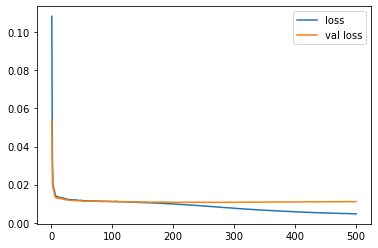

In [45]:
plt.figure()
x = np.linspace(1,epoch+1,epoch)
plt.plot(x,hist.history["loss"],label="loss")
plt.plot(x,hist.history["val_loss"],label="val loss")
plt.legend()
plt.savefig(f'Graphs/loss_{training_index}.png')
#print(np.shape(train_images))

encoded_imgs = autoencoder.encoder(NEP_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
np.save(f"encoded_{training_index}",encoded_imgs)
np.save(f"decoded_{training_index}",decoded_imgs)

encoded_val = autoencoder.encoder(NEP_valid).numpy()
np.save(f"encoded_val_{training_index}",encoded_val)

In [46]:
np.load("encoded_nick_test.npy")

array([[-2.1045146 , -3.899675  , -0.37694848, ...,  3.290339  ,
        -0.25862068, -2.9674702 ],
       [-2.7799566 , -3.711347  , -1.3375316 , ...,  6.120341  ,
         0.44463438, -5.529713  ],
       [-3.416804  , -7.734902  ,  0.4095139 , ...,  3.953443  ,
         0.16758609, -1.2065389 ],
       ...,
       [-5.528694  , -4.2502265 ,  1.6937013 , ...,  6.971111  ,
        -4.517115  , -7.0695796 ],
       [-4.8899736 , -1.8683114 ,  2.575927  , ...,  1.6413943 ,
        -1.4579124 , -4.71916   ],
       [-0.39773577, -5.4796314 ,  8.477837  , ...,  6.817906  ,
        -8.574806  , -2.86048   ]], dtype=float32)

0.011116812005639076


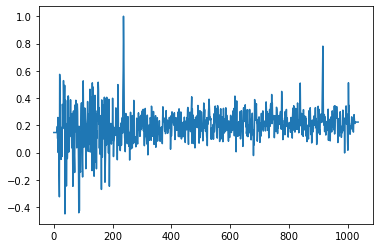

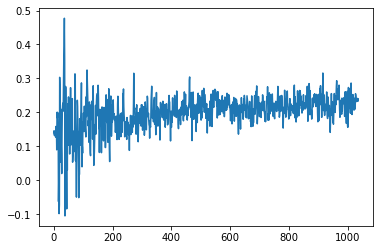

In [49]:
plt.figure()
plt.plot(NEP_train[3])
plt.savefig("OG.png")
plt.figure()
plt.plot(decoded_imgs[3])
plt.savefig("RECON.png")
print(hist.history["val_loss"][-1])